In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
%run ./master_experminet-functions.ipynb
# load functions for the creation of the different distributions

In [43]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [44]:
n_samples = 50000
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf"]

In [45]:
#list_distributions = 1000*["Uniform_Sorted"] + 1000*["Normal"] # at first quick sort -> then merge sort 
list_distributions = 500*["Uniform"] +  500*["Uniform_Sorted"] + 500*["Normal"] + 500*["Uniform_Reverse_Sorted"]
#list_distributions = 100*["Uniform"] +  100*["Uniform_Sorted"] + 100*["Normal"] + 100*["Uniform_Reverse_Sorted"]

In [46]:
def plot_history(rewards,cum_rewards,sample_count, sample_mean):

    q_values = {"quick_sort": sample_mean[0], "merge_sort": sample_mean[1], "heap_sort":sample_mean[2]} ## 
    arm_counts = {"quick_sort": sample_count[0], "merge_sort": sample_count[1], "heap_sort":sample_count[2]} ##
    print("Average rewards per algo", q_values)
    print("Count per chosen algo", arm_counts)
    
    fig = plt.figure(figsize=[30,8])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards")
    labels = list(arm_counts.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar([i for i in range(len(arm_counts.values()))], arm_counts.values(), label=[i for i in ((list(arm_counts.keys())))])
    ax3.set_title("Chosen Actions")
    plt.show() 

In [47]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [48]:
def TS_stationary(list_distributions, n_samples, var_multiplier = 5): # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = 5
    list_iteration_results = []

    len_result = 1

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter() #time.time()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        array_rewards = np.array(rewards)

    list_iteration_results.extend([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [49]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [50]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial
import matplotlib.cm as cm

## Thompson Sampling

# Probabs sampled from t Student distribution

### Quick sort should be the fastest at first 500 itreations, then merge sort for for the next 500, then again quick sort for the next 500, then again merge sort for the next 500: i.e. change points/restart experiment at iteration 500, 1000 and 1500

### First Variant: One sample t-test: 
The One Sample t Test determines whether the sample mean is statistically different from a known or hypothesised population mean or in other words: the p_value is the estimated probability of achieving this value by chance from the sample set.  Generally, if we receive a p-value of less than a selected significance level, we can reject the null hypothesis and state that there is a significant difference, i.e. the sample comes from a different distribution.

In [51]:
def TS_ttest(list_distributions, n_samples, var_multiplier=5,p_val_multiplier=20,num_consec_elem=5):# initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    n_consecutive_list = [] # this list is to check whether
    list_iteration_results = []
    p_val_multiplier = p_val_multiplier
    num_consec_elem = num_consec_elem

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))

        tset, pval = ttest_1samp(arm_rewards[choice], reward)
        print("\n")
        print("p-value: ", pval)
        print("Significance level: ", (sample_var[choice]**p_val_multiplier))

        if pval < sample_var[choice]**p_val_multiplier:
            n_consecutive_list.append(n)
            if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    print("RESTART EXPERIMENT AT ITERATION:", n)

                    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                    sample_count = [0 for i in range(num_choices)]
                    sample_rewards = [0 for i in range(num_choices)]
                    sample_mean = [0.0 for i in range(num_choices)]
                    sample_var = [0.0 for i in range(num_choices)]
                    arm_rewards = {0: [], 1:[], 2:[]}
                    rewards = []
                    cum_rewards = []
                    n_consecutive_list = []

    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [52]:
list_iteration_results_TS_ttest, total_reward_TS_ttest = TS_ttest(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.04539094446825653
Less than two values for merge_sort
merge_sort Theta 0.8104771316852433
Less than two values for heap_sort
heap_sort Theta 0.14387612016055362


Chosen algorithm is:  quick_sort with reward: 0.009883900000204449
Sample mean is:  0.009883900000204449 Sample variance is: 0.0


p-value:  nan
Significance level:  0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.03686998122841978
Less than two values for merge_sort
merge_sort Theta 0.5411226754174537
Less than two values for heap_sort
heap_sort Theta 0.0072684779065788074


Chosen algorithm is:  heap_sort with reward: 0.011219700000310695
Sample mean is:  0.011219700000310695 Sample variance is: 0.0


p-value:  nan
Significance level:  0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.8774841838503137
Less than two values for merge_sort
merge_sort Theta 0.32985929825523963
Less than two values for heap_sor

C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\iRacheva\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\iRacheva\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



merge_sort Theta 0.3049259507338816
Less than two values for heap_sort
heap_sort Theta 0.7416327432718646


Chosen algorithm is:  quick_sort with reward: 0.00982060000023921
Sample mean is:  0.008213277777789093 Sample variance is: 2.887103790802768e-06


p-value:  0.028118291452132668
Significance level:  1.6190040651371275e-111


Iteration: 11
quick_sort Theta 0.010069536718214922
Less than two values for merge_sort
merge_sort Theta 0.531479120348454
Less than two values for heap_sort
heap_sort Theta 0.9595527656197961


Chosen algorithm is:  quick_sort with reward: 0.008047000000260596
Sample mean is:  0.008196650000036243 Sample variance is: 2.600881758659475e-06


p-value:  0.7870109065385867
Significance level:  2.006375309741515e-112


Iteration: 12
quick_sort Theta 0.007782696953797823
Less than two values for merge_sort
merge_sort Theta 0.2131490526599511
Less than two values for heap_sort
heap_sort Theta 0.35882773388389866


Chosen algorithm is:  quick_sort with reward: 0.0



Chosen algorithm is:  quick_sort with reward: 0.007497499999772117
Sample mean is:  0.007359161764725286 Sample variance is: 1.3697863647490508e-06


p-value:  0.5018696848141926
Significance level:  5.4082502128137925e-118


Iteration: 36
quick_sort Theta 0.006720511959026952
Less than two values for merge_sort
merge_sort Theta 0.35867561071308407
Less than two values for heap_sort
heap_sort Theta 0.27382203118738546


Chosen algorithm is:  quick_sort with reward: 0.008194400000320456
Sample mean is:  0.00738302571431372 Sample variance is: 1.3500122065291224e-06


p-value:  0.00026342127298294973
Significance level:  4.043467029903902e-118


Iteration: 37
quick_sort Theta 0.0077329007877844835
Less than two values for merge_sort
merge_sort Theta 0.7125745971743997
Less than two values for heap_sort
heap_sort Theta 0.8815704080118618


Chosen algorithm is:  quick_sort with reward: 0.006410800000139716
Sample mean is:  0.007356019444475553 Sample variance is: 1.3380387188288846e-06





Iteration: 61
quick_sort Theta 0.007754013171496221
Less than two values for merge_sort
merge_sort Theta 0.41062761202527487
Less than two values for heap_sort
heap_sort Theta 0.9407089170655897


Chosen algorithm is:  quick_sort with reward: 0.008473000000321917
Sample mean is:  0.007125015000080263 Sample variance is: 1.058580040268587e-06


p-value:  2.0275188759670027e-14
Significance level:  3.1222956250252145e-120


Iteration: 62
quick_sort Theta 0.006933844152873919
Less than two values for merge_sort
merge_sort Theta 0.2634392375472844
Less than two values for heap_sort
heap_sort Theta 0.017896851476813636


Chosen algorithm is:  quick_sort with reward: 0.005947499999820138
Sample mean is:  0.0071057114754858345 Sample variance is: 1.0635838328227048e-06


p-value:  3.1763712145864763e-12
Significance level:  3.431109220585316e-120


Iteration: 63
quick_sort Theta 0.0067350449603391545
Less than two values for merge_sort
merge_sort Theta 0.11279806351877186
Less than two valu

Less than two values for heap_sort
heap_sort Theta 0.08036459226537429


Chosen algorithm is:  quick_sort with reward: 0.007415800000217132
Sample mean is:  0.0070968071429162935 Sample variance is: 9.148969423484788e-07


p-value:  0.0031802148902701274
Significance level:  1.6882762968232244e-121


Iteration: 86
quick_sort Theta 0.007150500193602703
Less than two values for merge_sort
merge_sort Theta 0.10242721491978057
Less than two values for heap_sort
heap_sort Theta 0.3773225884532351


Chosen algorithm is:  quick_sort with reward: 0.009132399999998597
Sample mean is:  0.007120755294176086 Sample variance is: 9.523086206050822e-07


p-value:  5.479069970566535e-32
Significance level:  3.7631741293893173e-121


Iteration: 87
quick_sort Theta 0.006884318929340074
Less than two values for merge_sort
merge_sort Theta 0.5227964484140704
Less than two values for heap_sort
heap_sort Theta 0.6183384592137168


Chosen algorithm is:  quick_sort with reward: 0.006519699999898876
Sample mea



Iteration: 110
quick_sort Theta 0.006267890540254332
Less than two values for merge_sort
merge_sort Theta 0.7470662344556582
Less than two values for heap_sort
heap_sort Theta 0.5923422186341143


Chosen algorithm is:  quick_sort with reward: 0.009032400000251073
Sample mean is:  0.007126877981703595 Sample variance is: 9.35280159717152e-07


p-value:  5.5896162745129585e-39
Significance level:  2.623218299928998e-121


Iteration: 111
quick_sort Theta 0.007051562696569198
Less than two values for merge_sort
merge_sort Theta 0.12840339580147886
Less than two values for heap_sort
heap_sort Theta 0.7490206670246646


Chosen algorithm is:  quick_sort with reward: 0.008865799999966839
Sample mean is:  0.007142686363687806 Sample variance is: 9.540172513751347e-07


p-value:  2.9803697526392493e-35
Significance level:  3.9005384320099524e-121


Iteration: 112
quick_sort Theta 0.008004191499801515
Less than two values for merge_sort
merge_sort Theta 0.9085930345995372
Less than two values f



Chosen algorithm is:  quick_sort with reward: 0.008410800000092422
Sample mean is:  0.0070610873134778086 Sample variance is: 8.991459287443452e-07


p-value:  8.838383047124661e-34
Significance level:  1.1928989146879943e-121


Iteration: 136
quick_sort Theta 0.007584723455379795
Less than two values for merge_sort
merge_sort Theta 0.4904123323729719
Less than two values for heap_sort
heap_sort Theta 0.010099329712051297


Chosen algorithm is:  quick_sort with reward: 0.007397800000035204
Sample mean is:  0.0070635814815263815 Sample variance is: 8.933191856815306e-07


p-value:  7.30695957767339e-05
Significance level:  1.0474498220674177e-121


Iteration: 137
quick_sort Theta 0.00695385011531051
Less than two values for merge_sort
merge_sort Theta 0.729861557159165
Less than two values for heap_sort
heap_sort Theta 0.18627632783250647


Chosen algorithm is:  quick_sort with reward: 0.007036099999822909
Sample mean is:  0.007063379411807974 Sample variance is: 8.867561746004997e-07



Iteration: 162
quick_sort Theta 0.007875472844539985
Less than two values for merge_sort
merge_sort Theta 0.11013640542934833
Less than two values for heap_sort
heap_sort Theta 0.15888382689936253


Chosen algorithm is:  quick_sort with reward: 0.008203099999718688
Sample mean is:  0.007001611180150791 Sample variance is: 8.550864431184666e-07


p-value:  3.4788874831323524e-36
Significance level:  4.3671732406510254e-122


Iteration: 163
quick_sort Theta 0.006848985690084943
Less than two values for merge_sort
merge_sort Theta 0.7812222543568526
Less than two values for heap_sort
heap_sort Theta 0.61654182851243


Chosen algorithm is:  quick_sort with reward: 0.0060244999999667925
Sample mean is:  0.0069955796296558275 Sample variance is: 8.556652475622913e-07


p-value:  9.17767366773407e-28
Significance level:  4.4266774032830296e-122


Iteration: 164
quick_sort Theta 0.006721144040967594
Less than two values for merge_sort
merge_sort Theta 0.13948744303736482
Less than two values



Chosen algorithm is:  quick_sort with reward: 0.008624399999916932
Sample mean is:  0.006987376063844227 Sample variance is: 8.77264706496779e-07


p-value:  9.578092826632408e-59
Significance level:  7.288080308202558e-122


Iteration: 190
quick_sort Theta 0.006824854962505949
Less than two values for merge_sort
merge_sort Theta 0.43225842452700824
Less than two values for heap_sort
heap_sort Theta 0.13320729190303116


Chosen algorithm is:  quick_sort with reward: 0.007664500000373664
Sample mean is:  0.006990958730175071 Sample variance is: 8.750361679242664e-07


p-value:  8.746312167090172e-19
Significance level:  6.926599580987129e-122


Iteration: 191
quick_sort Theta 0.007564368822593813
Less than two values for merge_sort
merge_sort Theta 0.658246677470926
Less than two values for heap_sort
heap_sort Theta 0.9225657557267141


Chosen algorithm is:  quick_sort with reward: 0.007269600000199716
Sample mean is:  0.0069924252631752 Sample variance is: 8.708372003075244e-07


p-v



Chosen algorithm is:  quick_sort with reward: 0.007022300000244286
Sample mean is:  0.00695264351853624 Sample variance is: 8.978785355091885e-07


p-value:  0.28229345347572216
Significance level:  1.1597163784776357e-121


Iteration: 218
quick_sort Theta 0.006803526397514316
Less than two values for merge_sort
merge_sort Theta 0.4540994745760416
Less than two values for heap_sort
heap_sort Theta 0.15714329790280246


Chosen algorithm is:  quick_sort with reward: 0.0071909000002960966
Sample mean is:  0.006953741474673382 Sample variance is: 8.940012360641427e-07


p-value:  0.0002877470418881978
Significance level:  1.0635609547454486e-121


Iteration: 219
quick_sort Theta 0.006568037518095136
Less than two values for merge_sort
merge_sort Theta 0.007795050124610903
Less than two values for heap_sort
heap_sort Theta 0.14469749156585077


Chosen algorithm is:  quick_sort with reward: 0.005896900000152527
Sample mean is:  0.006948893578001268 Sample variance is: 8.950002691280691e-07



Chosen algorithm is:  quick_sort with reward: 0.007290200000170444
Sample mean is:  0.0069299814049805 Sample variance is: 8.273004910143512e-07


p-value:  3.2286324932472852e-09
Significance level:  2.2556184680238528e-122


Iteration: 245
quick_sort Theta 0.007265162680392739
merge_sort Theta 0.04033466228061258
Less than two values for heap_sort
heap_sort Theta 0.024598630448066205


Chosen algorithm is:  quick_sort with reward: 0.008052199999838194
Sample mean is:  0.006934599588498433 Sample variance is: 8.29057246044029e-07


p-value:  3.391159553763902e-50
Significance level:  2.3533709522297106e-122


Iteration: 246
quick_sort Theta 0.007012007159783843
merge_sort Theta 0.012717099907286259
Less than two values for heap_sort
heap_sort Theta 0.7681684224376637


Chosen algorithm is:  quick_sort with reward: 0.007969499999944674
Sample mean is:  0.006938840983627311 Sample variance is: 8.300309025768308e-07


p-value:  2.2318902116555074e-45
Significance level:  2.409268678873

Significance level:  1.9696968420139343e-122


Iteration: 268
quick_sort Theta 0.006990720012966819
merge_sort Theta 0.003728947295686939
Less than two values for heap_sort
heap_sort Theta 0.795286410595314


Chosen algorithm is:  merge_sort with reward: 0.009695599999758997
Sample mean is:  0.008745328571356887 Sample variance is: 1.7312930559814752e-06


p-value:  0.12729274190714857
Significance level:  5.853447702672778e-116


Iteration: 269
quick_sort Theta 0.007111471174544718
merge_sort Theta 0.0067431285733401645
Less than two values for heap_sort
heap_sort Theta 0.8859212090533998


Chosen algorithm is:  merge_sort with reward: 0.007825499999853491
Sample mean is:  0.008630349999918963 Sample variance is: 1.607421927213132e-06


p-value:  0.13693188755179012
Significance level:  1.3261656259688414e-116


Iteration: 270
quick_sort Theta 0.0064437746431342605
merge_sort Theta 0.008398218705044785
Less than two values for heap_sort
heap_sort Theta 0.7858236132126475


Chosen algo



Iteration: 291
quick_sort Theta 0.007170558516441333
merge_sort Theta 0.00643119948786212
Less than two values for heap_sort
heap_sort Theta 0.8116551662249984


Chosen algorithm is:  merge_sort with reward: 0.009843799999998737
Sample mean is:  0.008405738461463513 Sample variance is: 1.4221141222508644e-06


p-value:  0.0012825449806580496
Significance level:  1.1446928859870425e-117


Iteration: 292
quick_sort Theta 0.007034436501232088
merge_sort Theta 0.008763581790091285
Less than two values for heap_sort
heap_sort Theta 0.21105455593544775


Chosen algorithm is:  quick_sort with reward: 0.006935400000202208
Sample mean is:  0.006989963799299152 Sample variance is: 9.119718894768349e-07


p-value:  0.3415917654835132
Significance level:  1.5835399989223185e-121


Iteration: 293
quick_sort Theta 0.007246933036658237
merge_sort Theta 0.009807265985596732
Less than two values for heap_sort
heap_sort Theta 0.7238352433503338


Chosen algorithm is:  quick_sort with reward: 0.0059205



Iteration: 316
quick_sort Theta 0.007233258060792548
merge_sort Theta 0.008496930561813066
Less than two values for heap_sort
heap_sort Theta 0.577675495369996


Chosen algorithm is:  quick_sort with reward: 0.00835689999985334
Sample mean is:  0.006986669204168997 Sample variance is: 9.223852733307503e-07


p-value:  2.0719274040386346e-71
Significance level:  1.9872257645058705e-121


Iteration: 317
quick_sort Theta 0.007356630557351378
merge_sort Theta 0.009057856487146316
Less than two values for heap_sort
heap_sort Theta 0.6225557029147013


Chosen algorithm is:  quick_sort with reward: 0.007361200000104873
Sample mean is:  0.006987960689672224 Sample variance is: 9.19686667615854e-07


p-value:  1.7826335658593092e-10
Significance level:  1.8741218076367617e-121


Iteration: 318
quick_sort Theta 0.006683331401740447
merge_sort Theta 0.008092896237642803
Less than two values for heap_sort
heap_sort Theta 0.639086580738965


Chosen algorithm is:  quick_sort with reward: 0.0069450



Iteration: 344
quick_sort Theta 0.007120014569987166
merge_sort Theta 0.007507188488806569
Less than two values for heap_sort
heap_sort Theta 0.16086260127769914


Chosen algorithm is:  quick_sort with reward: 0.0069108999996387865
Sample mean is:  0.006955690705145419 Sample variance is: 8.829082754442535e-07


p-value:  0.40119520441167167
Significance level:  8.285366977702893e-122


Iteration: 345
quick_sort Theta 0.006944419240351199
merge_sort Theta 0.007547097218191192
Less than two values for heap_sort
heap_sort Theta 0.6678689237243671


Chosen algorithm is:  quick_sort with reward: 0.006996000000071945
Sample mean is:  0.006955819488835281 Sample variance is: 8.800926568264689e-07


p-value:  0.4498998561731944
Significance level:  7.772629171853453e-122


Iteration: 346
quick_sort Theta 0.006558948476787684
merge_sort Theta 0.008418183672872927
Less than two values for heap_sort
heap_sort Theta 0.3279133611433892


Chosen algorithm is:  quick_sort with reward: 0.0062115000



p-value:  0.0702467648739103
Significance level:  5.633791711334297e-122


Iteration: 371
quick_sort Theta 0.006461582708547826
merge_sort Theta 0.00951775269228156
Less than two values for heap_sort
heap_sort Theta 0.6845108205428889


Chosen algorithm is:  quick_sort with reward: 0.0071897000002536515
Sample mean is:  0.006922205705723446 Sample variance is: 8.63658952170612e-07


p-value:  2.7953295159192645e-07
Significance level:  5.331452942960212e-122


Iteration: 372
quick_sort Theta 0.006857593508756572
merge_sort Theta 0.009624309823219136
Less than two values for heap_sort
heap_sort Theta 0.6592980862636866


Chosen algorithm is:  quick_sort with reward: 0.006661500000063825
Sample mean is:  0.0069214251497184765 Sample variance is: 8.612760330609975e-07


p-value:  5.414808732154603e-07
Significance level:  5.044838215952055e-122


Iteration: 373
quick_sort Theta 0.006840004955616966
merge_sort Theta 0.008846453886183825
Less than two values for heap_sort
heap_sort Theta 

Less than two values for heap_sort
heap_sort Theta 0.0649676640201845


Chosen algorithm is:  quick_sort with reward: 0.006730900000093243
Sample mean is:  0.006947405397743916 Sample variance is: 8.681727820780125e-07


p-value:  1.76149626232513e-05
Significance level:  5.917296410911939e-122


Iteration: 395
quick_sort Theta 0.006632449736187917
merge_sort Theta 0.007169611983708302
Less than two values for heap_sort
heap_sort Theta 0.15269692490186915


Chosen algorithm is:  quick_sort with reward: 0.007930599999781407
Sample mean is:  0.006950190651574051 Sample variance is: 8.684440579898159e-07


p-value:  6.441290536771235e-59
Significance level:  5.954385662300303e-122


Iteration: 396
quick_sort Theta 0.007134819419992382
merge_sort Theta 0.009462438056581934
Less than two values for heap_sort
heap_sort Theta 0.3232816285265637


Chosen algorithm is:  quick_sort with reward: 0.007528300000103627
Sample mean is:  0.006951823728829784 Sample variance is: 8.669322564746719e-07





p-value:  7.395145573632614e-05
Significance level:  3.223078304505226e-117


Iteration: 420
quick_sort Theta 0.007124651625001135
merge_sort Theta 0.007954089227050964
Less than two values for heap_sort
heap_sort Theta 0.973956158619458


Chosen algorithm is:  quick_sort with reward: 0.008349799999905372
Sample mean is:  0.0069384250000133745 Sample variance is: 8.466514727128944e-07


p-value:  1.7017283523922684e-99
Significance level:  3.581734275898193e-122


Iteration: 421
quick_sort Theta 0.007085925023412774
merge_sort Theta 0.008128154122817961
Less than two values for heap_sort
heap_sort Theta 0.21420164459395907


Chosen algorithm is:  quick_sort with reward: 0.006735899999966932
Sample mean is:  0.006937882037546762 Sample variance is: 8.44491298287847e-07


p-value:  2.832609682693511e-05
Significance level:  3.4033262105301576e-122


Iteration: 422
quick_sort Theta 0.007048444682910998
merge_sort Theta 0.007708569240594124
Less than two values for heap_sort
heap_sort Th

Less than two values for heap_sort
heap_sort Theta 0.9481716701825964


Chosen algorithm is:  quick_sort with reward: 0.006640699999934441
Sample mean is:  0.006930694642870103 Sample variance is: 8.20222941867611e-07


p-value:  6.666371344182725e-10
Significance level:  1.8994954133545268e-122


Iteration: 448
quick_sort Theta 0.006930831188599938
merge_sort Theta 0.008303484075270373
Less than two values for heap_sort
heap_sort Theta 0.7673924843030699


Chosen algorithm is:  quick_sort with reward: 0.006499300000086805
Sample mean is:  0.0069295969465780335 Sample variance is: 8.186081959532464e-07


p-value:  4.07820288810923e-19
Significance level:  1.8260882846937835e-122


Iteration: 449
quick_sort Theta 0.007177421736646227
merge_sort Theta 0.007745930508215312
Less than two values for heap_sort
heap_sort Theta 0.9078206589980011


Chosen algorithm is:  quick_sort with reward: 0.007744900000034249
Sample mean is:  0.0069316662436680245 Sample variance is: 8.18213332422246e-07




Chosen algorithm is:  quick_sort with reward: 0.007430399999975634
Sample mean is:  0.006896329539963198 Sample variance is: 8.163556934493992e-07


p-value:  1.1911841480030155e-28
Significance level:  1.7281781874493496e-122


Iteration: 476
quick_sort Theta 0.006994197353035272
merge_sort Theta 0.009145773444254554
heap_sort Theta 0.012010296294515856


Chosen algorithm is:  quick_sort with reward: 0.007384699999875011
Sample mean is:  0.006897509178755255 Sample variance is: 8.149585289854514e-07


p-value:  9.773964624300079e-25
Significance level:  1.6699758273123892e-122


Iteration: 477
quick_sort Theta 0.006945612473956067
merge_sort Theta 0.009264978373990509
heap_sort Theta 0.00968718964949633


Chosen algorithm is:  quick_sort with reward: 0.006457400000272173
Sample mean is:  0.006896448674710718 Sample variance is: 8.134603863889114e-07


p-value:  6.75368957237331e-21
Significance level:  1.6096378409673472e-122


Iteration: 478
quick_sort Theta 0.006821380789290469
me



Chosen algorithm is:  quick_sort with reward: 0.003573099999812257
Sample mean is:  0.006851874487483759 Sample variance is: 8.902835431204541e-07


p-value:  1.2470378820466506e-246
Significance level:  9.785136998499923e-122


Iteration: 503
quick_sort Theta 0.00716704984293569
merge_sort Theta 0.0070391482594463345
heap_sort Theta 0.011408966793451802


Chosen algorithm is:  merge_sort with reward: 0.002834400000210735
Sample mean is:  0.007754247457604047 Sample variance is: 1.755088220331164e-06


p-value:  1.267276273621199e-35
Significance level:  7.690932988123806e-116


Iteration: 504
quick_sort Theta 0.006881972483919692
merge_sort Theta 0.006841399041810946
heap_sort Theta 0.008239981312751435


Chosen algorithm is:  merge_sort with reward: 0.0024895999999898777
Sample mean is:  0.007666503333310478 Sample variance is: 2.1800795995269886e-06


p-value:  7.654743921371626e-35
Significance level:  5.880943661087318e-114


Iteration: 505
quick_sort Theta 0.006759359749778768



Chosen algorithm is:  merge_sort with reward: 0.002593700000034005
Sample mean is:  0.0027226249999898755 Sample variance is: 4.397240937161813e-08


p-value:  0.14783597162517875
Significance level:  7.30474819332286e-148


Iteration: 528
Less than two values for quick_sort
quick_sort Theta 0.28025581776284725
merge_sort Theta 0.002535473494428706
Less than two values for heap_sort
heap_sort Theta 0.5199568250562159


Chosen algorithm is:  merge_sort with reward: 0.0032706999995752994
Sample mean is:  0.002783522222166034 Sample variance is: 6.875435945828401e-08


p-value:  0.0007690446525158655
Significance level:  5.5719191679707e-144


Iteration: 529
Less than two values for quick_sort
quick_sort Theta 0.690985233492107
merge_sort Theta 0.0032124983405824726
Less than two values for heap_sort
heap_sort Theta 0.6529703970780162


Chosen algorithm is:  merge_sort with reward: 0.0029029000002083194
Sample mean is:  0.002795459999970262 Sample variance is: 6.31615183625838e-08


p-va


Chosen algorithm is:  merge_sort with reward: 0.0028112999998484156
Sample mean is:  0.00317167272723137 Sample variance is: 6.368579376809381e-07


p-value:  0.015594333833102004
Significance level:  1.2046234770629874e-124


Iteration: 553
Less than two values for quick_sort
quick_sort Theta 0.5887183521835849
merge_sort Theta 0.0031191690749729746
Less than two values for heap_sort
heap_sort Theta 0.3600231048492619


Chosen algorithm is:  merge_sort with reward: 0.004954600000019127
Sample mean is:  0.0032241117646663042 Sample variance is: 7.088719592211725e-07


p-value:  2.162598963292194e-13
Significance level:  1.0264928932399485e-123


Iteration: 554
Less than two values for quick_sort
quick_sort Theta 0.9401416360351151
merge_sort Theta 0.003160772473733918
Less than two values for heap_sort
heap_sort Theta 0.3764279502655621


Chosen algorithm is:  merge_sort with reward: 0.0038945999999668857
Sample mean is:  0.003243268571389178 Sample variance is: 7.010959049617926e-07



Iteration: 575
Less than two values for quick_sort
quick_sort Theta 0.6934866373515797
merge_sort Theta 0.0022516575342037015
Less than two values for heap_sort
heap_sort Theta 0.39735168689778433


Chosen algorithm is:  merge_sort with reward: 0.0034212999998999294
Sample mean is:  0.003340776785673175 Sample variance is: 8.661580267683711e-07


p-value:  0.5237602850637114
Significance level:  5.648624270684363e-122


Iteration: 576
Less than two values for quick_sort
quick_sort Theta 0.02418756138823197
merge_sort Theta 0.003222143762916953
Less than two values for heap_sort
heap_sort Theta 0.6484751400475309


Chosen algorithm is:  merge_sort with reward: 0.0016011000002436049
Sample mean is:  0.0033102561403147617 Sample variance is: 9.031268203260524e-07


p-value:  3.4001326114953206e-19
Significance level:  1.303091151820371e-121


Iteration: 577
Less than two values for quick_sort
quick_sort Theta 0.03227095167571448
merge_sort Theta 0.003147303247169068
Less than two values 

Iteration: 601
Less than two values for quick_sort
quick_sort Theta 0.1557383581005195
merge_sort Theta 0.002506450173352772
Less than two values for heap_sort
heap_sort Theta 0.26051972505486354


Chosen algorithm is:  merge_sort with reward: 0.003915499999948224
Sample mean is:  0.00310899999998383 Sample variance is: 8.266610406851137e-07


p-value:  8.103300064390598e-12
Significance level:  2.221004349458141e-122


Iteration: 602
Less than two values for quick_sort
quick_sort Theta 0.5832264112494849
merge_sort Theta 0.0034711239371329737
Less than two values for heap_sort
heap_sort Theta 0.1318851079500748


Chosen algorithm is:  merge_sort with reward: 0.004020200000013574
Sample mean is:  0.0031199783132372003 Sample variance is: 8.265841847855032e-07


p-value:  8.398710347844993e-14
Significance level:  2.2168781937985052e-122


Iteration: 603
Less than two values for quick_sort
quick_sort Theta 0.841202562988922
merge_sort Theta 0.003641023422066191
Less than two values for 



Iteration: 627
Less than two values for quick_sort
quick_sort Theta 0.15612733031302206
merge_sort Theta 0.003192982141634347
Less than two values for heap_sort
heap_sort Theta 0.042912290302214884


Chosen algorithm is:  merge_sort with reward: 0.004321599999911996
Sample mean is:  0.003131419444436553 Sample variance is: 9.202697381614391e-07


p-value:  2.190746160202758e-23
Significance level:  1.8980289022861915e-121


Iteration: 628
Less than two values for quick_sort
quick_sort Theta 0.06174226009566641
merge_sort Theta 0.0036092613818364014
Less than two values for heap_sort
heap_sort Theta 0.5025964987976059


Chosen algorithm is:  merge_sort with reward: 0.004600899999786634
Sample mean is:  0.003144900917421416 Sample variance is: 9.314559088218228e-07


p-value:  1.3598339254202673e-29
Significance level:  2.416829654792224e-121


Iteration: 629
Less than two values for quick_sort
quick_sort Theta 0.6714227728807973
merge_sort Theta 0.0031765944232893637
Less than two val



Chosen algorithm is:  merge_sort with reward: 0.0036847999999736203
Sample mean is:  0.0031210398496271346 Sample variance is: 8.491136499988086e-07


p-value:  1.0035801514639294e-10
Significance level:  3.795914742766725e-122


Iteration: 653
Less than two values for quick_sort
quick_sort Theta 0.03385755403157953
merge_sort Theta 0.002926995083572743
Less than two values for heap_sort
heap_sort Theta 0.7783334450475676


Chosen algorithm is:  merge_sort with reward: 0.0028557000000546395
Sample mean is:  0.0031190597014959967 Sample variance is: 8.432984721895928e-07


p-value:  0.0012113207891368853
Significance level:  3.308462909820058e-122


Iteration: 654
Less than two values for quick_sort
quick_sort Theta 0.20579939406396308
merge_sort Theta 0.0035315544012770794
Less than two values for heap_sort
heap_sort Theta 0.9172357357769785


Chosen algorithm is:  merge_sort with reward: 0.002882599999793456
Sample mean is:  0.003117308148150052 Sample variance is: 8.374629206826148

heap_sort Theta 0.7959155598962054


Chosen algorithm is:  merge_sort with reward: 0.0035714000000552915
Sample mean is:  0.003054973456792253 Sample variance is: 7.394605598013493e-07


p-value:  2.0518441991349232e-12
Significance level:  2.3894629698122012e-123


Iteration: 683
Less than two values for quick_sort
quick_sort Theta 0.8517600369357634
merge_sort Theta 0.0034452781086551586
Less than two values for heap_sort
heap_sort Theta 0.11300573883254539


Chosen algorithm is:  merge_sort with reward: 0.002741799999967043
Sample mean is:  0.0030530521472411777 Sample variance is: 7.355220036731577e-07


p-value:  7.811184762035602e-06
Significance level:  2.147402180853957e-123


Iteration: 684
Less than two values for quick_sort
quick_sort Theta 0.4389282375129522
merge_sort Theta 0.0026315672032077198
Less than two values for heap_sort
heap_sort Theta 0.664816327771103


Chosen algorithm is:  merge_sort with reward: 0.002785700000003999
Sample mean is:  0.0030514219512214388 Sam



Iteration: 712
Less than two values for quick_sort
quick_sort Theta 0.12991230295465606
merge_sort Theta 0.003569794018619214
Less than two values for heap_sort
heap_sort Theta 0.8544142485565489


Chosen algorithm is:  merge_sort with reward: 0.0028386999997565
Sample mean is:  0.0030171557291633158 Sample variance is: 6.346149936759356e-07


p-value:  0.0022571155121123274
Significance level:  1.1225522743844568e-124


Iteration: 713
Less than two values for quick_sort
quick_sort Theta 0.9857337148211616
merge_sort Theta 0.0028613483227642894
Less than two values for heap_sort
heap_sort Theta 0.9130835602486485


Chosen algorithm is:  merge_sort with reward: 0.0028148999999757507
Sample mean is:  0.003016107772017266 Sample variance is: 6.315376902094927e-07


p-value:  0.0005616917279357465
Significance level:  1.0185573516685021e-124


Iteration: 714
Less than two values for quick_sort
quick_sort Theta 0.17369563814817823
merge_sort Theta 0.0027378805912669146
Less than two value

heap_sort Theta 0.38091367814247


Chosen algorithm is:  merge_sort with reward: 0.0034882999998444575
Sample mean is:  0.002998179545451504 Sample variance is: 5.678743003248324e-07


p-value:  1.635909328631624e-18
Significance level:  1.2163100483688143e-125


Iteration: 741
Less than two values for quick_sort
quick_sort Theta 0.8677873942639005
merge_sort Theta 0.0029887908238122683
Less than two values for heap_sort
heap_sort Theta 0.9099158627997185


Chosen algorithm is:  merge_sort with reward: 0.0027600000003076275
Sample mean is:  0.0029971018099531153 Sample variance is: 5.655602663920239e-07


p-value:  5.094420401736302e-06
Significance level:  1.1209282315919922e-125


Iteration: 742
Less than two values for quick_sort
quick_sort Theta 0.6897098021962602
merge_sort Theta 0.002649448628200047
Less than two values for heap_sort
heap_sort Theta 0.5355900633829299


Chosen algorithm is:  merge_sort with reward: 0.0026932999999189633
Sample mean is:  0.00299573333333134 Sample



Iteration: 768
Less than two values for quick_sort
quick_sort Theta 0.056891424674343716
merge_sort Theta 0.0033181922908952196
Less than two values for heap_sort
heap_sort Theta 0.4858295806431806


Chosen algorithm is:  merge_sort with reward: 0.0027632000001176493
Sample mean is:  0.002980912903212591 Sample variance is: 5.191743653732932e-07


p-value:  3.472057515574839e-06
Significance level:  2.024253104790868e-126


Iteration: 769
Less than two values for quick_sort
quick_sort Theta 0.37878535872073593
merge_sort Theta 0.002882832805926117
Less than two values for heap_sort
heap_sort Theta 0.8324560125494285


Chosen algorithm is:  merge_sort with reward: 0.0030520999998771003
Sample mean is:  0.002981198795167067 Sample variance is: 5.171095978453415e-07


p-value:  0.1217694880623953
Significance level:  1.8691836431298868e-126


Iteration: 770
Less than two values for quick_sort
quick_sort Theta 0.7538138954810057
merge_sort Theta 0.002753441025469779
Less than two values 



Iteration: 796
Less than two values for quick_sort
quick_sort Theta 0.3788792116089409
merge_sort Theta 0.002983035296783377
Less than two values for heap_sort
heap_sort Theta 0.8573216358895125


Chosen algorithm is:  merge_sort with reward: 0.0026981000000887434
Sample mean is:  0.002957822463756294 Sample variance is: 4.887066775895726e-07


p-value:  2.5596377081968943e-09
Significance level:  6.03900603507276e-127


Iteration: 797
Less than two values for quick_sort
quick_sort Theta 0.11722857853841362
merge_sort Theta 0.0026301127573801083
Less than two values for heap_sort
heap_sort Theta 0.9270222404467042


Chosen algorithm is:  merge_sort with reward: 0.002565599999797996
Sample mean is:  0.002956406498182437 Sample variance is: 4.874957621027049e-07


p-value:  4.502707575013997e-18
Significance level:  5.746678391587341e-127


Iteration: 798
Less than two values for quick_sort
quick_sort Theta 0.21324871028369918
merge_sort Theta 0.0029183425312047377
Less than two values


Iteration: 820
Less than two values for quick_sort
quick_sort Theta 0.623249099309939
merge_sort Theta 0.003016586577685777
Less than two values for heap_sort
heap_sort Theta 0.5762031594625954


Chosen algorithm is:  merge_sort with reward: 0.003439399999933812
Sample mean is:  0.00296719966665781 Sample variance is: 4.872203961431361e-07


p-value:  2.7947411801454286e-26
Significance level:  5.682104426845253e-127


Iteration: 821
Less than two values for quick_sort
quick_sort Theta 0.024592611510614648
merge_sort Theta 0.003085418396037181
Less than two values for heap_sort
heap_sort Theta 0.08249787586183877


Chosen algorithm is:  merge_sort with reward: 0.002679200000329729
Sample mean is:  0.0029662428571351255 Sample variance is: 4.858763690695105e-07


p-value:  7.411475539371846e-12
Significance level:  5.37669680844418e-127


Iteration: 822
Less than two values for quick_sort
quick_sort Theta 0.9980963955599479
merge_sort Theta 0.0033613357277924266
Less than two values fo

Iteration: 846
Less than two values for quick_sort
quick_sort Theta 0.06333234751972194
merge_sort Theta 0.0030780672903180603
heap_sort Theta 0.0065031184147489


Chosen algorithm is:  merge_sort with reward: 0.0034694999999373977
Sample mean is:  0.0029638950617254523 Sample variance is: 4.731956377957363e-07


p-value:  3.7741080229477763e-32
Significance level:  3.1682150136678623e-127


Iteration: 847
Less than two values for quick_sort
quick_sort Theta 0.9636112002552494
merge_sort Theta 0.0030801508694965935
heap_sort Theta 0.005647063694746502


Chosen algorithm is:  merge_sort with reward: 0.001784600000064529
Sample mean is:  0.0029602664615357263 Sample variance is: 4.760056747630519e-07


p-value:  7.770089427109935e-98
Significance level:  3.5665030929025885e-127


Iteration: 848
Less than two values for quick_sort
quick_sort Theta 0.8022567504958056
merge_sort Theta 0.0027025761109726433
heap_sort Theta 0.005303272470183152


Chosen algorithm is:  merge_sort with reward: 

quick_sort Theta 0.24025886362614757
merge_sort Theta 0.003024848239029926
heap_sort Theta 0.005155621498696025


Chosen algorithm is:  merge_sort with reward: 0.00347860000010769
Sample mean is:  0.002969311239188813 Sample variance is: 5.159733442709939e-07


p-value:  1.857718047363725e-32
Significance level:  1.7887321869765793e-126


Iteration: 872
Less than two values for quick_sort
quick_sort Theta 0.3374132912459876
merge_sort Theta 0.002764598254446961
heap_sort Theta 0.006857279397979336


Chosen algorithm is:  merge_sort with reward: 0.0027982999999949243
Sample mean is:  0.002968819827581934 Sample variance is: 5.145744576697061e-07


p-value:  1.2756543727008882e-05
Significance level:  1.694199307801966e-126


Iteration: 873
Less than two values for quick_sort
quick_sort Theta 0.6426732010145438
merge_sort Theta 0.0031848258017672373
heap_sort Theta 0.0017629219545964568


Chosen algorithm is:  heap_sort with reward: 0.006189700000049925
Sample mean is:  0.005574716666690



Chosen algorithm is:  merge_sort with reward: 0.004330100000061066
Sample mean is:  0.0029593363881371374 Sample variance is: 5.088266338401073e-07


p-value:  2.8471545411172945e-126
Significance level:  1.3533082078112467e-126


Iteration: 897
Less than two values for quick_sort
quick_sort Theta 0.1911622794733231
merge_sort Theta 0.0026166245014896607
heap_sort Theta 0.00587674189769877


Chosen algorithm is:  merge_sort with reward: 0.0029485999998541956
Sample mean is:  0.0029593075268783122 Sample variance is: 5.074591293409879e-07


p-value:  0.772346719156988
Significance level:  1.2823937715298112e-126


Iteration: 898
Less than two values for quick_sort
quick_sort Theta 0.42942119381545607
merge_sort Theta 0.0032475211937356683
heap_sort Theta 0.0054036042031252954


Chosen algorithm is:  merge_sort with reward: 0.0026769000000967935
Sample mean is:  0.0029585504021416324 Sample variance is: 5.063118935879518e-07


p-value:  1.9318618376633575e-13
Significance level:  1.225



Chosen algorithm is:  merge_sort with reward: 0.003999799999746756
Sample mean is:  0.0029705175126849923 Sample variance is: 5.221107083885764e-07


p-value:  1.2953802223505166e-96
Significance level:  2.2659588143359723e-126


Iteration: 921
Less than two values for quick_sort
quick_sort Theta 0.35881947072306286
merge_sort Theta 0.002971633379312204
heap_sort Theta 0.005840997654491647


Chosen algorithm is:  merge_sort with reward: 0.0027163999998265353
Sample mean is:  0.0029698741772094016 Sample variance is: 5.209519780572899e-07


p-value:  1.3340868203667696e-11
Significance level:  2.167473656490669e-126


Iteration: 922
Less than two values for quick_sort
quick_sort Theta 0.23824736555341086
merge_sort Theta 0.0033244746906765355
heap_sort Theta 0.005806953622773207


Chosen algorithm is:  merge_sort with reward: 0.0033877000000757107
Sample mean is:  0.0029709292929237102 Sample variance is: 5.20076184081545e-07


p-value:  1.5259082310938118e-26
Significance level:  2.0



Chosen algorithm is:  merge_sort with reward: 0.0033333999999740627
Sample mean is:  0.0029475964538978675 Sample variance is: 4.992877340888076e-07


p-value:  9.911834574037378e-26
Significance level:  9.268681079740036e-127


Iteration: 950
Less than two values for quick_sort
quick_sort Theta 0.8538769800021879
merge_sort Theta 0.002765022936297244
heap_sort Theta 0.006512489618124661


Chosen algorithm is:  merge_sort with reward: 0.002636299999721814
Sample mean is:  0.002946862264147452 Sample variance is: 4.983381803096279e-07


p-value:  5.337164577832365e-18
Significance level:  8.922431873382436e-127


Iteration: 951
Less than two values for quick_sort
quick_sort Theta 0.845857782573171
merge_sort Theta 0.0028272020590926774
heap_sort Theta 0.005494456011550562


Chosen algorithm is:  merge_sort with reward: 0.0027175000000170257
Sample mean is:  0.002946322588231851 Sample variance is: 4.97289109925175e-07


p-value:  7.453335132911597e-11
Significance level:  8.5541916383

Sample mean is:  0.0029288347345101076 Sample variance is: 4.727957038045083e-07


p-value:  2.0043842686900032e-27
Significance level:  3.11508879723878e-127


Iteration: 979
Less than two values for quick_sort
quick_sort Theta 0.3153783380491322
merge_sort Theta 0.0029352708092137145
heap_sort Theta 0.004370876755267167


Chosen algorithm is:  merge_sort with reward: 0.00260580000031041
Sample mean is:  0.0029281216335516093 Sample variance is: 4.7198185254472103e-07


p-value:  2.600320338827337e-21
Significance level:  3.0095808250259324e-127


Iteration: 980
Less than two values for quick_sort
quick_sort Theta 0.5903701920232631
merge_sort Theta 0.0027394372926603946
heap_sort Theta 0.0043270356368823246


Chosen algorithm is:  merge_sort with reward: 0.0026449000001775858
Sample mean is:  0.0029274977973547506 Sample variance is: 4.711185396750287e-07


p-value:  3.8397556279700454e-17
Significance level:  2.901375254252958e-127


Iteration: 981
Less than two values for quick_sor



Iteration: 1007
Less than two values for quick_sort
quick_sort Theta 0.6766163528816292
Less than two values for merge_sort
merge_sort Theta 0.9229545917987354
Less than two values for heap_sort
heap_sort Theta 0.9373782274816729


Chosen algorithm is:  quick_sort with reward: 0.0071354000001520035
Sample mean is:  0.006482800000185307 Sample variance is: 4.2588675995653224e-07


p-value:  0.49999999999999956
Significance level:  3.853743251227142e-128


Iteration: 1008
quick_sort Theta 0.0030756511803883145
Less than two values for merge_sort
merge_sort Theta 0.5786064903504102
Less than two values for heap_sort
heap_sort Theta 0.30795904344900116


Chosen algorithm is:  quick_sort with reward: 0.005938599999808503
Sample mean is:  0.006301400000059705 Sample variance is: 3.497364267288246e-07


p-value:  0.47708372473127403
Significance level:  7.495789300215115e-130


Iteration: 1009
quick_sort Theta 0.009023131286718573
Less than two values for merge_sort
merge_sort Theta 0.36609



Iteration: 1034
quick_sort Theta 0.007335429086836209
Less than two values for merge_sort
merge_sort Theta 0.9816071389405112
Less than two values for heap_sort
heap_sort Theta 0.22556816323633488


Chosen algorithm is:  quick_sort with reward: 0.005908199999794306
Sample mean is:  0.006536571428633968 Sample variance is: 2.9138161921363034e-07


p-value:  1.8606784749291683e-06
Significance level:  1.9464490811196968e-131


Iteration: 1035
quick_sort Theta 0.00553524235290568
Less than two values for merge_sort
merge_sort Theta 0.06758204674925938
Less than two values for heap_sort
heap_sort Theta 0.4035010735759482


Chosen algorithm is:  quick_sort with reward: 0.005983600000035949
Sample mean is:  0.006517503448337485 Sample variance is: 2.9151443760421925e-07


p-value:  1.4689479065874633e-05
Significance level:  1.9642708500098385e-131


Iteration: 1036
quick_sort Theta 0.00725550657154795
Less than two values for merge_sort
merge_sort Theta 0.5067229830947602
Less than two va



Iteration: 1061
quick_sort Theta 0.005911807292855056
Less than two values for merge_sort
merge_sort Theta 0.6319322313786139
heap_sort Theta 0.009252632704526151


Chosen algorithm is:  quick_sort with reward: 0.006904200000008132
Sample mean is:  0.006518352830237248 Sample variance is: 2.7216071007755307e-07


p-value:  2.1233431809726433e-06
Significance level:  4.971742041484709e-132


Iteration: 1062
quick_sort Theta 0.006225030604734601
Less than two values for merge_sort
merge_sort Theta 0.3768568523684922
heap_sort Theta 0.021735612543903632


Chosen algorithm is:  quick_sort with reward: 0.006090599999879487
Sample mean is:  0.006510431481526919 Sample variance is: 2.704463284936721e-07


p-value:  2.8372468937100495e-07
Significance level:  4.3814897401351033e-132


Iteration: 1063
quick_sort Theta 0.006201431386568913
Less than two values for merge_sort
merge_sort Theta 0.11741960102940419
heap_sort Theta 0.0046306025091154175


Chosen algorithm is:  heap_sort with reward



Chosen algorithm is:  quick_sort with reward: 0.0080708999998933
Sample mean is:  0.006389315000046736 Sample variance is: 2.981866502946363e-07


p-value:  4.60941055913869e-42
Significance level:  3.0886160718293357e-131


Iteration: 1091
quick_sort Theta 0.006594026022041085
Less than two values for merge_sort
merge_sort Theta 0.3677844605555588
heap_sort Theta 0.007864246388276033


Chosen algorithm is:  quick_sort with reward: 0.005975199999738834
Sample mean is:  0.006384202469178737 Sample variance is: 2.965963713744314e-07


p-value:  2.4660598724518184e-09
Significance level:  2.7753430313073574e-131


Iteration: 1092
quick_sort Theta 0.006403970029618228
Less than two values for merge_sort
merge_sort Theta 0.4884786769509175
heap_sort Theta 0.008231334533128392


Chosen algorithm is:  quick_sort with reward: 0.005917699999827164
Sample mean is:  0.00637851341467445 Sample variance is: 2.95600935088604e-07


p-value:  4.041778555805439e-11
Significance level:  2.594872783797

Chosen algorithm is:  quick_sort with reward: 0.006964000000152737
Sample mean is:  0.006378734862414395 Sample variance is: 2.738822606366618e-07


p-value:  9.636217097070731e-21
Significance level:  5.639986675097826e-132


Iteration: 1120
quick_sort Theta 0.006024997915132722
Less than two values for merge_sort
merge_sort Theta 0.9604457137578053
heap_sort Theta 0.010787364773191213


Chosen algorithm is:  quick_sort with reward: 0.005953800000042975
Sample mean is:  0.006374871818211018 Sample variance is: 2.730190409499805e-07


p-value:  1.715470911844637e-13
Significance level:  5.2949118584579334e-132


Iteration: 1121
quick_sort Theta 0.005930671230299757
Less than two values for merge_sort
merge_sort Theta 0.17629357035149829
heap_sort Theta 0.011020952954498415


Chosen algorithm is:  quick_sort with reward: 0.00591260000010152
Sample mean is:  0.006370707207237059 Sample variance is: 2.724672482525177e-07


p-value:  2.5968147525240847e-15
Significance level:  5.0849432842



Chosen algorithm is:  quick_sort with reward: 0.006854400000065652
Sample mean is:  0.006407417037058217 Sample variance is: 2.65039944831437e-07


p-value:  4.674281931162522e-18
Significance level:  2.9256788320222745e-132


Iteration: 1147
quick_sort Theta 0.006231702626084135
Less than two values for merge_sort
merge_sort Theta 0.059466931608814
heap_sort Theta 0.008596820290419587


Chosen algorithm is:  quick_sort with reward: 0.005899300000237417
Sample mean is:  0.006403680882375712 Sample variance is: 2.649755667022439e-07


p-value:  1.815916539988119e-21
Significance level:  2.91149864972626e-132


Iteration: 1148
quick_sort Theta 0.00618148584487524
Less than two values for merge_sort
merge_sort Theta 0.7497249952530283
heap_sort Theta 0.010620683436988009


Chosen algorithm is:  quick_sort with reward: 0.005978299999696901
Sample mean is:  0.006400575912429151 Sample variance is: 2.6435259249633006e-07


p-value:  6.343591132957695e-17
Significance level:  2.777611345604



Iteration: 1175
quick_sort Theta 0.006503877052990226
Less than two values for merge_sort
merge_sort Theta 0.02263281529543193
heap_sort Theta 0.007833194862726683


Chosen algorithm is:  quick_sort with reward: 0.006892899999911606
Sample mean is:  0.006367569512216195 Sample variance is: 2.552596228543793e-07


p-value:  9.848799621341308e-28
Significance level:  1.3792483231986785e-132


Iteration: 1176
quick_sort Theta 0.006042237929233651
Less than two values for merge_sort
merge_sort Theta 0.9554722954221433
heap_sort Theta 0.010168605681530706


Chosen algorithm is:  quick_sort with reward: 0.006838499999958003
Sample mean is:  0.006370423636384327 Sample variance is: 2.5504854289888714e-07


p-value:  7.532345338115825e-24
Significance level:  1.3566159995254365e-132


Iteration: 1177
quick_sort Theta 0.006606209120825192
Less than two values for merge_sort
merge_sort Theta 0.6291560757287609
heap_sort Theta 0.007791234073166962


Chosen algorithm is:  quick_sort with reward:

Chosen algorithm is:  quick_sort with reward: 0.005926600000293547
Sample mean is:  0.006313841361276962 Sample variance is: 2.46748696980612e-07


p-value:  2.3956625682996986e-21
Significance level:  6.9999890217506584e-133


Iteration: 1204
quick_sort Theta 0.006214424434885751
merge_sort Theta 0.006189608617799284
heap_sort Theta 0.011264719422375044


Chosen algorithm is:  merge_sort with reward: 0.0066323999999440275
Sample mean is:  0.006827166666577493 Sample variance is: 9.760562885757165e-08


p-value:  0.470968662787701
Significance level:  6.158816686674083e-141


Iteration: 1205
quick_sort Theta 0.0063547534518265105
merge_sort Theta 0.006365835389568832
heap_sort Theta 0.009389803520832365


Chosen algorithm is:  quick_sort with reward: 0.006779399999686575
Sample mean is:  0.006316266145852012 Sample variance is: 2.465865473421328e-07


p-value:  9.26767331019845e-28
Significance level:  6.908560972530092e-133


Iteration: 1206
quick_sort Theta 0.006049761747530174
merge



Iteration: 1231
quick_sort Theta 0.006166894988906809
merge_sort Theta 0.007406389182095435
heap_sort Theta 0.010376127498621514


Chosen algorithm is:  quick_sort with reward: 0.005985499999951571
Sample mean is:  0.006321357345992915 Sample variance is: 2.3713541799468288e-07


p-value:  1.7291047290273791e-19
Significance level:  3.161756941717356e-133


Iteration: 1232
quick_sort Theta 0.006416097478834324
merge_sort Theta 0.007429125158222705
heap_sort Theta 0.01028797580570164


Chosen algorithm is:  quick_sort with reward: 0.005917800000133866
Sample mean is:  0.006319453773606788 Sample variance is: 2.3678143173422212e-07


p-value:  1.3370994881582882e-25
Significance level:  3.0686887782375123e-133


Iteration: 1233
quick_sort Theta 0.006149586736121378
merge_sort Theta 0.007188979029943794
heap_sort Theta 0.00930287084648351


Chosen algorithm is:  quick_sort with reward: 0.0059470999999575724
Sample mean is:  0.006317705633824397 Sample variance is: 2.3631765227211764e-07



Chosen algorithm is:  quick_sort with reward: 0.006468900000072608
Sample mean is:  0.00629082142859834 Sample variance is: 2.249257515169476e-07


p-value:  2.3348774186965103e-08
Significance level:  1.0984583744168512e-133


Iteration: 1261
quick_sort Theta 0.006252883269133941
merge_sort Theta 0.006010465199197016
heap_sort Theta 0.010425185700876204


Chosen algorithm is:  merge_sort with reward: 0.006603400000130932
Sample mean is:  0.007010699999947671 Sample variance is: 1.4589520339680454e-07


p-value:  0.004660184931966281
Significance level:  1.9090630686597823e-137


Iteration: 1262
quick_sort Theta 0.0065593787305745655
merge_sort Theta 0.007730064665477857
heap_sort Theta 0.008258299220958326


Chosen algorithm is:  quick_sort with reward: 0.005874800000128744
Sample mean is:  0.006289080753165413 Sample variance is: 2.2470576791505986e-07


p-value:  3.675758030686839e-31
Significance level:  1.0771703910221642e-133


Iteration: 1263
quick_sort Theta 0.006407960666210



Chosen algorithm is:  quick_sort with reward: 0.006327000000055705
Sample mean is:  0.006268714068469117 Sample variance is: 2.1518482812636275e-07


p-value:  0.04297914331812746
Significance level:  4.531405756547708e-134


Iteration: 1291
quick_sort Theta 0.006406134848933717
merge_sort Theta 0.006218077907902955
heap_sort Theta 0.009113090835916264


Chosen algorithm is:  merge_sort with reward: 0.006602099999781785
Sample mean is:  0.006884552941087082 Sample variance is: 1.4146361314656823e-07


p-value:  0.008411000958244685
Significance level:  1.0301368560738293e-137


Iteration: 1292
quick_sort Theta 0.00628574959306556
merge_sort Theta 0.006861852470120722
heap_sort Theta 0.011022567699362974


Chosen algorithm is:  quick_sort with reward: 0.0059003999999731604
Sample mean is:  0.006267318939421784 Sample variance is: 2.14881633350871e-07


p-value:  1.3038111669374075e-29
Significance level:  4.405405905414099e-134


Iteration: 1293
quick_sort Theta 0.006079393352641709
m



Iteration: 1319
quick_sort Theta 0.006298666226680588
merge_sort Theta 0.007029008538736751
heap_sort Theta 0.009861834135655539


Chosen algorithm is:  quick_sort with reward: 0.006852900000012596
Sample mean is:  0.006273120069230239 Sample variance is: 2.125137234058929e-07


p-value:  2.894243380746341e-61
Significance level:  3.5297147578218815e-134


Iteration: 1320
quick_sort Theta 0.006370646125228599
merge_sort Theta 0.007163189184081141
heap_sort Theta 0.00958035760440046


Chosen algorithm is:  quick_sort with reward: 0.006760199999916949
Sample mean is:  0.006274799655198123 Sample variance is: 2.125961890709103e-07


p-value:  1.0049564124234139e-48
Significance level:  3.5572100018089995e-134


Iteration: 1321
quick_sort Theta 0.006258110353329035
merge_sort Theta 0.006751774280778141
heap_sort Theta 0.010149623011319501


Chosen algorithm is:  quick_sort with reward: 0.00585750000027474
Sample mean is:  0.006273365635765397 Sample variance is: 2.1246197737714341e-07






Iteration: 1349
quick_sort Theta 0.006206258527577673
merge_sort Theta 0.007095040763916394
heap_sort Theta 0.010037374440097257


Chosen algorithm is:  quick_sort with reward: 0.005948399999851972
Sample mean is:  0.006253352063517273 Sample variance is: 2.0696214478182977e-07


p-value:  3.9886493307799704e-27
Significance level:  2.0788268997464542e-134


Iteration: 1350
quick_sort Theta 0.005977488672109829
merge_sort Theta 0.006583721938733631
heap_sort Theta 0.011588997217711939


Chosen algorithm is:  quick_sort with reward: 0.005939699999998993
Sample mean is:  0.006252359493696013 Sample variance is: 2.0661753766345898e-07


p-value:  2.5030958072088457e-28
Significance level:  2.0106831195958896e-134


Iteration: 1351
quick_sort Theta 0.006409215792445682
merge_sort Theta 0.00718282463309367
heap_sort Theta 0.009320359264742784


Chosen algorithm is:  quick_sort with reward: 0.005851399999755813
Sample mean is:  0.006251094637248252 Sample variance is: 2.064713036631944e-07



Iteration: 1377
quick_sort Theta 0.006239361027908753
merge_sort Theta 0.007467132340352658
heap_sort Theta 0.009812439928644279


Chosen algorithm is:  quick_sort with reward: 0.006010900000092079
Sample mean is:  0.006247736842125737 Sample variance is: 2.0562215285949567e-07


p-value:  1.2710163934668275e-19
Significance level:  1.8255680981078045e-134


Iteration: 1378
quick_sort Theta 0.00599612554432812
merge_sort Theta 0.006841829306551951
heap_sort Theta 0.009280069295699894


Chosen algorithm is:  quick_sort with reward: 0.005938799999967159
Sample mean is:  0.006246836151623816 Sample variance is: 2.0530011660032363e-07


p-value:  4.6420059606243084e-30
Significance level:  1.7692284751046766e-134


Iteration: 1379
quick_sort Theta 0.006261009504434993
merge_sort Theta 0.006776477115836488
heap_sort Theta 0.010527785884637299


Chosen algorithm is:  quick_sort with reward: 0.00595260000000053
Sample mean is:  0.006245980813973749 Sample variance is: 2.0495425359178662e-07



Chosen algorithm is:  quick_sort with reward: 0.006782299999940733
Sample mean is:  0.00624379728262417 Sample variance is: 2.0303892804321596e-07


p-value:  1.0795302028116417e-72
Significance level:  1.4177061960366525e-134


Iteration: 1407
quick_sort Theta 0.006234425426093951
merge_sort Theta 0.00663251986546129
heap_sort Theta 0.008426193146443217


Chosen algorithm is:  quick_sort with reward: 0.0068330999997670006
Sample mean is:  0.006245394308957891 Sample variance is: 2.0342726851050835e-07


p-value:  2.5704280180203303e-81
Significance level:  1.472934227361389e-134


Iteration: 1408
quick_sort Theta 0.0061161672855098055
merge_sort Theta 0.0069677642072900735
heap_sort Theta 0.009598647555076965


Chosen algorithm is:  quick_sort with reward: 0.005854600000020582
Sample mean is:  0.006244338108122925 Sample variance is: 2.032891067972972e-07


p-value:  1.2280975738648046e-46
Significance level:  1.453055336264699e-134


Iteration: 1409
quick_sort Theta 0.0061132160219



Chosen algorithm is:  quick_sort with reward: 0.006607799999983399
Sample mean is:  0.006234028787894709 Sample variance is: 1.9801875948109247e-07


p-value:  1.004864169633231e-47
Significance level:  8.592641835305201e-135


Iteration: 1437
quick_sort Theta 0.006260620759917543
merge_sort Theta 0.006391543596186563
heap_sort Theta 0.01061450906600395


Chosen algorithm is:  quick_sort with reward: 0.006939899999906629
Sample mean is:  0.006235806801023203 Sample variance is: 1.9877185862513304e-07


p-value:  1.2485169430262153e-109
Significance level:  9.270389306524791e-135


Iteration: 1438
quick_sort Theta 0.006328086742977315
merge_sort Theta 0.006759011732069228
heap_sort Theta 0.0101164227692962


Chosen algorithm is:  quick_sort with reward: 0.005870899999990797
Sample mean is:  0.006234889949764327 Sample variance is: 1.986061564883357e-07


p-value:  5.502244426348872e-46
Significance level:  9.117045804215028e-135


Iteration: 1439
quick_sort Theta 0.006328598493229067



Iteration: 1465
quick_sort Theta 0.006106208808853877
merge_sort Theta 0.006837344956987489
heap_sort Theta 0.008790838109243767


Chosen algorithm is:  quick_sort with reward: 0.006588999999621592
Sample mean is:  0.006243017882368483 Sample variance is: 1.9684128288504948e-07


p-value:  1.142472138080017e-45
Significance level:  7.62647298961049e-135


Iteration: 1466
quick_sort Theta 0.006318470322044753
merge_sort Theta 0.006597793938899896
heap_sort Theta 0.009010372276320015


Chosen algorithm is:  quick_sort with reward: 0.006012400000145135
Sample mean is:  0.0062424765258374424 Sample variance is: 1.9650376757570542e-07


p-value:  8.068604126664829e-24
Significance level:  7.369153971398945e-135


Iteration: 1467
quick_sort Theta 0.006308308998741509
merge_sort Theta 0.006770143992135101
heap_sort Theta 0.010596039789109139


Chosen algorithm is:  quick_sort with reward: 0.0068712000002051354
Sample mean is:  0.00624394894615212 Sample variance is: 1.9696714859310422e-07






Chosen algorithm is:  quick_sort with reward: 0.0068023999997421924
Sample mean is:  0.0062426515486845545 Sample variance is: 1.9604302807652387e-07


p-value:  1.480515480034133e-95
Significance level:  7.031177147198252e-135


Iteration: 1495
quick_sort Theta 0.006323646008791398
merge_sort Theta 0.006536280587363602
heap_sort Theta 0.010970323596209784


Chosen algorithm is:  quick_sort with reward: 0.005900899999687681
Sample mean is:  0.006241897130254098 Sample variance is: 1.9586751653016193e-07


p-value:  1.110288281032964e-47
Significance level:  6.906346058266921e-135


Iteration: 1496
quick_sort Theta 0.006060271791085971
merge_sort Theta 0.00710058185716171
heap_sort Theta 0.010895336744508894


Chosen algorithm is:  quick_sort with reward: 0.0059014999997089035
Sample mean is:  0.0062411473568388005 Sample variance is: 1.9569074884125027e-07


p-value:  1.591198884767352e-47
Significance level:  6.782751448980858e-135


Iteration: 1497
quick_sort Theta 0.00617733714691



Chosen algorithm is:  quick_sort with reward: 0.0038687999999638123
Sample mean is:  0.0030833499999971536 Sample variance is: 2.2052829748738535e-07


p-value:  6.469024070450532e-07
Significance level:  7.400933351622261e-134


Iteration: 1525
quick_sort Theta 0.0031468177007027342
Less than two values for merge_sort
merge_sort Theta 0.3141777558994192
Less than two values for heap_sort
heap_sort Theta 0.19003740700556637


Chosen algorithm is:  quick_sort with reward: 0.002630699999826902
Sample mean is:  0.0030617952380842845 Sample variance is: 2.193191052103955e-07


p-value:  0.0005354869869234933
Significance level:  6.630240884933181e-134


Iteration: 1526
quick_sort Theta 0.002981873365451411
Less than two values for merge_sort
merge_sort Theta 0.6830411454099694
Less than two values for heap_sort
heap_sort Theta 0.7528958298667027


Chosen algorithm is:  quick_sort with reward: 0.002707399999962945
Sample mean is:  0.0030456863636242238 Sample variance is: 2.14799467537329



Chosen algorithm is:  quick_sort with reward: 0.004068899999765563
Sample mean is:  0.003162181632628095 Sample variance is: 2.477135190357687e-07


p-value:  7.323074815833802e-17
Significance level:  7.568227519535493e-133


Iteration: 1554
quick_sort Theta 0.0030254116016224766
Less than two values for merge_sort
merge_sort Theta 0.8242308597720736
Less than two values for heap_sort
heap_sort Theta 0.026165636855350782


Chosen algorithm is:  quick_sort with reward: 0.00360259999979462
Sample mean is:  0.0031709899999714255 Sample variance is: 2.465610280825508e-07


p-value:  1.733742623281739e-07
Significance level:  6.894275672817626e-133


Iteration: 1555
quick_sort Theta 0.003028137595058358
Less than two values for merge_sort
merge_sort Theta 0.1281238689383275
Less than two values for heap_sort
heap_sort Theta 0.947080670341832


Chosen algorithm is:  quick_sort with reward: 0.003654099999948812
Sample mean is:  0.003180462745069021 Sample variance is: 2.4621314310434916e-0



Iteration: 1582
quick_sort Theta 0.0028336742356080613
Less than two values for merge_sort
merge_sort Theta 0.9304278421263432
Less than two values for heap_sort
heap_sort Theta 0.9295881267216924


Chosen algorithm is:  quick_sort with reward: 0.002762700000403129
Sample mean is:  0.0031564653845926396 Sample variance is: 2.3705128018876077e-07


p-value:  5.448168884653402e-10
Significance level:  3.1393960038969167e-133


Iteration: 1583
quick_sort Theta 0.003018412553823595
Less than two values for merge_sort
merge_sort Theta 0.19549018769788973
Less than two values for heap_sort
heap_sort Theta 0.41477108631125637


Chosen algorithm is:  quick_sort with reward: 0.0026958999997077626
Sample mean is:  0.003150635443011819 Sample variance is: 2.367017121416388e-07


p-value:  3.0179151304246324e-12
Significance level:  3.0480914077849707e-133


Iteration: 1584
quick_sort Theta 0.0031020168173331777
Less than two values for merge_sort
merge_sort Theta 0.6110174411334274
Less than tw

merge_sort Theta 0.012663180500155469
Less than two values for heap_sort
heap_sort Theta 0.14988682203300085


Chosen algorithm is:  quick_sort with reward: 0.004086700000243582
Sample mean is:  0.003143651401863612 Sample variance is: 2.2994950827929207e-07


p-value:  3.2338929318175917e-38
Significance level:  1.7086365979165242e-133


Iteration: 1612
quick_sort Theta 0.0029217169288134393
Less than two values for merge_sort
merge_sort Theta 0.6405852966302584
Less than two values for heap_sort
heap_sort Theta 0.24068815194998983


Chosen algorithm is:  quick_sort with reward: 0.0030532000000675907
Sample mean is:  0.0031428138888840193 Sample variance is: 2.2789539896063047e-07


p-value:  0.05479341299931099
Significance level:  1.427943893953201e-133


Iteration: 1613
quick_sort Theta 0.002941584720656945
Less than two values for merge_sort
merge_sort Theta 0.22789275464339231
Less than two values for heap_sort
heap_sort Theta 0.13931103798749322


Chosen algorithm is:  quick_sor



Iteration: 1639
quick_sort Theta 0.0032738637244080332
Less than two values for merge_sort
merge_sort Theta 0.9548137068840189
Less than two values for heap_sort
heap_sort Theta 0.731048568068597


Chosen algorithm is:  quick_sort with reward: 0.002645600000050763
Sample mean is:  0.003164889629628036 Sample variance is: 2.2569063127927268e-07


p-value:  1.2392097327759177e-24
Significance level:  1.1756299083509372e-133


Iteration: 1640
quick_sort Theta 0.0032007395259746065
Less than two values for merge_sort
merge_sort Theta 0.47669650451540735
Less than two values for heap_sort
heap_sort Theta 0.6013172019859135


Chosen algorithm is:  quick_sort with reward: 0.003651699999863922
Sample mean is:  0.0031684691176444763 Sample variance is: 2.2576086049547407e-07


p-value:  1.4498965188647999e-22
Significance level:  1.1829681034655586e-133


Iteration: 1641
quick_sort Theta 0.003689295525633428
Less than two values for merge_sort
merge_sort Theta 0.5471709407313577
Less than two

Less than two values for merge_sort
merge_sort Theta 0.5171947645356973
Less than two values for heap_sort
heap_sort Theta 0.20732329774096958


Chosen algorithm is:  quick_sort with reward: 0.00413909999997486
Sample mean is:  0.003176296296285525 Sample variance is: 2.487936807015953e-07


p-value:  3.56818296771586e-56
Significance level:  8.256327350309528e-133


Iteration: 1668
quick_sort Theta 0.003201356245835837
Less than two values for merge_sort
merge_sort Theta 0.6882502726401727
Less than two values for heap_sort
heap_sort Theta 0.4593713915852271


Chosen algorithm is:  quick_sort with reward: 0.0032678999996278435
Sample mean is:  0.003176858282195601 Sample variance is: 2.47318503264625e-07


p-value:  0.021035640647138906
Significance level:  7.330476249110155e-133


Iteration: 1669
quick_sort Theta 0.0033874396850824768
Less than two values for merge_sort
merge_sort Theta 0.5849442227061519
Less than two values for heap_sort
heap_sort Theta 0.29596152804103826


Chosen

Less than two values for heap_sort
heap_sort Theta 0.827482358063912


Chosen algorithm is:  quick_sort with reward: 0.003583600000183651
Sample mean is:  0.003178235263141304 Sample variance is: 2.466406308850923e-07


p-value:  1.0110421273012561e-22
Significance level:  6.9389291339568595e-133


Iteration: 1696
quick_sort Theta 0.003181172472464887
Less than two values for merge_sort
merge_sort Theta 0.32175030355772016
Less than two values for heap_sort
heap_sort Theta 0.8038882852679387


Chosen algorithm is:  quick_sort with reward: 0.0026555999997981417
Sample mean is:  0.0031754989528620203 Sample variance is: 2.467719235309629e-07


p-value:  2.4097116816882735e-32
Significance level:  7.013179046414376e-133


Iteration: 1697
quick_sort Theta 0.0032455807258355666
Less than two values for merge_sort
merge_sort Theta 0.3879375140117238
Less than two values for heap_sort
heap_sort Theta 0.6505989648222356


Chosen algorithm is:  quick_sort with reward: 0.003659699999843724
Sampl



p-value:  4.457132687937962e-27
Significance level:  5.712141362070267e-133


Iteration: 1723
quick_sort Theta 0.0032814532198792235
Less than two values for merge_sort
merge_sort Theta 0.4149777910129815
Less than two values for heap_sort
heap_sort Theta 0.2580585918940289


Chosen algorithm is:  quick_sort with reward: 0.002693800000088231
Sample mean is:  0.003180260091725475 Sample variance is: 2.442231188865297e-07


p-value:  9.127502160563935e-34
Significance level:  5.698170804750145e-133


Iteration: 1724
quick_sort Theta 0.0031380399372448907
Less than two values for merge_sort
merge_sort Theta 0.12295064541588041
Less than two values for heap_sort
heap_sort Theta 0.36254651683358097


Chosen algorithm is:  quick_sort with reward: 0.0026963999998770305
Sample mean is:  0.003178050684913382 Sample variance is: 2.441721071322559e-07


p-value:  1.8627615645914944e-33
Significance level:  5.674414034387706e-133


Iteration: 1725
quick_sort Theta 0.002957005444569814
Less than 



Chosen algorithm is:  quick_sort with reward: 0.003890899999987596
Sample mean is:  0.0031926404081471503 Sample variance is: 2.3774163169377962e-07


p-value:  4.946288722629127e-61
Significance level:  3.3273982321356472e-133


Iteration: 1751
quick_sort Theta 0.0033531139683054593
Less than two values for merge_sort
merge_sort Theta 0.8068922337698257
Less than two values for heap_sort
heap_sort Theta 0.025858436497568915


Chosen algorithm is:  quick_sort with reward: 0.003605500000048778
Sample mean is:  0.0031943186991711405 Sample variance is: 2.3746528418314603e-07


p-value:  1.9564395275614435e-30
Significance level:  3.250892089918487e-133


Iteration: 1752
quick_sort Theta 0.003495203188184225
Less than two values for merge_sort
merge_sort Theta 0.5086709640055234
Less than two values for heap_sort
heap_sort Theta 0.3280292535522239


Chosen algorithm is:  quick_sort with reward: 0.0027007999997294974
Sample mean is:  0.003192320647756397 Sample variance is: 2.37485969797



Chosen algorithm is:  quick_sort with reward: 0.003672499999993306
Sample mean is:  0.0032275955056034395 Sample variance is: 2.786779372698838e-07


p-value:  7.579473660755217e-33
Significance level:  7.980897734788245e-132


Iteration: 1773
quick_sort Theta 0.0031901839420298817
Less than two values for merge_sort
merge_sort Theta 0.9172813491655576
Less than two values for heap_sort
heap_sort Theta 0.5778532290882255


Chosen algorithm is:  quick_sort with reward: 0.003657400000065536
Sample mean is:  0.003229199253717104 Sample variance is: 2.783248203595954e-07


p-value:  3.50306352743363e-31
Significance level:  7.781059721452402e-132


Iteration: 1774
quick_sort Theta 0.0030862974182809095
Less than two values for merge_sort
merge_sort Theta 0.801769199990247
Less than two values for heap_sort
heap_sort Theta 0.15058670395104


Chosen algorithm is:  quick_sort with reward: 0.003284799999619281
Sample mean is:  0.0032294059479397886 Sample variance is: 2.7730160523034757e-07


Sample mean is:  0.003236490377988507 Sample variance is: 2.7122591137506573e-07


p-value:  1.180808037731928e-137
Significance level:  4.641127974738702e-132


Iteration: 1797
quick_sort Theta 0.003278358893230641
Less than two values for merge_sort
merge_sort Theta 0.2360235408447965
Less than two values for heap_sort
heap_sort Theta 0.9733995551656247


Chosen algorithm is:  quick_sort with reward: 0.004837299999962852
Sample mean is:  0.003241972602721296 Sample variance is: 2.7904299882824556e-07


p-value:  2.7156181754764276e-148
Significance level:  8.192616227030525e-132


Iteration: 1798
quick_sort Theta 0.003274803700211041
Less than two values for merge_sort
merge_sort Theta 0.3056525077104527
Less than two values for heap_sort
heap_sort Theta 0.7327231363907689


Chosen algorithm is:  quick_sort with reward: 0.00394079999978203
Sample mean is:  0.0032443576791617765 Sample variance is: 2.797517018155962e-07


p-value:  9.979328927461242e-66
Significance level:  8.61895757



Chosen algorithm is:  quick_sort with reward: 0.003728500000306667
Sample mean is:  0.0032570598745948007 Sample variance is: 2.728203316092883e-07


p-value:  4.7227993381256325e-43
Significance level:  5.2183673632887654e-132


Iteration: 1825
quick_sort Theta 0.002830281826522363
Less than two values for merge_sort
merge_sort Theta 0.6324272066980564
Less than two values for heap_sort
heap_sort Theta 0.8665065453308269


Chosen algorithm is:  quick_sort with reward: 0.0026914999998552958
Sample mean is:  0.00325529249998624 Sample variance is: 2.729642006222378e-07


p-value:  1.96875274281465e-55
Significance level:  5.2736810119788554e-132


Iteration: 1826
quick_sort Theta 0.003290398722115674
Less than two values for merge_sort
merge_sort Theta 0.40839930244122213
Less than two values for heap_sort
heap_sort Theta 0.8893968332371477


Chosen algorithm is:  quick_sort with reward: 0.002601300000151241
Sample mean is:  0.0032532551401736696 Sample variance is: 2.7344211205893965



Iteration: 1853
quick_sort Theta 0.0032378724805382122
Less than two values for merge_sort
merge_sort Theta 0.6188074186955174
Less than two values for heap_sort
heap_sort Theta 0.5357378522529713


Chosen algorithm is:  quick_sort with reward: 0.0027814999998554413
Sample mean is:  0.0032463715517116894 Sample variance is: 2.716659393288818e-07


p-value:  5.084448189625187e-46
Significance level:  4.7940639778766223e-132


Iteration: 1854
quick_sort Theta 0.0031762051780444335
Less than two values for merge_sort
merge_sort Theta 0.8518093945374037
Less than two values for heap_sort
heap_sort Theta 0.4162563838815837


Chosen algorithm is:  quick_sort with reward: 0.003735599999799888
Sample mean is:  0.0032477733524225436 Sample variance is: 2.715713626363419e-07


p-value:  1.7403245316665346e-49
Significance level:  4.760794419297906e-132


Iteration: 1855
quick_sort Theta 0.003407332947913544
Less than two values for merge_sort
merge_sort Theta 0.5296763324545483
Less than two v

Sample mean is:  0.0032435021333209685 Sample variance is: 2.6668802574949774e-07


p-value:  1.1365194858422987e-59
Significance level:  3.31184747538102e-132


Iteration: 1881
quick_sort Theta 0.003247900913634818
Less than two values for merge_sort
merge_sort Theta 0.03817057425432646
Less than two values for heap_sort
heap_sort Theta 0.10180824372623065


Chosen algorithm is:  quick_sort with reward: 0.002820000000156142
Sample mean is:  0.0032423757978604236 Sample variance is: 2.664544859239006e-07


p-value:  1.187271527899929e-43
Significance level:  3.254323520256075e-132


Iteration: 1882
quick_sort Theta 0.0030486794064601063
Less than two values for merge_sort
merge_sort Theta 0.5174423837717177
Less than two values for heap_sort
heap_sort Theta 0.12667858478022298


Chosen algorithm is:  quick_sort with reward: 0.003716100000019651
Sample mean is:  0.0032436323607308725 Sample variance is: 2.6634139539218766e-07


p-value:  1.2050602972006476e-51
Significance level:  3.226

quick_sort Theta 0.0030216929280816197
Less than two values for merge_sort
merge_sort Theta 0.8854703418051717
Less than two values for heap_sort
heap_sort Theta 0.2493237754492642


Chosen algorithm is:  quick_sort with reward: 0.003526899999997113
Sample mean is:  0.003235138709664549 Sample variance is: 2.631806559179326e-07


p-value:  2.7498905863972587e-26
Significance level:  2.5414367132053976e-132


Iteration: 1909
quick_sort Theta 0.003299793110544789
Less than two values for merge_sort
merge_sort Theta 0.8167964857451706
Less than two values for heap_sort
heap_sort Theta 0.7613850632300787


Chosen algorithm is:  quick_sort with reward: 0.003635500000200409
Sample mean is:  0.0032361297029579548 Sample variance is: 2.6292499193696167e-07


p-value:  2.0750992396256836e-43
Significance level:  2.492512732271045e-132


Iteration: 1910
quick_sort Theta 0.0033107068415988467
Less than two values for merge_sort
merge_sort Theta 0.8920583932817268
Less than two values for heap_sor

Less than two values for heap_sort
heap_sort Theta 0.6563243672751254


Chosen algorithm is:  quick_sort with reward: 0.0036222999997335137
Sample mean is:  0.0032235295611868597 Sample variance is: 2.6138420618878267e-07


p-value:  1.637412861278589e-46
Significance level:  2.2160872077854877e-132


Iteration: 1939
quick_sort Theta 0.0032853726849085166
Less than two values for merge_sort
merge_sort Theta 0.7358323669708573
Less than two values for heap_sort
heap_sort Theta 0.6947442786973631


Chosen algorithm is:  quick_sort with reward: 0.002849900000001071
Sample mean is:  0.0032226686635804407 Sample variance is: 2.6110285408281076e-07


p-value:  4.909010915348025e-42
Significance level:  2.168864305638094e-132


Iteration: 1940
quick_sort Theta 0.003407996844348519
Less than two values for merge_sort
merge_sort Theta 0.3844882323824197
Less than two values for heap_sort
heap_sort Theta 0.6683040450970191


Chosen algorithm is:  quick_sort with reward: 0.003278499999851192
Samp



Chosen algorithm is:  quick_sort with reward: 0.0037549999997281702
Sample mean is:  0.003227528758156108 Sample variance is: 2.600704721517552e-07


p-value:  2.3208067921958335e-74
Significance level:  2.0036456712097005e-132


Iteration: 1965
quick_sort Theta 0.0032292673551573697
Less than two values for merge_sort
merge_sort Theta 0.4231166788784385
Less than two values for heap_sort
heap_sort Theta 0.21113176428803215


Chosen algorithm is:  quick_sort with reward: 0.002908899999965797
Sample mean is:  0.003226836086942651 Sample variance is: 2.597253267352891e-07


p-value:  1.2041298129550623e-34
Significance level:  1.9511291875106517e-132


Iteration: 1966
quick_sort Theta 0.003451731889212907
Less than two values for merge_sort
merge_sort Theta 0.4145505930095702
Less than two values for heap_sort
heap_sort Theta 0.28069726997720534


Chosen algorithm is:  quick_sort with reward: 0.0035990000001220324
Sample mean is:  0.003227643383934363 Sample variance is: 2.594617263117



Chosen algorithm is:  quick_sort with reward: 0.004037400000015623
Sample mean is:  0.0032223394250425912 Sample variance is: 2.587326590156832e-07


p-value:  2.5227211563623536e-136
Significance level:  1.8072783092117238e-132


Iteration: 1993
quick_sort Theta 0.0032795911119735555
Less than two values for merge_sort
merge_sort Theta 0.7507529289750504
Less than two values for heap_sort
heap_sort Theta 0.41905410600741744


Chosen algorithm is:  quick_sort with reward: 0.002650900000389811
Sample mean is:  0.003221168442615024 Sample variance is: 2.588702434654929e-07


p-value:  4.310743747149459e-88
Significance level:  1.8265965927246286e-132


Iteration: 1994
quick_sort Theta 0.0031699801702609323
Less than two values for merge_sort
merge_sort Theta 0.6487713481685221
Less than two values for heap_sort
heap_sort Theta 0.344590411287345


Chosen algorithm is:  quick_sort with reward: 0.003654199999800767
Sample mean is:  0.0032220539877217433 Sample variance is: 2.5872354125092

Iteration 518
Average rewards per algo {'quick_sort': 0.006769709333347136, 'merge_sort': 0.007589619672112573, 'heap_sort': 0.009168912500001625}
Count per chosen algo {'quick_sort': 450, 'merge_sort': 61, 'heap_sort': 8}


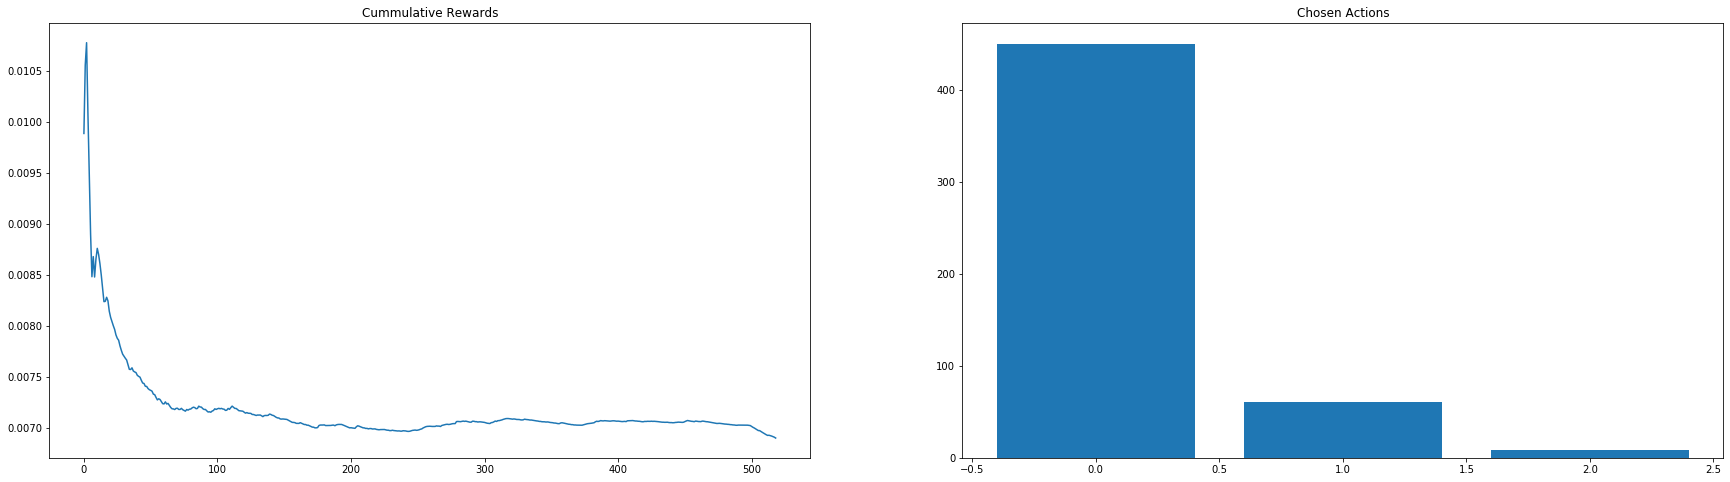

Iteration 1004
Average rewards per algo {'quick_sort': 0.002346899999793095, 'merge_sort': 0.0029630355648504933, 'heap_sort': 0.005573471428566076}
Count per chosen algo {'quick_sort': 1, 'merge_sort': 478, 'heap_sort': 7}


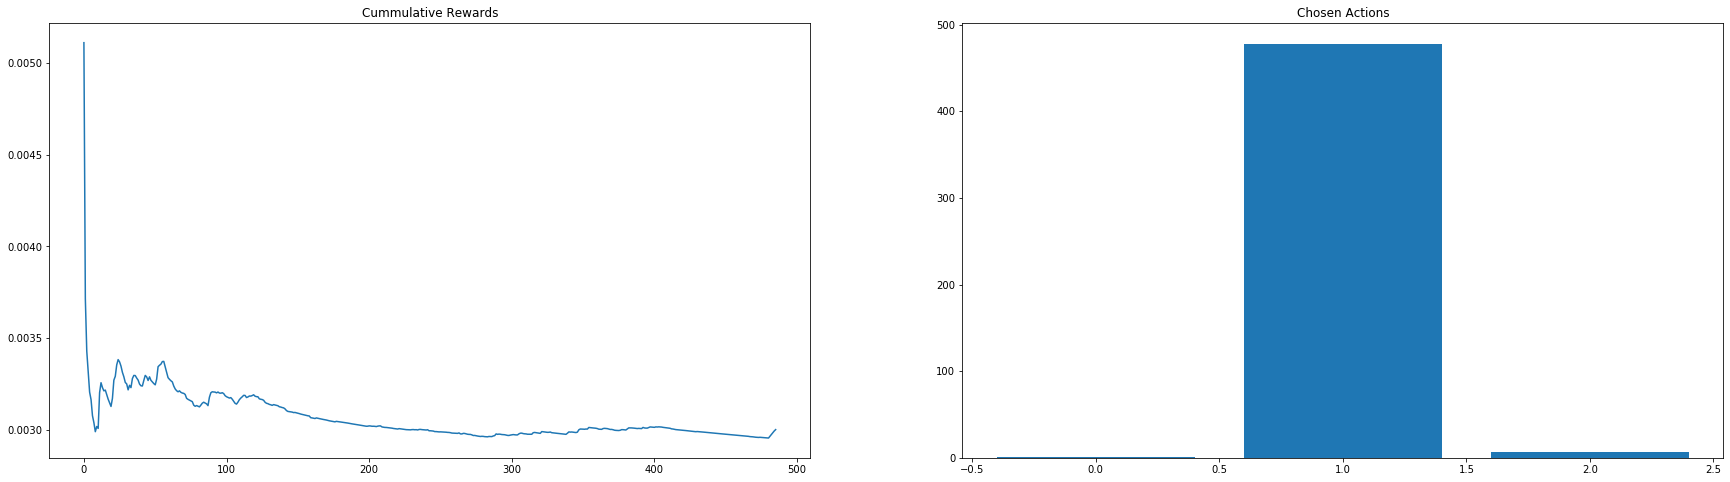

Iteration 1504
Average rewards per algo {'quick_sort': 0.006199110606071982, 'merge_sort': 0.006901629032199708, 'heap_sort': 0.009945171428691018}
Count per chosen algo {'quick_sort': 462, 'merge_sort': 31, 'heap_sort': 7}


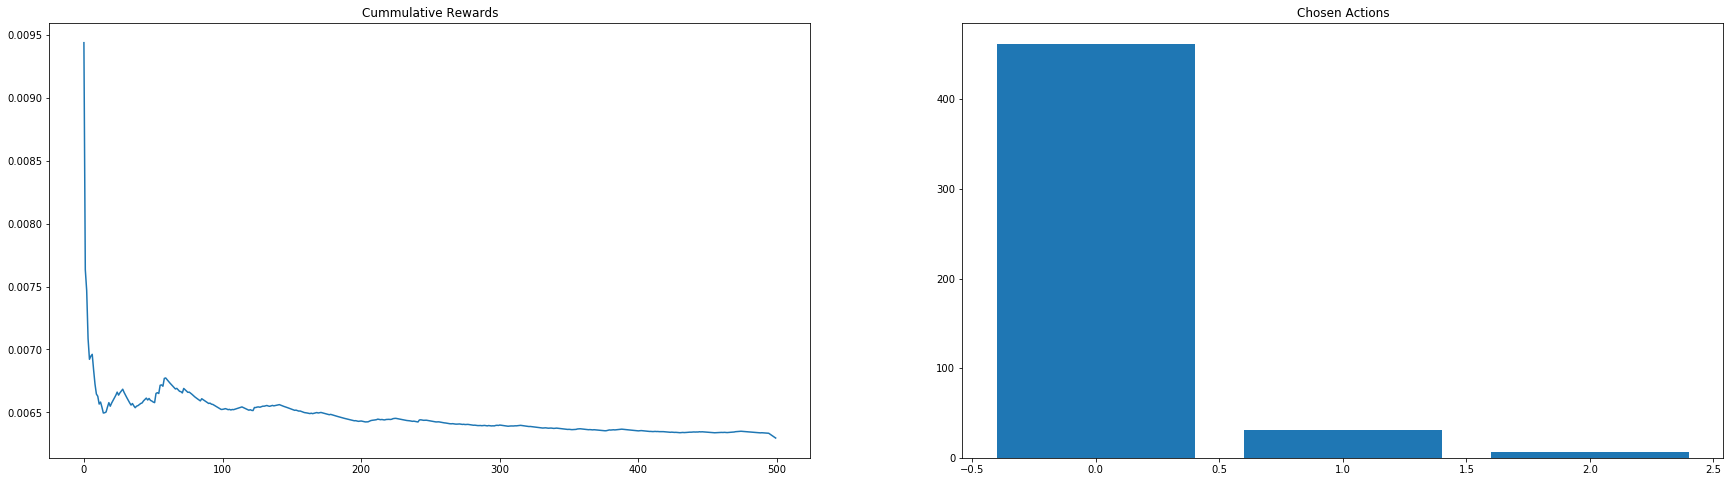

Iteration 1999
Average rewards per algo {'quick_sort': 0.003222655060719137, 'merge_sort': 0.0, 'heap_sort': 0.006365899999764224}
Count per chosen algo {'quick_sort': 494, 'merge_sort': 0, 'heap_sort': 1}


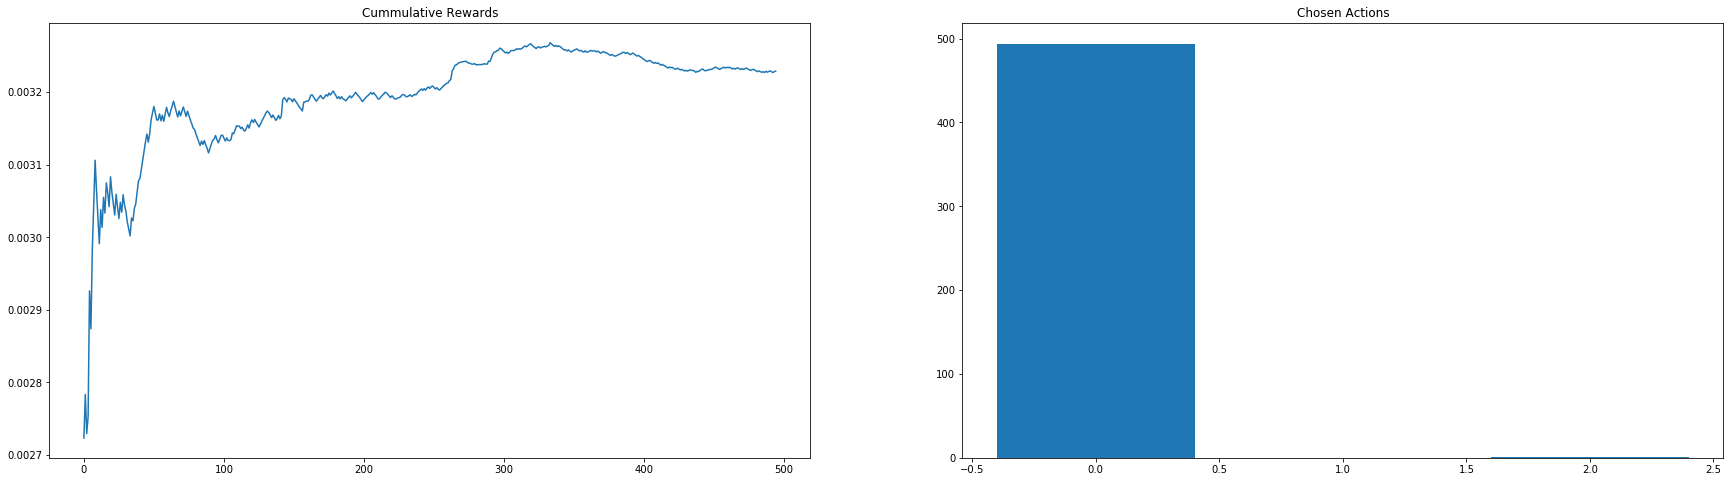

Total reward 9.7863


In [53]:
for elem in list_iteration_results_TS_ttest:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_TS_ttest,4))

### Second Variant: Change point detection 

## Offline changepoint detection - not adjustable to out case but works properly

In [54]:
list_iteration_results_TS_stationary, total_reward_TS_stationary = TS_stationary(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.9571820834968096
Less than two values for merge_sort
merge_sort Theta 0.3519201965977784
Less than two values for heap_sort
heap_sort Theta 0.34147286066946914


Chosen algorithm is:  heap_sort with reward: 0.010407199999917793
Sample mean is:  0.010407199999917793 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.01006673116642054
Less than two values for merge_sort
merge_sort Theta 0.8660902094256219
Less than two values for heap_sort
heap_sort Theta 0.3870618359103243


Chosen algorithm is:  quick_sort with reward: 0.009207799999785493
Sample mean is:  0.009207799999785493 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.06325774729187861
Less than two values for merge_sort
merge_sort Theta 0.403663375981973
Less than two values for heap_sort
heap_sort Theta 0.08911168958393001


Chosen algorithm is:  quick_sort with reward: 0

quick_sort Theta 0.006957222522964505
Less than two values for merge_sort
merge_sort Theta 0.8026899616684505
Less than two values for heap_sort
heap_sort Theta 0.16575723567487832


Chosen algorithm is:  quick_sort with reward: 0.007302399999844056
Sample mean is:  0.00655529285709885 Sample variance is: 9.173524235181807e-07


Iteration: 29
quick_sort Theta 0.006450380831078732
Less than two values for merge_sort
merge_sort Theta 0.10821962285425546
Less than two values for heap_sort
heap_sort Theta 0.6154601035473888


Chosen algorithm is:  quick_sort with reward: 0.006656999999904656
Sample mean is:  0.006558799999954223 Sample variance is: 8.86063982756122e-07


Iteration: 30
quick_sort Theta 0.0054883288423401184
Less than two values for merge_sort
merge_sort Theta 0.5497363886314698
Less than two values for heap_sort
heap_sort Theta 0.6341195684700209


Chosen algorithm is:  quick_sort with reward: 0.00587870000026669
Sample mean is:  0.006536129999964639 Sample variance is: 8.7



Iteration: 58
quick_sort Theta 0.005848057603282164
Less than two values for merge_sort
merge_sort Theta 0.5193820565227429
Less than two values for heap_sort
heap_sort Theta 0.016244682135157174


Chosen algorithm is:  quick_sort with reward: 0.0065094999999928405
Sample mean is:  0.006533443103449074 Sample variance is: 5.638964948701542e-07


Iteration: 59
quick_sort Theta 0.005672914683012571
Less than two values for merge_sort
merge_sort Theta 0.7937872774043756
Less than two values for heap_sort
heap_sort Theta 0.6032439871056217


Chosen algorithm is:  quick_sort with reward: 0.005821100000048318
Sample mean is:  0.006521369491527027 Sample variance is: 5.627937092414535e-07


Iteration: 60
quick_sort Theta 0.007017618030128167
Less than two values for merge_sort
merge_sort Theta 0.815515296496083
Less than two values for heap_sort
heap_sort Theta 0.8384935516961719


Chosen algorithm is:  quick_sort with reward: 0.005870099999810918
Sample mean is:  0.0065105149999984254 Samp



Chosen algorithm is:  quick_sort with reward: 0.006289100000230974
Sample mean is:  0.006544023863641128 Sample variance is: 4.501474424924675e-07


Iteration: 89
quick_sort Theta 0.00667814926694565
Less than two values for merge_sort
merge_sort Theta 0.26428617689414424
Less than two values for heap_sort
heap_sort Theta 0.7119525269011268


Chosen algorithm is:  quick_sort with reward: 0.005860600000232807
Sample mean is:  0.006536344943827551 Sample variance is: 4.5027859729626176e-07


Iteration: 90
quick_sort Theta 0.006294179702830263
Less than two values for merge_sort
merge_sort Theta 0.004605330709891109
Less than two values for heap_sort
heap_sort Theta 0.6576123346986871


Chosen algorithm is:  merge_sort with reward: 0.006495500000255561
Sample mean is:  0.006495500000255561 Sample variance is: 0.0


Iteration: 91
quick_sort Theta 0.006382021152218581
Less than two values for merge_sort
merge_sort Theta 0.8626192190625191
Less than two values for heap_sort
heap_sort Theta



Iteration: 119
quick_sort Theta 0.006320393702024677
Less than two values for merge_sort
merge_sort Theta 0.47727283367760986
Less than two values for heap_sort
heap_sort Theta 0.8054900747708602


Chosen algorithm is:  quick_sort with reward: 0.006980000000112341
Sample mean is:  0.006558274576275573 Sample variance is: 4.0433839679995267e-07


Iteration: 120
quick_sort Theta 0.0065263666530618394
Less than two values for merge_sort
merge_sort Theta 0.3520594455432615
Less than two values for heap_sort
heap_sort Theta 0.3216942718784198


Chosen algorithm is:  quick_sort with reward: 0.007080900000346446
Sample mean is:  0.006562666386561883 Sample variance is: 4.032165788619022e-07


Iteration: 121
quick_sort Theta 0.006986963949117577
Less than two values for merge_sort
merge_sort Theta 0.26204159190200815
Less than two values for heap_sort
heap_sort Theta 0.9779611874208968


Chosen algorithm is:  quick_sort with reward: 0.005927899999733199
Sample mean is:  0.006557376666671643 



Chosen algorithm is:  merge_sort with reward: 0.008332500000051368
Sample mean is:  0.007638314285746414 Sample variance is: 2.646934640024735e-07


Iteration: 148
quick_sort Theta 0.0068499956648940255
merge_sort Theta 0.009236948940339511
Less than two values for heap_sort
heap_sort Theta 0.1160520573261955


Chosen algorithm is:  quick_sort with reward: 0.006278299999848969
Sample mean is:  0.00654394751773449 Sample variance is: 3.8493921767259347e-07


Iteration: 149
quick_sort Theta 0.006572078766997771
merge_sort Theta 0.009040350125907062
Less than two values for heap_sort
heap_sort Theta 0.7243674195273963


Chosen algorithm is:  quick_sort with reward: 0.005858999999873049
Sample mean is:  0.006539123943665044 Sample variance is: 3.8550900633080386e-07


Iteration: 150
quick_sort Theta 0.007210617915878569
merge_sort Theta 0.0075854182206944185
Less than two values for heap_sort
heap_sort Theta 0.8866586239244107


Chosen algorithm is:  quick_sort with reward: 0.00593900000



Chosen algorithm is:  merge_sort with reward: 0.007370000000264554
Sample mean is:  0.007302914285771424 Sample variance is: 3.4697442115754954e-07


Iteration: 180
quick_sort Theta 0.006380444749286491
merge_sort Theta 0.0067440058709207365
Less than two values for heap_sort
heap_sort Theta 0.37835560125746504


Chosen algorithm is:  quick_sort with reward: 0.006750400000328227
Sample mean is:  0.0064962168674668076 Sample variance is: 3.7061430501809755e-07


Iteration: 181
quick_sort Theta 0.006259206386273735
merge_sort Theta 0.006632387084981002
Less than two values for heap_sort
heap_sort Theta 0.6547284481862333


Chosen algorithm is:  quick_sort with reward: 0.006938399999853573
Sample mean is:  0.006498864670654752 Sample variance is: 3.695588607285268e-07


Iteration: 182
quick_sort Theta 0.006543407058314641
merge_sort Theta 0.006802268290014657
Less than two values for heap_sort
heap_sort Theta 0.16373078496486115


Chosen algorithm is:  quick_sort with reward: 0.00690680



Iteration: 209
quick_sort Theta 0.00630175303545143
merge_sort Theta 0.007170180474308941
heap_sort Theta 0.010718795094518377


Chosen algorithm is:  quick_sort with reward: 0.005915100000038365
Sample mean is:  0.006480119786094759 Sample variance is: 3.532651915320129e-07


Iteration: 210
quick_sort Theta 0.006600901284236888
merge_sort Theta 0.007140234988273092
heap_sort Theta 0.010791365882048388


Chosen algorithm is:  quick_sort with reward: 0.0068681999996442755
Sample mean is:  0.006482184042549809 Sample variance is: 3.521829572954742e-07


Iteration: 211
quick_sort Theta 0.006226909000209838
merge_sort Theta 0.005967087017255959
heap_sort Theta 0.009508892654547064


Chosen algorithm is:  merge_sort with reward: 0.006588799999917683
Sample mean is:  0.007195872727317526 Sample variance is: 3.2962445559165095e-07


Iteration: 212
quick_sort Theta 0.006170587946305459
merge_sort Theta 0.006308750312393003
heap_sort Theta 0.010747338848360866


Chosen algorithm is:  quick_so



Iteration: 241
quick_sort Theta 0.006034029173874853
merge_sort Theta 0.006017645459700874
heap_sort Theta 0.010541852194146294


Chosen algorithm is:  merge_sort with reward: 0.007141199999750825
Sample mean is:  0.007118530769258331 Sample variance is: 3.222704305753446e-07


Iteration: 242
quick_sort Theta 0.006327667532361658
merge_sort Theta 0.007238635251436494
heap_sort Theta 0.01132552394769171


Chosen algorithm is:  quick_sort with reward: 0.005953200000021752
Sample mean is:  0.006431160747664949 Sample variance is: 3.396969832224873e-07


Iteration: 243
quick_sort Theta 0.006324716212463481
merge_sort Theta 0.006555167008338707
heap_sort Theta 0.007638180819051011


Chosen algorithm is:  quick_sort with reward: 0.005871200000001409
Sample mean is:  0.006428556279071166 Sample variance is: 3.3956861417839596e-07


Iteration: 244
quick_sort Theta 0.006561427242563563
merge_sort Theta 0.007431440934441801
heap_sort Theta 0.009786422853149228


Chosen algorithm is:  quick_sor



Iteration: 286
quick_sort Theta 0.006226661439656764
merge_sort Theta 0.007715315414819745
heap_sort Theta 0.009772338780698664


Chosen algorithm is:  quick_sort with reward: 0.006507599999622471
Sample mean is:  0.00640605849803107 Sample variance is: 3.2111836794761315e-07


Iteration: 287
quick_sort Theta 0.0063174493886522295
merge_sort Theta 0.006536010197364666
heap_sort Theta 0.009786920107952719


Chosen algorithm is:  quick_sort with reward: 0.0067384999997557316
Sample mean is:  0.006407367322841009 Sample variance is: 3.202875170674401e-07


Iteration: 288
quick_sort Theta 0.006353528302075473
merge_sort Theta 0.005824273176361755
heap_sort Theta 0.008735717582383737


Chosen algorithm is:  merge_sort with reward: 0.007440800000040326
Sample mean is:  0.007140265517262315 Sample variance is: 3.2615555327213974e-07


Iteration: 289
quick_sort Theta 0.006446757075192996
merge_sort Theta 0.006482188479848355
heap_sort Theta 0.008562999842227326


Chosen algorithm is:  quick_



Chosen algorithm is:  merge_sort with reward: 0.010346700000354758
Sample mean is:  0.007200894117672493 Sample variance is: 5.91506553543741e-07


Iteration: 316
quick_sort Theta 0.006587401686440247
merge_sort Theta 0.007518954026616738
heap_sort Theta 0.009294657964829882


Chosen algorithm is:  quick_sort with reward: 0.006406699999843113
Sample mean is:  0.0064179768953118955 Sample variance is: 3.0406352118629865e-07


Iteration: 317
quick_sort Theta 0.0064904513222548855
merge_sort Theta 0.007351367625366114
heap_sort Theta 0.010598609349843678


Chosen algorithm is:  quick_sort with reward: 0.006987000000208354
Sample mean is:  0.0064200237410129615 Sample variance is: 3.0413028043170746e-07


Iteration: 318
quick_sort Theta 0.0066416590854465685
merge_sort Theta 0.007073865222246492
heap_sort Theta 0.007828069220599405


Chosen algorithm is:  quick_sort with reward: 0.006602099999781785
Sample mean is:  0.006420676344090986 Sample variance is: 3.0315860537811836e-07


Iterat

Iteration: 347
quick_sort Theta 0.0064914198467138215
merge_sort Theta 0.00808252714340852
heap_sort Theta 0.008787202161459494


Chosen algorithm is:  quick_sort with reward: 0.007151299999804905
Sample mean is:  0.006400361184211378 Sample variance is: 2.971360332823318e-07


Iteration: 348
quick_sort Theta 0.006597127752407838
merge_sort Theta 0.0066939008861292984
heap_sort Theta 0.009512951644250171


Chosen algorithm is:  quick_sort with reward: 0.006753199999820936
Sample mean is:  0.006401518032787146 Sample variance is: 2.9656865956245346e-07


Iteration: 349
quick_sort Theta 0.006162136972487447
merge_sort Theta 0.0076457678445584955
heap_sort Theta 0.009494207322409371


Chosen algorithm is:  quick_sort with reward: 0.005911599999762984
Sample mean is:  0.006399916993463538 Sample variance is: 2.9638129564573313e-07


Iteration: 350
quick_sort Theta 0.006615057775028033
merge_sort Theta 0.0076076342280155035
heap_sort Theta 0.010538738541593037


Chosen algorithm is:  quick_



Chosen algorithm is:  merge_sort with reward: 0.007199099999979808
Sample mean is:  0.00711708571429881 Sample variance is: 5.327090798451008e-07


Iteration: 380
quick_sort Theta 0.006365023336631599
merge_sort Theta 0.007202793210973481
heap_sort Theta 0.009493242399133925


Chosen algorithm is:  quick_sort with reward: 0.005830799999785086
Sample mean is:  0.006381184684687742 Sample variance is: 2.8937858308888294e-07


Iteration: 381
quick_sort Theta 0.006554085855329106
merge_sort Theta 0.008258144000353098
heap_sort Theta 0.00935905146892912


Chosen algorithm is:  quick_sort with reward: 0.00593750000007276
Sample mean is:  0.006379856287428416 Sample variance is: 2.8909980502527207e-07


Iteration: 382
quick_sort Theta 0.006460117443601822
merge_sort Theta 0.0073309594645713065
heap_sort Theta 0.010116437616983241


Chosen algorithm is:  quick_sort with reward: 0.0058795999998437765
Sample mean is:  0.006378362985077417 Sample variance is: 2.889816244710999e-07


Iteration: 



Chosen algorithm is:  quick_sort with reward: 0.006650199999967299
Sample mean is:  0.006353789750690571 Sample variance is: 2.8254400573292587e-07


Iteration: 412
quick_sort Theta 0.006408456525604174
merge_sort Theta 0.007810363451172017
heap_sort Theta 0.009805105786008616


Chosen algorithm is:  quick_sort with reward: 0.006667699999979959
Sample mean is:  0.006354656906075349 Sample variance is: 2.8203495443434295e-07


Iteration: 413
quick_sort Theta 0.0064908629737790245
merge_sort Theta 0.007319517687358483
heap_sort Theta 0.011543267697592927


Chosen algorithm is:  quick_sort with reward: 0.005864400000064052
Sample mean is:  0.006353306336086336 Sample variance is: 2.819183008618726e-07


Iteration: 414
quick_sort Theta 0.006159989561559098
merge_sort Theta 0.007185292214000787
heap_sort Theta 0.010244321270165124


Chosen algorithm is:  quick_sort with reward: 0.006691099999898142
Sample mean is:  0.006354234340657248 Sample variance is: 2.8145641290688767e-07


Iteratio



Chosen algorithm is:  quick_sort with reward: 0.006767000000309054
Sample mean is:  0.00636201240310351 Sample variance is: 2.7424170904142256e-07


Iteration: 442
quick_sort Theta 0.006218773710565604
merge_sort Theta 0.0066704000906066575
heap_sort Theta 0.00960405727568043


Chosen algorithm is:  quick_sort with reward: 0.006899900000007619
Sample mean is:  0.0063633987113429534 Sample variance is: 2.742786566699132e-07


Iteration: 443
quick_sort Theta 0.0063255675389382385
merge_sort Theta 0.007773361315135892
heap_sort Theta 0.009596562394692563


Chosen algorithm is:  quick_sort with reward: 0.006346000000121421
Sample mean is:  0.0063633539845788884 Sample variance is: 2.735743463364793e-07


Iteration: 444
quick_sort Theta 0.006395675525775741
merge_sort Theta 0.007657959685753982
heap_sort Theta 0.009293482187191027


Chosen algorithm is:  quick_sort with reward: 0.00679569999965679
Sample mean is:  0.006364462564104729 Sample variance is: 2.7335093464539437e-07


Iteration



Iteration: 472
quick_sort Theta 0.006411231298001377
merge_sort Theta 0.0067513918473062744
heap_sort Theta 0.00959095880196193


Chosen algorithm is:  quick_sort with reward: 0.006114700000125595
Sample mean is:  0.006362553349284982 Sample variance is: 2.632276400470479e-07


Iteration: 473
quick_sort Theta 0.006281303811110398
merge_sort Theta 0.006982201467605219
heap_sort Theta 0.008844982128016305


Chosen algorithm is:  quick_sort with reward: 0.0058549000000311935
Sample mean is:  0.006361341766112538 Sample variance is: 2.6321300811078565e-07


Iteration: 474
quick_sort Theta 0.006494347705883247
merge_sort Theta 0.007081102845742919
heap_sort Theta 0.01148476634388117


Chosen algorithm is:  quick_sort with reward: 0.005925500000103057
Sample mean is:  0.00636030404762204 Sample variance is: 2.630375146722808e-07


Iteration: 475
quick_sort Theta 0.006454921862453776
merge_sort Theta 0.007155817826786702
heap_sort Theta 0.009383597238784208


Chosen algorithm is:  quick_sor



Chosen algorithm is:  quick_sort with reward: 0.0035591000000749773
Sample mean is:  0.006316813199109125 Sample variance is: 3.6920780619207233e-07


Iteration: 504
quick_sort Theta 0.006432044408640916
merge_sort Theta 0.007255613353095055
heap_sort Theta 0.00960443280059134


Chosen algorithm is:  quick_sort with reward: 0.002428000000236352
Sample mean is:  0.006308132812504498 Sample variance is: 4.0206473451246436e-07


Iteration: 505
quick_sort Theta 0.006444189534719578
merge_sort Theta 0.007649510496723585
heap_sort Theta 0.009356933610962116


Chosen algorithm is:  quick_sort with reward: 0.0024425999999948544
Sample mean is:  0.006299523608022294 Sample variance is: 4.3437431141148587e-07


Iteration: 506
quick_sort Theta 0.006401045284235749
merge_sort Theta 0.007726478783341823
heap_sort Theta 0.00962504389829239


Chosen algorithm is:  quick_sort with reward: 0.002338199999940116
Sample mean is:  0.006290720666671 Sample variance is: 4.682028427829132e-07


Iteration: 5



Iteration: 536
quick_sort Theta 0.005897245887610198
merge_sort Theta 0.006471302302755529
heap_sort Theta 0.010873584333105285


Chosen algorithm is:  quick_sort with reward: 0.002536999999847467
Sample mean is:  0.006081908805035385 Sample variance is: 1.1727751338753185e-06


Iteration: 537
quick_sort Theta 0.0061969897081818855
merge_sort Theta 0.008830401107962555
heap_sort Theta 0.008830664520070305


Chosen algorithm is:  quick_sort with reward: 0.003277299999808747
Sample mean is:  0.006076041422597673 Sample variance is: 1.186742915682915e-06


Iteration: 538
quick_sort Theta 0.006344989475868021
merge_sort Theta 0.006876346833136783
heap_sort Theta 0.009509684866779538


Chosen algorithm is:  quick_sort with reward: 0.0024368999997932406
Sample mean is:  0.0060684440501074756 Sample variance is: 1.211855565926244e-06


Iteration: 539
quick_sort Theta 0.005736006679065582
merge_sort Theta 0.0063965890948498106
heap_sort Theta 0.010684145584191106


Chosen algorithm is:  quic

Sample mean is:  0.005948624144869718 Sample variance is: 1.5543425621259958e-06


Iteration: 567
quick_sort Theta 0.0057734848809260445
merge_sort Theta 0.007844637805614597
heap_sort Theta 0.008331806239164132


Chosen algorithm is:  quick_sort with reward: 0.0023132000001169217
Sample mean is:  0.005941324096386279 Sample variance is: 1.5777068741292309e-06


Iteration: 568
quick_sort Theta 0.005685730155209278
merge_sort Theta 0.006435042184924982
heap_sort Theta 0.00993741303430226


Chosen algorithm is:  quick_sort with reward: 0.002433499999824562
Sample mean is:  0.005934294388777938 Sample variance is: 1.599154697857787e-06


Iteration: 569
quick_sort Theta 0.006223885220653331
merge_sort Theta 0.007376605080347892
heap_sort Theta 0.008966028122222146


Chosen algorithm is:  quick_sort with reward: 0.002462299999933748
Sample mean is:  0.0059273504000002504 Sample variance is: 1.6200176595542579e-06


Iteration: 570
quick_sort Theta 0.005870263444300206
merge_sort Theta 0.0084



Iteration: 599
quick_sort Theta 0.005938062726905876
merge_sort Theta 0.005790248862635962
heap_sort Theta 0.009615231713541034


Chosen algorithm is:  merge_sort with reward: 0.002545000000282016
Sample mean is:  0.005463826315798015 Sample variance is: 5.109126080645631e-06


Iteration: 600
quick_sort Theta 0.0055384555146883304
merge_sort Theta 0.004516495101089296
heap_sort Theta 0.01002921657325993


Chosen algorithm is:  merge_sort with reward: 0.0025325000001430453
Sample mean is:  0.005425757142867431 Sample variance is: 5.152917700383021e-06


Iteration: 601
quick_sort Theta 0.005763009973812767
merge_sort Theta 0.004321588070307137
heap_sort Theta 0.010239225010210927


Chosen algorithm is:  merge_sort with reward: 0.002495100000032835
Sample mean is:  0.005388184615395193 Sample variance is: 5.1955551541324256e-06


Iteration: 602
quick_sort Theta 0.005586236229517687
merge_sort Theta 0.004439172991612491
heap_sort Theta 0.009004173628428125


Chosen algorithm is:  merge_s



Chosen algorithm is:  merge_sort with reward: 0.0037320000001273
Sample mean is:  0.004662616190485313 Sample variance is: 5.4013046844204755e-06


Iteration: 632
quick_sort Theta 0.004925978174002291
merge_sort Theta 0.004740779563084734
heap_sort Theta 0.011685233094986017


Chosen algorithm is:  merge_sort with reward: 0.0025264000000788656
Sample mean is:  0.00464246320755695 Sample variance is: 5.392993965546115e-06


Iteration: 633
quick_sort Theta 0.0056536537332302905
merge_sort Theta 0.0035754800610227544
heap_sort Theta 0.00991883243016721


Chosen algorithm is:  merge_sort with reward: 0.0024797000000944536
Sample mean is:  0.004622250467300291 Sample variance is: 5.385898968864417e-06


Iteration: 634
quick_sort Theta 0.005777836623207123
merge_sort Theta 0.0026078389164570052
heap_sort Theta 0.009653720179795173


Chosen algorithm is:  merge_sort with reward: 0.0025928999998541258
Sample mean is:  0.004603460185194308 Sample variance is: 5.373808527041124e-06


Iteration



Chosen algorithm is:  merge_sort with reward: 0.0030032999998184096
Sample mean is:  0.004229112121210523 Sample variance is: 5.029490476264758e-06


Iteration: 665
quick_sort Theta 0.005358767583611602
merge_sort Theta 0.0031462639303752684
heap_sort Theta 0.010279650323219033


Chosen algorithm is:  merge_sort with reward: 0.002494299999852956
Sample mean is:  0.00421606842104994 Sample variance is: 5.01413298943016e-06


Iteration: 666
quick_sort Theta 0.006023117616563968
merge_sort Theta 0.004006721631604422
heap_sort Theta 0.010012855204198


Chosen algorithm is:  merge_sort with reward: 0.002486999999746331
Sample mean is:  0.004203164925368569 Sample variance is: 4.998858613230251e-06


Iteration: 667
quick_sort Theta 0.005242566662552104
merge_sort Theta 0.004052279508155035
heap_sort Theta 0.007867458267402056


Chosen algorithm is:  merge_sort with reward: 0.0025231999998140964
Sample mean is:  0.004190720740734832 Sample variance is: 4.98258096689063e-06


Iteration: 668




Iteration: 697
quick_sort Theta 0.005930684260912742
merge_sort Theta 0.0036202407651781876
heap_sort Theta 0.010155970441287356


Chosen algorithm is:  merge_sort with reward: 0.002470699999776116
Sample mean is:  0.0038962969512140707 Sample variance is: 4.516303260829274e-06


Iteration: 698
quick_sort Theta 0.0055182272896779575
merge_sort Theta 0.0029961919394362975
heap_sort Theta 0.00852348253248171


Chosen algorithm is:  merge_sort with reward: 0.002063899999939167
Sample mean is:  0.0038851915151457378 Sample variance is: 4.50915796239908e-06


Iteration: 699
quick_sort Theta 0.0060600603094034845
merge_sort Theta 0.003407275421178893
heap_sort Theta 0.008888542009833482


Chosen algorithm is:  merge_sort with reward: 0.002343800000289775
Sample mean is:  0.003875906024092389 Sample variance is: 4.496220716992755e-06


Iteration: 700
quick_sort Theta 0.005970723231526792
merge_sort Theta 0.005479228197891033
heap_sort Theta 0.010365082641093136


Chosen algorithm is:  merge



Chosen algorithm is:  merge_sort with reward: 0.0029328000000532484
Sample mean is:  0.0036702923469359734 Sample variance is: 4.043803282269042e-06


Iteration: 730
quick_sort Theta 0.005597825229475529
merge_sort Theta 0.004104118086118342
heap_sort Theta 0.00892955627795611


Chosen algorithm is:  merge_sort with reward: 0.002478000000337488
Sample mean is:  0.003664240101521768 Sample variance is: 4.030455778267018e-06


Iteration: 731
quick_sort Theta 0.005835852670073595
merge_sort Theta 0.004394348702429902
heap_sort Theta 0.010964070068725022


Chosen algorithm is:  merge_sort with reward: 0.002491600000212202
Sample mean is:  0.003658317676767679 Sample variance is: 4.017009738651708e-06


Iteration: 732
quick_sort Theta 0.005629111329959635
merge_sort Theta 0.004421612271649203
heap_sort Theta 0.010338398557825076


Chosen algorithm is:  merge_sort with reward: 0.002615599999899132
Sample mean is:  0.0036530778894467318 Sample variance is: 4.002259923556933e-06


Iteration:



Iteration: 761
quick_sort Theta 0.0065373735870106475
merge_sort Theta 0.003292358612904552
heap_sort Theta 0.01068206598406294


Chosen algorithm is:  merge_sort with reward: 0.00260759999991933
Sample mean is:  0.003507447368422203 Sample variance is: 3.6472842637364197e-06


Iteration: 762
quick_sort Theta 0.005195453127980628
merge_sort Theta 0.004631964889315193
heap_sort Theta 0.00831917113391503


Chosen algorithm is:  merge_sort with reward: 0.002605600000151753
Sample mean is:  0.003503509170307485 Sample variance is: 3.634893402419015e-06


Iteration: 763
quick_sort Theta 0.006202641191641371
merge_sort Theta 0.0025053378586854975
heap_sort Theta 0.008371815070329703


Chosen algorithm is:  merge_sort with reward: 0.002604100000098697
Sample mean is:  0.003499598695654403 Sample variance is: 3.62259134301151e-06


Iteration: 764
quick_sort Theta 0.0055080018095877556
merge_sort Theta 0.0033932493532838953
heap_sort Theta 0.009332864073772797


Chosen algorithm is:  merge_so



Chosen algorithm is:  merge_sort with reward: 0.003591499999856751
Sample mean is:  0.0033908255813965425 Sample variance is: 3.3360114257117742e-06


Iteration: 792
quick_sort Theta 0.005791753754818989
merge_sort Theta 0.003591693105632796
heap_sort Theta 0.008229400355987092


Chosen algorithm is:  merge_sort with reward: 0.0025146000002678193
Sample mean is:  0.003387442471044694 Sample variance is: 3.3260839951151663e-06


Iteration: 793
quick_sort Theta 0.005750532535227085
merge_sort Theta 0.0029361941730487347
heap_sort Theta 0.009148505529369152


Chosen algorithm is:  merge_sort with reward: 0.002284300000155781
Sample mean is:  0.003383199615387429 Sample variance is: 3.317953836813976e-06


Iteration: 794
quick_sort Theta 0.005523480652564279
merge_sort Theta 0.0025130476665192604
heap_sort Theta 0.010439372765588109


Chosen algorithm is:  merge_sort with reward: 0.0025755000001481676
Sample mean is:  0.0033801049808462823 Sample variance is: 3.3077313283715055e-06


Ite



Iteration: 824
quick_sort Theta 0.00545188027692944
merge_sort Theta 0.0032964748827574303
heap_sort Theta 0.010143595889455657


Chosen algorithm is:  merge_sort with reward: 0.0025391999997737003
Sample mean is:  0.0032857927835095975 Sample variance is: 3.047228782044751e-06


Iteration: 825
quick_sort Theta 0.005847594972809402
merge_sort Theta 0.0041760130456340696
heap_sort Theta 0.009144011124895587


Chosen algorithm is:  merge_sort with reward: 0.0024920000000747677
Sample mean is:  0.0032830743150731767 Sample variance is: 3.0389435775939347e-06


Iteration: 826
quick_sort Theta 0.005934462824497171
merge_sort Theta 0.0025007651312111425
heap_sort Theta 0.009314282585199528


Chosen algorithm is:  merge_sort with reward: 0.002490599999873666
Sample mean is:  0.0032803696245776153 Sample variance is: 3.0307078389076156e-06


Iteration: 827
quick_sort Theta 0.0056339413079223724
merge_sort Theta 0.003306015209096591
heap_sort Theta 0.009847660927515274


Chosen algorithm is: 



Chosen algorithm is:  merge_sort with reward: 0.0035416999999142718
Sample mean is:  0.003203138819879777 Sample variance is: 2.832628039268995e-06


Iteration: 856
quick_sort Theta 0.00549667594021719
merge_sort Theta 0.003078744186098351
heap_sort Theta 0.008885649736670333


Chosen algorithm is:  merge_sort with reward: 0.0024823000003380002
Sample mean is:  0.003200907120748069 Sample variance is: 2.8254620079040474e-06


Iteration: 857
quick_sort Theta 0.005892442864214152
merge_sort Theta 0.003959172581514091
heap_sort Theta 0.009706130188080293


Chosen algorithm is:  merge_sort with reward: 0.002539500000239059
Sample mean is:  0.0031988657407464975 Sample variance is: 2.8180874621876498e-06


Iteration: 858
quick_sort Theta 0.0058979371841378315
merge_sort Theta 0.0038081883621189226
heap_sort Theta 0.009677718019509243


Chosen algorithm is:  merge_sort with reward: 0.0024723999999878288
Sample mean is:  0.0031966304615441633 Sample variance is: 2.8110352811308715e-06


Ite



Chosen algorithm is:  merge_sort with reward: 0.003640099999756785
Sample mean is:  0.0031372935028284085 Sample variance is: 2.6267435059163337e-06


Iteration: 888
quick_sort Theta 0.0058411028598305634
merge_sort Theta 0.0038366991963715426
heap_sort Theta 0.008416457951318072


Chosen algorithm is:  merge_sort with reward: 0.0025708000002850895
Sample mean is:  0.003135697746483216 Sample variance is: 2.62024566759776e-06


Iteration: 889
quick_sort Theta 0.0055751026299272815
merge_sort Theta 0.0038869852761315125
heap_sort Theta 0.010309058628514542


Chosen algorithm is:  merge_sort with reward: 0.0025310999999419437
Sample mean is:  0.0031339994382064145 Sample variance is: 2.613909336064524e-06


Iteration: 890
quick_sort Theta 0.0063161486071603296
merge_sort Theta 0.0035096128311198627
heap_sort Theta 0.008552871222294114


Chosen algorithm is:  merge_sort with reward: 0.002315799999905721
Sample mean is:  0.0031317075630291017 Sample variance is: 2.608457419464491e-06


I



Chosen algorithm is:  merge_sort with reward: 0.0035471000001052744
Sample mean is:  0.0030911870129891107 Sample variance is: 2.446396499104801e-06


Iteration: 919
quick_sort Theta 0.006260619184504089
merge_sort Theta 0.0035440830885829326
heap_sort Theta 0.01037047428339885


Chosen algorithm is:  merge_sort with reward: 0.002485799999703886
Sample mean is:  0.003089618652851066 Sample variance is: 2.441005689446485e-06


Iteration: 920
quick_sort Theta 0.0050462311949812716
merge_sort Theta 0.003270602191697983
heap_sort Theta 0.009815896080731197


Chosen algorithm is:  merge_sort with reward: 0.0024856999998519314
Sample mean is:  0.003088058139535823 Sample variance is: 2.435638169102542e-06


Iteration: 921
quick_sort Theta 0.005620706133608189
merge_sort Theta 0.0030760195722643697
heap_sort Theta 0.008659949513854431


Chosen algorithm is:  merge_sort with reward: 0.00242679999973916
Sample mean is:  0.0030863538659796456 Sample variance is: 2.430484811354046e-06


Iterati



Iteration: 951
quick_sort Theta 0.0052282565785873696
merge_sort Theta 0.0029222629372508526
heap_sort Theta 0.009048854618457587


Chosen algorithm is:  merge_sort with reward: 0.0025417000001652923
Sample mean is:  0.0030481188995189154 Sample variance is: 2.278798690151252e-06


Iteration: 952
quick_sort Theta 0.006098728009433107
merge_sort Theta 0.0030809313134195957
heap_sort Theta 0.009174678810719273


Chosen algorithm is:  merge_sort with reward: 0.0019118000000162283
Sample mean is:  0.0030454069212384797 Sample variance is: 2.276434347141802e-06


Iteration: 953
quick_sort Theta 0.0057711027265090874
merge_sort Theta 0.0018284178079284272
heap_sort Theta 0.008870308125054988


Chosen algorithm is:  merge_sort with reward: 0.0022788999999647785
Sample mean is:  0.0030435819047592563 Sample variance is: 2.272409822440507e-06


Iteration: 954
quick_sort Theta 0.005992938708800471
merge_sort Theta 0.0019915703392210347
heap_sort Theta 0.010316633542866577


Chosen algorithm is



Iteration: 983
quick_sort Theta 0.0057786560250286945
merge_sort Theta 0.0035535425540542246
heap_sort Theta 0.00823422287862946


Chosen algorithm is:  merge_sort with reward: 0.0025296000003436347
Sample mean is:  0.0030070835555519202 Sample variance is: 2.140587592803226e-06


Iteration: 984
quick_sort Theta 0.005545997888325265
merge_sort Theta 0.0023653535037251143
heap_sort Theta 0.008872773453253357


Chosen algorithm is:  merge_sort with reward: 0.002484300000105577
Sample mean is:  0.0030059243902405093 Sample variance is: 2.1364459277488557e-06


Iteration: 985
quick_sort Theta 0.005707353443359062
merge_sort Theta 0.0032149367546441296
heap_sort Theta 0.010340054316777165


Chosen algorithm is:  merge_sort with reward: 0.0024997000000439584
Sample mean is:  0.0030048044247754724 Sample variance is: 2.1322849769781617e-06


Iteration: 986
quick_sort Theta 0.005559003857698877
merge_sort Theta 0.002361268435763786
heap_sort Theta 0.00905648948010811


Chosen algorithm is:  



Chosen algorithm is:  merge_sort with reward: 0.0074164000002383546
Sample mean is:  0.003108219334718945 Sample variance is: 2.436119773723697e-06


Iteration: 1015
quick_sort Theta 0.005511578334616346
merge_sort Theta 0.003278271487560198
heap_sort Theta 0.011216054696384651


Chosen algorithm is:  merge_sort with reward: 0.006683699999939563
Sample mean is:  0.0031156373443978263 Sample variance is: 2.457533506635443e-06


Iteration: 1016
quick_sort Theta 0.005763720367450018
merge_sort Theta 0.0028208821485171494
heap_sort Theta 0.010665712964856928


Chosen algorithm is:  merge_sort with reward: 0.006577100000413338
Sample mean is:  0.003122803933747755 Sample variance is: 2.477200966947966e-06


Iteration: 1017
quick_sort Theta 0.005913506442357353
merge_sort Theta 0.0033853600233236377
heap_sort Theta 0.010026626219517344


Chosen algorithm is:  merge_sort with reward: 0.006531300000006013
Sample mean is:  0.0031298462809920898 Sample variance is: 2.4960370013567895e-06


Ite



Iteration: 1044
quick_sort Theta 0.0062174048091308285
merge_sort Theta 0.0035200756008307884
heap_sort Theta 0.010637951054041726


Chosen algorithm is:  merge_sort with reward: 0.006542799999806448
Sample mean is:  0.003315096477494536 Sample variance is: 2.9818792588728697e-06


Iteration: 1045
quick_sort Theta 0.005159899372712355
merge_sort Theta 0.003354574949709179
heap_sort Theta 0.009407010269618323


Chosen algorithm is:  merge_sort with reward: 0.006569400000444148
Sample mean is:  0.003321452539062797 Sample variance is: 2.996699429980401e-06


Iteration: 1046
quick_sort Theta 0.005606801018005531
merge_sort Theta 0.0031969982821857808
heap_sort Theta 0.010858189488499904


Chosen algorithm is:  merge_sort with reward: 0.006576199999926757
Sample mean is:  0.0033277970760235455 Sample variance is: 3.0114675230378208e-06


Iteration: 1047
quick_sort Theta 0.005819562468064031
merge_sort Theta 0.003019357668600648
heap_sort Theta 0.007538633840344852


Chosen algorithm is: 



Iteration: 1085
quick_sort Theta 0.0058951800316858795
merge_sort Theta 0.004661295588694511
heap_sort Theta 0.014277914139038162


Chosen algorithm is:  merge_sort with reward: 0.006584100000054605
Sample mean is:  0.003600688768116193 Sample variance is: 3.786599024211016e-06


Iteration: 1086
quick_sort Theta 0.006213640322839323
merge_sort Theta 0.004023957003280802
heap_sort Theta 0.0101917426293611


Chosen algorithm is:  merge_sort with reward: 0.006621100000302249
Sample mean is:  0.0036061506329121895 Sample variance is: 3.7962188938484953e-06


Iteration: 1087
quick_sort Theta 0.00583457959309012
merge_sort Theta 0.0031152339631260327
heap_sort Theta 0.00965657719802316


Chosen algorithm is:  merge_sort with reward: 0.007472599999800877
Sample mean is:  0.003613129783393938 Sample variance is: 3.81630233659381e-06


Iteration: 1088
quick_sort Theta 0.005792091376933368
merge_sort Theta 0.0035498396938075
heap_sort Theta 0.009879463746784974


Chosen algorithm is:  merge_so



Chosen algorithm is:  merge_sort with reward: 0.007950100000016391
Sample mean is:  0.003829483811129371 Sample variance is: 4.243246486099827e-06


Iteration: 1127
quick_sort Theta 0.0055597194419042244
merge_sort Theta 0.0034540967481135024
heap_sort Theta 0.010335320618026672


Chosen algorithm is:  merge_sort with reward: 0.007580899999993562
Sample mean is:  0.003835799326598839 Sample variance is: 4.259755214734506e-06


Iteration: 1128
quick_sort Theta 0.006015940374520573
merge_sort Theta 0.003433873785682892
heap_sort Theta 0.009342732403170089


Chosen algorithm is:  merge_sort with reward: 0.007576800000151707
Sample mean is:  0.0038420867226888443 Sample variance is: 4.276077583930777e-06


Iteration: 1129
quick_sort Theta 0.00509193603011112
merge_sort Theta 0.004224010884774642
heap_sort Theta 0.009280346925241609


Chosen algorithm is:  merge_sort with reward: 0.007507699999678152
Sample mean is:  0.0038482370805361416 Sample variance is: 4.2914099635937395e-06


Itera



Chosen algorithm is:  merge_sort with reward: 0.007461299999704352
Sample mean is:  0.004032387874015935 Sample variance is: 4.555596225907953e-06


Iteration: 1169
quick_sort Theta 0.0059352031087110835
merge_sort Theta 0.003822576208489172
heap_sort Theta 0.008537159194762365


Chosen algorithm is:  merge_sort with reward: 0.006662799999958224
Sample mean is:  0.004036523742138485 Sample variance is: 4.559295271016027e-06


Iteration: 1170
quick_sort Theta 0.006182315613765853
merge_sort Theta 0.003946782039256333
heap_sort Theta 0.01108845290721712


Chosen algorithm is:  merge_sort with reward: 0.006567200000063167
Sample mean is:  0.004040496546311052 Sample variance is: 4.562175919634882e-06


Iteration: 1171
quick_sort Theta 0.00570116041076338
merge_sort Theta 0.003929515757770655
heap_sort Theta 0.00838041899750248


Chosen algorithm is:  merge_sort with reward: 0.006552600000304665
Sample mean is:  0.004044434012539882 Sample variance is: 4.564900992552466e-06


Iteration: 



Iteration: 1212
quick_sort Theta 0.005727208377316854
merge_sort Theta 0.004209222430579903
heap_sort Theta 0.008865747972706525


Chosen algorithm is:  merge_sort with reward: 0.006467800000336865
Sample mean is:  0.0042023294550799966 Sample variance is: 4.681954181121138e-06


Iteration: 1213
quick_sort Theta 0.006105624138584387
merge_sort Theta 0.0036713309634437636
heap_sort Theta 0.009380888534462988


Chosen algorithm is:  merge_sort with reward: 0.00654160000021875
Sample mean is:  0.004205769558822848 Sample variance is: 4.683104453428307e-06


Iteration: 1214
quick_sort Theta 0.005582721106501558
merge_sort Theta 0.00410599002289444
heap_sort Theta 0.01049546160271197


Chosen algorithm is:  merge_sort with reward: 0.006597900000087975
Sample mean is:  0.004209282232011196 Sample variance is: 4.684618081654643e-06


Iteration: 1215
quick_sort Theta 0.005669435980071096
merge_sort Theta 0.004009325147721311
heap_sort Theta 0.009766677796167566


Chosen algorithm is:  merge_



Chosen algorithm is:  merge_sort with reward: 0.006960199999866745
Sample mean is:  0.0043455711911356 Sample variance is: 4.728691931183005e-06


Iteration: 1256
quick_sort Theta 0.005573368264134545
merge_sort Theta 0.004354616869225208
heap_sort Theta 0.00933463543846582


Chosen algorithm is:  merge_sort with reward: 0.007469399999990856
Sample mean is:  0.0043498918395572525 Sample variance is: 4.735629853077663e-06


Iteration: 1257
quick_sort Theta 0.005302258857410962
merge_sort Theta 0.005103351968997041
heap_sort Theta 0.00911329618761937


Chosen algorithm is:  merge_sort with reward: 0.006505199999992328
Sample mean is:  0.004352868784530229 Sample variance is: 4.735496299458281e-06


Iteration: 1258
quick_sort Theta 0.005944323425005838
merge_sort Theta 0.004549393963074411
heap_sort Theta 0.014351277742194201


Chosen algorithm is:  merge_sort with reward: 0.006532500000048458
Sample mean is:  0.004355875172413703 Sample variance is: 4.735508358933214e-06


Iteration: 1



Chosen algorithm is:  merge_sort with reward: 0.007055500000205939
Sample mean is:  0.004485104575164739 Sample variance is: 4.798676271440403e-06


Iteration: 1299
quick_sort Theta 0.005966234516543811
merge_sort Theta 0.0038835525319533292
heap_sort Theta 0.009195784454135759


Chosen algorithm is:  merge_sort with reward: 0.0066141000002062356
Sample mean is:  0.004487883942560355 Sample variance is: 4.798321216594369e-06


Iteration: 1300
quick_sort Theta 0.006289895655005942
merge_sort Theta 0.004802881393030969
heap_sort Theta 0.009499789401844656


Chosen algorithm is:  merge_sort with reward: 0.006569499999841355
Sample mean is:  0.004490597913951855 Sample variance is: 4.797707337516022e-06


Iteration: 1301
quick_sort Theta 0.005160488284665808
merge_sort Theta 0.003956049664298103
heap_sort Theta 0.011163740516642016


Chosen algorithm is:  merge_sort with reward: 0.006570000000010623
Sample mean is:  0.004493305468751411 Sample variance is: 4.7970830869989534e-06


Iterat



Chosen algorithm is:  merge_sort with reward: 0.007408500000110507
Sample mean is:  0.004613533910890843 Sample variance is: 4.845628690771283e-06


Iteration: 1342
quick_sort Theta 0.00594404510693616
merge_sort Theta 0.003958867111791802
heap_sort Theta 0.008982801181278238


Chosen algorithm is:  merge_sort with reward: 0.006613900000047579
Sample mean is:  0.004616006551297712 Sample variance is: 4.844579110565914e-06


Iteration: 1343
quick_sort Theta 0.006346588426973725
merge_sort Theta 0.005214908891948393
heap_sort Theta 0.010954830816538657


Chosen algorithm is:  merge_sort with reward: 0.0065546000000722415
Sample mean is:  0.004618399876543113 Sample variance is: 4.843232105336808e-06


Iteration: 1344
quick_sort Theta 0.005698045977891748
merge_sort Theta 0.005195889853811018
heap_sort Theta 0.008620603368964879


Chosen algorithm is:  merge_sort with reward: 0.0065147000000251865
Sample mean is:  0.0046207381011096746 Sample variance is: 4.841688687429838e-06


Iterati

Chosen algorithm is:  merge_sort with reward: 0.007904000000053202
Sample mean is:  0.0047187164705883335 Sample variance is: 4.825498499510416e-06


Iteration: 1384
quick_sort Theta 0.0052930158123155
merge_sort Theta 0.004051401929819877
heap_sort Theta 0.01061047929290233


Chosen algorithm is:  merge_sort with reward: 0.006549100000029284
Sample mean is:  0.0047208673325500735 Sample variance is: 4.823760389596231e-06


Iteration: 1385
quick_sort Theta 0.005339885137511109
merge_sort Theta 0.004643378508846583
heap_sort Theta 0.009263761861186298


Chosen algorithm is:  merge_sort with reward: 0.0065546000000722415
Sample mean is:  0.004723019600939184 Sample variance is: 4.822040751593282e-06


Iteration: 1386
quick_sort Theta 0.005957713622637939
merge_sort Theta 0.004356035799562507
heap_sort Theta 0.00917323908588968


Chosen algorithm is:  merge_sort with reward: 0.006688499999654596
Sample mean is:  0.004725323798358546 Sample variance is: 4.820911259906622e-06


Iteration: 1



Chosen algorithm is:  merge_sort with reward: 0.0074282999999013555
Sample mean is:  0.004827082154880667 Sample variance is: 4.853244851577427e-06


Iteration: 1425
quick_sort Theta 0.005798264622018764
merge_sort Theta 0.004635005210277485
heap_sort Theta 0.00956351327738142


Chosen algorithm is:  merge_sort with reward: 0.006579899999906047
Sample mean is:  0.004829047197307826 Sample variance is: 4.851244494161316e-06


Iteration: 1426
quick_sort Theta 0.005873694929222231
merge_sort Theta 0.005331543892247442
heap_sort Theta 0.009274061058814505


Chosen algorithm is:  merge_sort with reward: 0.006609799999750976
Sample mean is:  0.004831041321386709 Sample variance is: 4.849359035042846e-06


Iteration: 1427
quick_sort Theta 0.006339349039977286
merge_sort Theta 0.005236509034902334
heap_sort Theta 0.010183879406221823


Chosen algorithm is:  merge_sort with reward: 0.006577099999958591
Sample mean is:  0.004832994407156924 Sample variance is: 4.8473410838925265e-06


Iteratio

Sample mean is:  0.004909441952790477 Sample variance is: 4.790810872389184e-06


Iteration: 1468
quick_sort Theta 0.005250811636772619
merge_sort Theta 0.005040513330490688
heap_sort Theta 0.007841518828374989


Chosen algorithm is:  merge_sort with reward: 0.007042400000045745
Sample mean is:  0.00491172808145849 Sample variance is: 4.790547017022005e-06


Iteration: 1469
quick_sort Theta 0.005445075713135811
merge_sort Theta 0.005247361814686358
heap_sort Theta 0.011389422598343012


Chosen algorithm is:  merge_sort with reward: 0.006543599999986327
Sample mean is:  0.004913475267666763 Sample variance is: 4.788266083143362e-06


Iteration: 1470
quick_sort Theta 0.005950727198344866
merge_sort Theta 0.0046817968313539685
heap_sort Theta 0.010218744798397489


Chosen algorithm is:  merge_sort with reward: 0.00655910000023141
Sample mean is:  0.004915235294118705 Sample variance is: 4.7860381883136585e-06


Iteration: 1471
quick_sort Theta 0.005447072972231344
merge_sort Theta 0.00461

heap_sort Theta 0.009752310794134812


Chosen algorithm is:  merge_sort with reward: 0.0032988000002660556
Sample mean is:  0.00493414609053646 Sample variance is: 4.763360152458578e-06


Iteration: 1512
quick_sort Theta 0.0061137956062016245
merge_sort Theta 0.004752989646879248
heap_sort Theta 0.013574066902350065


Chosen algorithm is:  merge_sort with reward: 0.0024791999999251857
Sample mean is:  0.004931623021584135 Sample variance is: 4.764652245117456e-06


Iteration: 1513
quick_sort Theta 0.006446268203136117
merge_sort Theta 0.005037875833308864
heap_sort Theta 0.00864428574163289


Chosen algorithm is:  merge_sort with reward: 0.002328499999748601
Sample mean is:  0.00492895041067876 Sample variance is: 4.766710397157206e-06


Iteration: 1514
quick_sort Theta 0.005548468525163645
merge_sort Theta 0.005076236240998289
heap_sort Theta 0.010247443454870069


Chosen algorithm is:  merge_sort with reward: 0.0024793000002318877
Sample mean is:  0.004926437948719328 Sample variance

quick_sort Theta 0.0061209845992111055
merge_sort Theta 0.004967571133646561
heap_sort Theta 0.0094727648110448


Chosen algorithm is:  merge_sort with reward: 0.0033304000003226975
Sample mean is:  0.004865741058941646 Sample variance is: 4.783870807155037e-06


Iteration: 1543
quick_sort Theta 0.005632365259421419
merge_sort Theta 0.004383137566249259
heap_sort Theta 0.011041598518481589


Chosen algorithm is:  merge_sort with reward: 0.0024730000000090513
Sample mean is:  0.00486335309381297 Sample variance is: 4.784804564825432e-06


Iteration: 1544
quick_sort Theta 0.005737045018425855
merge_sort Theta 0.004760871606826017
heap_sort Theta 0.010408198978802685


Chosen algorithm is:  merge_sort with reward: 0.0025653999996393395
Sample mean is:  0.004861062013958361 Sample variance is: 4.785293616733863e-06


Iteration: 1545
quick_sort Theta 0.005553952773999893
merge_sort Theta 0.004611775002170762
heap_sort Theta 0.0077495526556162885


Chosen algorithm is:  merge_sort with rewar



Chosen algorithm is:  merge_sort with reward: 0.003570000000308937
Sample mean is:  0.004796317538761755 Sample variance is: 4.7974114669433235e-06


Iteration: 1574
quick_sort Theta 0.005742671805753967
merge_sort Theta 0.005138904819059062
heap_sort Theta 0.009508439659224826


Chosen algorithm is:  merge_sort with reward: 0.0025685999999041087
Sample mean is:  0.004794160987417266 Sample variance is: 4.797566849110543e-06


Iteration: 1575
quick_sort Theta 0.006029216420374442
merge_sort Theta 0.004688782261238404
heap_sort Theta 0.009501980224658983


Chosen algorithm is:  merge_sort with reward: 0.002469600000040373
Sample mean is:  0.004791912862671254 Sample variance is: 4.7981478849247045e-06


Iteration: 1576
quick_sort Theta 0.005524459769269769
merge_sort Theta 0.004844424046573118
heap_sort Theta 0.009848759951634782


Chosen algorithm is:  merge_sort with reward: 0.0025887000001603155
Sample mean is:  0.004789784154591532 Sample variance is: 4.798197458872133e-06


Itera



Chosen algorithm is:  merge_sort with reward: 0.00364129999979923
Sample mean is:  0.004729867293235657 Sample variance is: 4.7977489946169935e-06


Iteration: 1606
quick_sort Theta 0.005441628814929529
merge_sort Theta 0.0049039447859277685
heap_sort Theta 0.008564127234456652


Chosen algorithm is:  merge_sort with reward: 0.002536899999995512
Sample mean is:  0.004727808169016652 Sample variance is: 4.797755418055997e-06


Iteration: 1607
quick_sort Theta 0.0055061014794932995
merge_sort Theta 0.004725902366494415
heap_sort Theta 0.008896532391122565


Chosen algorithm is:  merge_sort with reward: 0.0024828999999044754
Sample mean is:  0.004725702251409605 Sample variance is: 4.797977866159235e-06


Iteration: 1608
quick_sort Theta 0.005713500701824665
merge_sort Theta 0.004892972465359902
heap_sort Theta 0.009879320944063848


Chosen algorithm is:  merge_sort with reward: 0.0025239999999939755
Sample mean is:  0.00472363880037735 Sample variance is: 4.798020014081395e-06


Iterat



Chosen algorithm is:  merge_sort with reward: 0.003515999999763153
Sample mean is:  0.0046670293795655765 Sample variance is: 4.791190543229539e-06


Iteration: 1638
quick_sort Theta 0.00580068703522609
merge_sort Theta 0.004635274637874265
heap_sort Theta 0.009193028271074941


Chosen algorithm is:  merge_sort with reward: 0.0024828999999044754
Sample mean is:  0.004665038377396332 Sample variance is: 4.791167646235497e-06


Iteration: 1639
quick_sort Theta 0.0055147420221239385
merge_sort Theta 0.0050444103942414486
heap_sort Theta 0.008462543752594549


Chosen algorithm is:  merge_sort with reward: 0.002477900000030786
Sample mean is:  0.004663046448090899 Sample variance is: 4.791156762820635e-06


Iteration: 1640
quick_sort Theta 0.005465424276544884
merge_sort Theta 0.004661543671733432
heap_sort Theta 0.010179317230835212


Chosen algorithm is:  merge_sort with reward: 0.002485100000285456
Sample mean is:  0.004661064695181158 Sample variance is: 4.791109426892497e-06


Iterat



Chosen algorithm is:  merge_sort with reward: 0.003360400000019581
Sample mean is:  0.0046070863475213 Sample variance is: 4.779955165456876e-06


Iteration: 1670
quick_sort Theta 0.006351266700967135
merge_sort Theta 0.00493179709829128
heap_sort Theta 0.008432201614300137


Chosen algorithm is:  merge_sort with reward: 0.0024158000001079927
Sample mean is:  0.00460514543844476 Sample variance is: 4.779970690349118e-06


Iteration: 1671
quick_sort Theta 0.0055427991904331946
merge_sort Theta 0.004987821555226278
heap_sort Theta 0.008957938151848959


Chosen algorithm is:  merge_sort with reward: 0.002426000000014028
Sample mean is:  0.004603216991154113 Sample variance is: 4.779939275999001e-06


Iteration: 1672
quick_sort Theta 0.005886328508822268
merge_sort Theta 0.005149940068194109
heap_sort Theta 0.01143582243295196


Chosen algorithm is:  merge_sort with reward: 0.002487100000053033
Sample mean is:  0.004601345977015209 Sample variance is: 4.779668765441281e-06


Iteration: 1

Iteration: 1700
quick_sort Theta 0.0055561869040033395
merge_sort Theta 0.004472119551069851
heap_sort Theta 0.010300229339641843


Chosen algorithm is:  merge_sort with reward: 0.0034632000001693086
Sample mean is:  0.004551914840383271 Sample variance is: 4.763870681579135e-06


Iteration: 1701
quick_sort Theta 0.005220214297243569
merge_sort Theta 0.004223913302127395
heap_sort Theta 0.0075987980530276625


Chosen algorithm is:  merge_sort with reward: 0.0024711999999453838
Sample mean is:  0.004550121120693238 Sample variance is: 4.763492898257117e-06


Iteration: 1702
quick_sort Theta 0.005923106353020427
merge_sort Theta 0.004492708394191115
heap_sort Theta 0.01040786837000897


Chosen algorithm is:  merge_sort with reward: 0.002487100000053033
Sample mean is:  0.004548344186050137 Sample variance is: 4.763052672066121e-06


Iteration: 1703
quick_sort Theta 0.005337466193645482
merge_sort Theta 0.004199412313481743
heap_sort Theta 0.015073013659964312


Chosen algorithm is:  merg



Chosen algorithm is:  merge_sort with reward: 0.003537600000072416
Sample mean is:  0.004501636669472713 Sample variance is: 4.742536088033852e-06


Iteration: 1732
quick_sort Theta 0.005050951112434845
merge_sort Theta 0.004520725488552242
heap_sort Theta 0.010708700781279945


Chosen algorithm is:  merge_sort with reward: 0.002381400000103895
Sample mean is:  0.004499854957985849 Sample variance is: 4.742325239122989e-06


Iteration: 1733
quick_sort Theta 0.005765657836340213
merge_sort Theta 0.00478525079745262
heap_sort Theta 0.011728663014838986


Chosen algorithm is:  merge_sort with reward: 0.0024632999998175364
Sample mean is:  0.004498145004200652 Sample variance is: 4.74182292883219e-06


Iteration: 1734
quick_sort Theta 0.0061759971092178135
merge_sort Theta 0.004348728744068649
heap_sort Theta 0.008940577102804789


Chosen algorithm is:  merge_sort with reward: 0.002557700000124896
Sample mean is:  0.004496517114096562 Sample variance is: 4.7410010706558405e-06


Iteratio



Chosen algorithm is:  merge_sort with reward: 0.003260299999965355
Sample mean is:  0.0044534526229531145 Sample variance is: 4.7131670333228426e-06


Iteration: 1763
quick_sort Theta 0.006717330894091453
merge_sort Theta 0.00434800199866816
heap_sort Theta 0.009724340428430886


Chosen algorithm is:  merge_sort with reward: 0.0027150999999321357
Sample mean is:  0.004452028910731148 Sample variance is: 4.711779832581456e-06


Iteration: 1764
quick_sort Theta 0.005706607711680036
merge_sort Theta 0.004470082574889065
heap_sort Theta 0.011037399091260025


Chosen algorithm is:  merge_sort with reward: 0.0025908000002345943
Sample mean is:  0.004450505810149726 Sample variance is: 4.710756557938125e-06


Iteration: 1765
quick_sort Theta 0.0061183585856242045
merge_sort Theta 0.004705120677131045
heap_sort Theta 0.010485579624717535


Chosen algorithm is:  merge_sort with reward: 0.0025776000002224464
Sample mean is:  0.004448974407198028 Sample variance is: 4.709770582011253e-06


Iter



Chosen algorithm is:  merge_sort with reward: 0.0035830000001624285
Sample mean is:  0.004406489297127537 Sample variance is: 4.677994677480575e-06


Iteration: 1795
quick_sort Theta 0.005921872422008091
merge_sort Theta 0.004494415107891599
heap_sort Theta 0.009192864493570192


Chosen algorithm is:  merge_sort with reward: 0.0027738999997382052
Sample mean is:  0.004405186352756117 Sample variance is: 4.6763867173556215e-06


Iteration: 1796
quick_sort Theta 0.005539502877207067
merge_sort Theta 0.004791136633608347
heap_sort Theta 0.010178439648911795


Chosen algorithm is:  merge_sort with reward: 0.002589700000044104
Sample mean is:  0.004403738596493986 Sample variance is: 4.675283827082729e-06


Iteration: 1797
quick_sort Theta 0.006384087594095801
merge_sort Theta 0.004665470868588856
heap_sort Theta 0.00975412626749153


Chosen algorithm is:  merge_sort with reward: 0.0024651999997331586
Sample mean is:  0.004402193944225651 Sample variance is: 4.674550483414209e-06


Iterat

quick_sort Theta 0.006094863977066344
merge_sort Theta 0.004357041923079596
heap_sort Theta 0.010053513237323834


Chosen algorithm is:  merge_sort with reward: 0.00310540000009496
Sample mean is:  0.004361984021826605 Sample variance is: 4.645784242378596e-06


Iteration: 1826
quick_sort Theta 0.005257038224123035
merge_sort Theta 0.004733428113393979
heap_sort Theta 0.009303016921350413


Chosen algorithm is:  merge_sort with reward: 0.00258399999984249
Sample mean is:  0.0043605992990680496 Sample variance is: 4.644626127834291e-06


Iteration: 1827
quick_sort Theta 0.006164900877017874
merge_sort Theta 0.00461324657619731
heap_sort Theta 0.007902371151632042


Chosen algorithm is:  merge_sort with reward: 0.0025289000000157102
Sample mean is:  0.0043591738521427175 Sample variance is: 4.643620591028206e-06


Iteration: 1828
quick_sort Theta 0.005955664780536935
merge_sort Theta 0.004703795536267754
heap_sort Theta 0.009761718644259945


Chosen algorithm is:  merge_sort with reward:



Chosen algorithm is:  merge_sort with reward: 0.0029512000000977423
Sample mean is:  0.004319393911722329 Sample variance is: 4.611886201310718e-06


Iteration: 1857
quick_sort Theta 0.005832239459928276
merge_sort Theta 0.00436346013549019
heap_sort Theta 0.009648901551450867


Chosen algorithm is:  merge_sort with reward: 0.0023106000003281224
Sample mean is:  0.00431786631178971 Sample variance is: 4.611445363397182e-06


Iteration: 1858
quick_sort Theta 0.005783507826025004
merge_sort Theta 0.004243533336552481
heap_sort Theta 0.010134088908089256


Chosen algorithm is:  merge_sort with reward: 0.0024960999999166233
Sample mean is:  0.004316481990884031 Sample variance is: 4.610461218429467e-06


Iteration: 1859
quick_sort Theta 0.00574140204394006
merge_sort Theta 0.003911938771253021
heap_sort Theta 0.009302619894875432


Chosen algorithm is:  merge_sort with reward: 0.0026383999997960927
Sample mean is:  0.004315207820807274 Sample variance is: 4.60909702692493e-06


Iteration



Chosen algorithm is:  merge_sort with reward: 0.0032684000002518587
Sample mean is:  0.00427689323420345 Sample variance is: 4.583542681946923e-06


Iteration: 1888
quick_sort Theta 0.006059443256879142
merge_sort Theta 0.004615358777101672
heap_sort Theta 0.008284089843636102


Chosen algorithm is:  merge_sort with reward: 0.002485200000137411
Sample mean is:  0.00427556210995823 Sample variance is: 4.582520569760257e-06


Iteration: 1889
quick_sort Theta 0.00632069820872428
merge_sort Theta 0.004155733795028533
heap_sort Theta 0.009466493049107893


Chosen algorithm is:  merge_sort with reward: 0.002586900000096648
Sample mean is:  0.004274308463254547 Sample variance is: 4.581233964092726e-06


Iteration: 1890
quick_sort Theta 0.005345402785207565
merge_sort Theta 0.00498274743311809
heap_sort Theta 0.010362327235318746


Chosen algorithm is:  merge_sort with reward: 0.0025018000001182372
Sample mean is:  0.004272993545997027 Sample variance is: 4.58016439553622e-06


Iteration: 1



Chosen algorithm is:  merge_sort with reward: 0.003519200000027922
Sample mean is:  0.0042373454611506515 Sample variance is: 4.544253098214945e-06


Iteration: 1920
quick_sort Theta 0.005367436308410784
merge_sort Theta 0.004316312666323749
heap_sort Theta 0.010040369349060566


Chosen algorithm is:  merge_sort with reward: 0.0024625999999443593
Sample mean is:  0.0042360575471729976 Sample variance is: 4.5432394426520795e-06


Iteration: 1921
quick_sort Theta 0.005744660017817083
merge_sort Theta 0.003970166352555951
heap_sort Theta 0.008082248890860644


Chosen algorithm is:  merge_sort with reward: 0.002483900000243011
Sample mean is:  0.0042347869470664495 Sample variance is: 4.542169529914621e-06


Iteration: 1922
quick_sort Theta 0.006131261852189823
merge_sort Theta 0.004133553610981578
heap_sort Theta 0.010254231601674537


Chosen algorithm is:  merge_sort with reward: 0.0024822000000312983
Sample mean is:  0.00423351695652512 Sample variance is: 4.541102258688649e-06


Iter



Chosen algorithm is:  merge_sort with reward: 0.003607600000123057
Sample mean is:  0.004201078906253289 Sample variance is: 4.504149839922833e-06


Iteration: 1951
quick_sort Theta 0.006009806365484992
merge_sort Theta 0.004370920775475161
heap_sort Theta 0.006482243908130025


Chosen algorithm is:  merge_sort with reward: 0.002568399999745452
Sample mean is:  0.004199920156142212 Sample variance is: 4.502843664411809e-06


Iteration: 1952
quick_sort Theta 0.005931515573804768
merge_sort Theta 0.004451424784713977
heap_sort Theta 0.009708250491514043


Chosen algorithm is:  merge_sort with reward: 0.0025802000000112457
Sample mean is:  0.004198771418442829 Sample variance is: 4.501509472274333e-06


Iteration: 1953
quick_sort Theta 0.005587738361746718
merge_sort Theta 0.004210198125855437
heap_sort Theta 0.009816266247207361


Chosen algorithm is:  merge_sort with reward: 0.002497500000117725
Sample mean is:  0.004197565698089657 Sample variance is: 4.500368978800882e-06


Iteratio

merge_sort Theta 0.0043769876527379745
heap_sort Theta 0.007811258247440058


Chosen algorithm is:  merge_sort with reward: 0.003319400000236783
Sample mean is:  0.004165338290481679 Sample variance is: 4.466299452045797e-06


Iteration: 1982
quick_sort Theta 0.005523814816107921
merge_sort Theta 0.0038823420402156294
heap_sort Theta 0.009737338685714152


Chosen algorithm is:  merge_sort with reward: 0.0025467000000389817
Sample mean is:  0.004164214236113316 Sample variance is: 4.465016029147047e-06


Iteration: 1983
quick_sort Theta 0.005398690334768441
merge_sort Theta 0.004075169920077954
heap_sort Theta 0.008637333172358302


Chosen algorithm is:  merge_sort with reward: 0.002407499999662832
Sample mean is:  0.004162995142264287 Sample variance is: 4.464057588675069e-06


Iteration: 1984
quick_sort Theta 0.005432383985695383
merge_sort Theta 0.004044559616372418
heap_sort Theta 0.010353033863463295


Chosen algorithm is:  merge_sort with reward: 0.0025640000003477326
Sample mean 

Average rewards per algo {'quick_sort': 0.005747554953271663, 'merge_sort': 0.00414571207961787, 'heap_sort': 0.009654600000033042}
Count per chosen algo {'quick_sort': 535, 'merge_sort': 1457, 'heap_sort': 8}


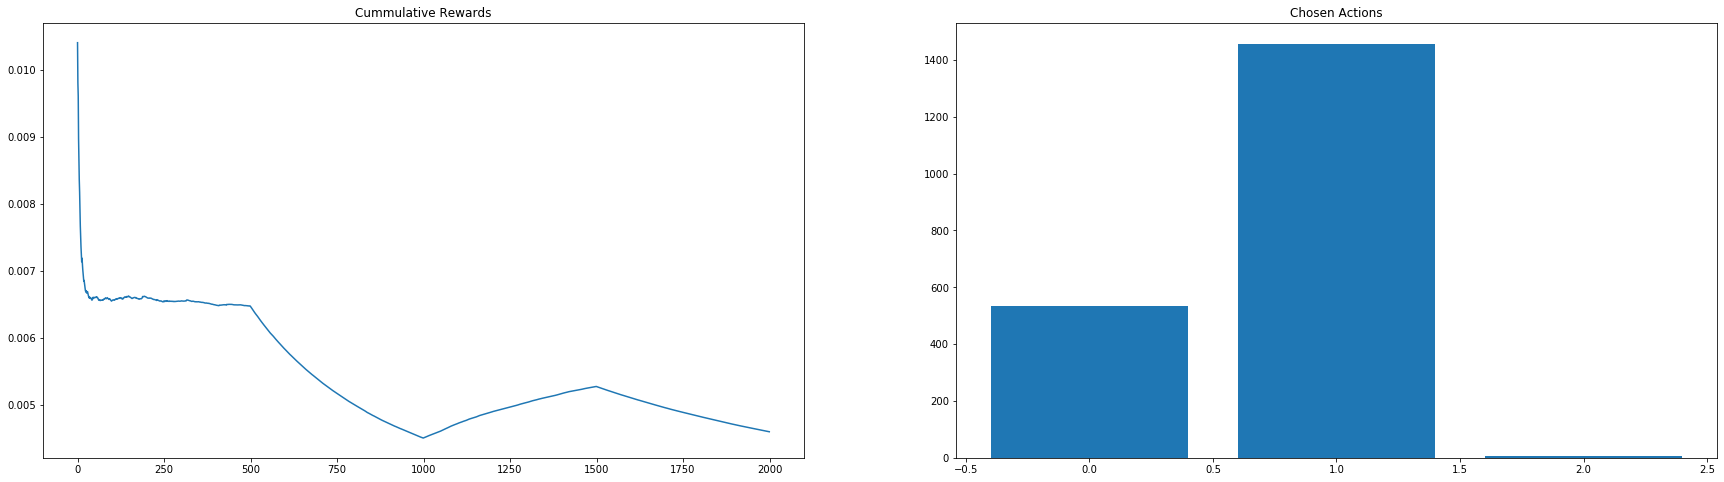

Total reward 9.1925


In [55]:
sample_mean_TS_stationary, sample_count_TS_stationary,rewards_TS_stationary,cum_rewards_TS_stationary,n_TS_stationary = list_iteration_results_TS_stationary
plot_history(rewards_TS_stationary,cum_rewards_TS_stationary, sample_count_TS_stationary, sample_mean_TS_stationary)
print("Total reward", np.round(total_reward_TS_stationary,4))

In [56]:
array_rewards = np.array(rewards_TS_stationary)
algo = rpt.Pelt(model="rbf").fit(array_rewards)
result = algo.predict(100)
result

[500, 1000, 1500, 2000]

498 0.2142996570762441
499 0.6351803897595449
998 0.5014152859713604
999 0.39281717562090024
1499 0.7519001451519853


C:\Users\iRacheva\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


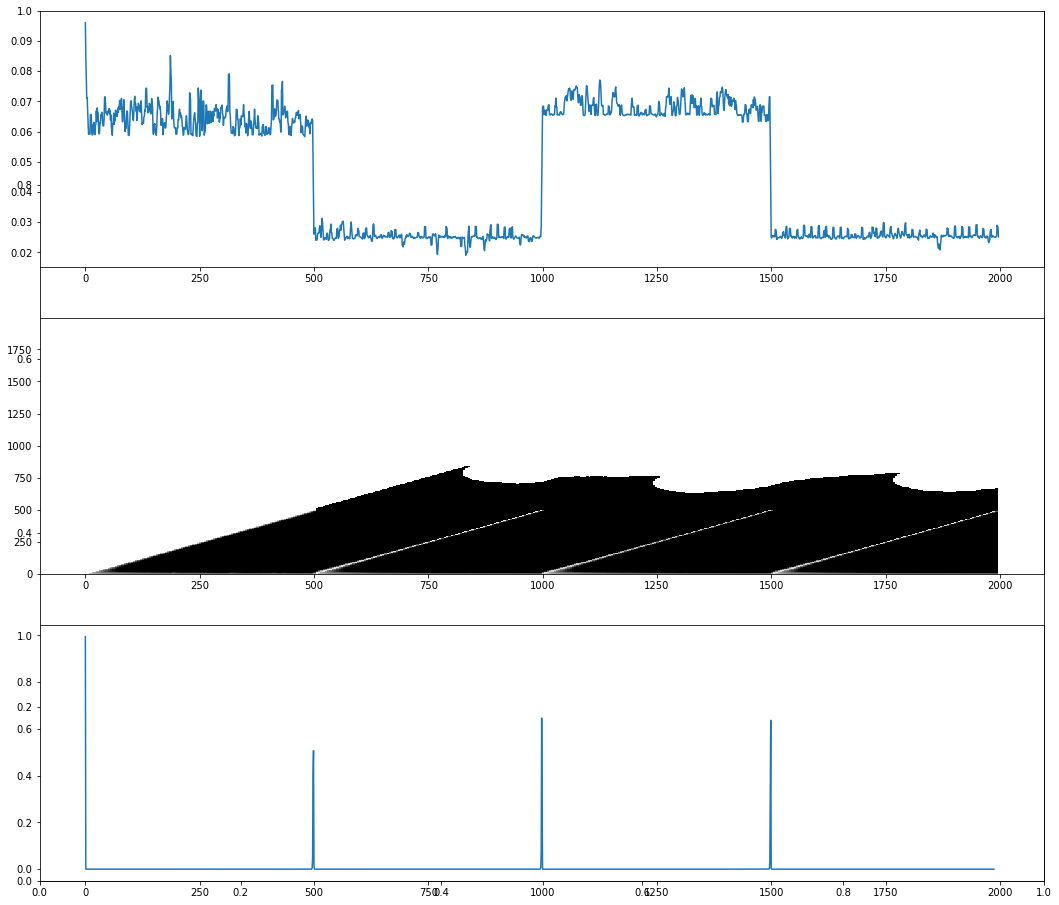

In [68]:
array_rewards_ma = moving_average(array_rewards, 3)*10
R, maxes = oncd.online_changepoint_detection(array_rewards_ma, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))
Nw=3
for i, elem in enumerate(R[Nw,Nw:-1]):
    if elem > 0.2 and i!=0:
        print(i,elem)
        
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(array_rewards_ma)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

### Online changepoint detection: Bayesian Online change detection algorithm (https://arxiv.org/abs/0710.3742, https://nbviewer.jupyter.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb)

In [74]:
def TS_obcp(list_distributions, n_samples, var_multiplier = 5):
    # initialize
    total_reward = 0
    num_choices = len(choices)
    sample_count = [0 for i in range(num_choices)]
    sample_rewards = [0 for i in range(num_choices)]
    sample_mean = [0.0 for i in range(num_choices)]
    sample_var = [0.0 for i in range(num_choices)]
    arm_rewards = {0: [], 1:[], 2:[]}
    rewards = []
    cum_rewards = []
    var_multiplier = var_multiplier
    list_iteration_results = []

    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        print("\n")
        print("Iteration:", n)
        theta = {}
        for i in range(len(choices)):
            if sample_count[i] >= 2:
                theta[i] = t.rvs(df=sample_count[i]-1,loc=sample_mean[i],scale=np.sqrt(sample_var[i]/sample_count[i])*var_multiplier)
                print(choices_names[i],"Theta", theta[i])

            else:
                print("Less than two values for",choices_names[i])
                theta[i] = uniform.rvs(loc=0, scale=1)
                print(choices_names[i],"Theta", theta[i])

        choice = np.argmin([theta[i] for i in range(len(choices))])
        alg = choices[choice]
        alg_name = choices_names[choice]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = ((time.perf_counter() - start_time))*(1)
        print("\n")
        print("Chosen algorithm is: ", alg_name, "with reward:", reward)
        arm_rewards[choice].append(reward)
        sample_count[choice] += 1
        sample_rewards[choice] += reward
        sample_mean[choice] = np.mean(arm_rewards[choice])
        sample_var[choice] = np.var(arm_rewards[choice]).astype('float64')
        print("Sample mean is: ", sample_mean[choice], "Sample variance is:", sample_var[choice])
        total_reward += reward
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))

        array_rewards = np.array(rewards)
        #print(array_rewards)   
        if(len(array_rewards)>4):
            array_rewards_ma = moving_average(array_rewards, 3)*1000
            R, maxes = oncd.online_changepoint_detection(array_rewards_ma, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))
            Nw=3
            #print("R",R)
            for i, elem in enumerate(R[Nw,Nw:-1]):
                if elem > 0.2 and i!=0:
                        print("RESTART EXPERIMENT AT ITERATION:", n)

                        list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
                        sample_count = [0 for i in range(num_choices)]
                        sample_rewards = [0 for i in range(num_choices)]
                        sample_mean = [0.0 for i in range(num_choices)]
                        sample_var = [0.0 for i in range(num_choices)]
                        arm_rewards = {0: [], 1:[], 2:[]}
                        rewards = []
                        cum_rewards = []
                        n_consecutive_list = []


    list_iteration_results.append([sample_mean, sample_count,rewards,cum_rewards,n])
    return list_iteration_results, total_reward

In [75]:
list_iteration_results_obcp, total_reward_obcp = TS_obcp(list_distributions=list_distributions, n_samples=n_samples)



Iteration: 0
Less than two values for quick_sort
quick_sort Theta 0.31537090677993607
Less than two values for merge_sort
merge_sort Theta 0.5136395057510844
Less than two values for heap_sort
heap_sort Theta 0.7204992795133516


Chosen algorithm is:  quick_sort with reward: 0.009403800000200135
Sample mean is:  0.009403800000200135 Sample variance is: 0.0


Iteration: 1
Less than two values for quick_sort
quick_sort Theta 0.7367356805592924
Less than two values for merge_sort
merge_sort Theta 0.1254692060884569
Less than two values for heap_sort
heap_sort Theta 0.46341885333714294


Chosen algorithm is:  merge_sort with reward: 0.0070602999999209715
Sample mean is:  0.0070602999999209715 Sample variance is: 0.0


Iteration: 2
Less than two values for quick_sort
quick_sort Theta 0.37108957876604454
Less than two values for merge_sort
merge_sort Theta 0.16020434437483178
Less than two values for heap_sort
heap_sort Theta 0.7054818873573165


Chosen algorithm is:  merge_sort with rewar

quick_sort Theta 0.005158740286933752
merge_sort Theta 0.006727198511056479
Less than two values for heap_sort
heap_sort Theta 0.41618151538775916


Chosen algorithm is:  quick_sort with reward: 0.007794900000135385
Sample mean is:  0.00705323749997433 Sample variance is: 1.0803351901002227e-06


Iteration: 32
quick_sort Theta 0.0097816493247002
merge_sort Theta 0.007452758147631555
Less than two values for heap_sort
heap_sort Theta 0.6006132603717337


Chosen algorithm is:  merge_sort with reward: 0.007849099999930331
Sample mean is:  0.007490029166660861 Sample variance is: 9.534999752729139e-07


Iteration: 33
quick_sort Theta 0.007992581022320434
merge_sort Theta 0.008556842154894162
Less than two values for heap_sort
heap_sort Theta 0.29946779092619125


Chosen algorithm is:  quick_sort with reward: 0.0074371000000610366
Sample mean is:  0.007095888888872853 Sample variance is: 9.748510745555382e-07


Iteration: 34
quick_sort Theta 0.00535722931024592
merge_sort Theta 0.0066965201



Iteration: 64
quick_sort Theta 0.006342493035899248
merge_sort Theta 0.007080720960811836
Less than two values for heap_sort
heap_sort Theta 0.560744670482982


Chosen algorithm is:  quick_sort with reward: 0.007204900000033376
Sample mean is:  0.006803003125000373 Sample variance is: 4.860084266110751e-07


Iteration: 65
quick_sort Theta 0.007119651432185021
merge_sort Theta 0.007738534902827348
Less than two values for heap_sort
heap_sort Theta 0.9694129127037827


Chosen algorithm is:  quick_sort with reward: 0.0071418000002267945
Sample mean is:  0.006813269696976931 Sample variance is: 4.7465377853674675e-07


Iteration: 66
quick_sort Theta 0.007188444404880453
merge_sort Theta 0.007478995993520164
Less than two values for heap_sort
heap_sort Theta 0.6233000876185685


Chosen algorithm is:  quick_sort with reward: 0.006472799999755807
Sample mean is:  0.0068032558823527805 Sample variance is: 4.640024972354523e-07


Iteration: 67
quick_sort Theta 0.006858578246230499
merge_sort 

Less than two values for heap_sort
heap_sort Theta 0.7083830801525955


Chosen algorithm is:  quick_sort with reward: 0.006825899999967078
Sample mean is:  0.006721550847464256 Sample variance is: 4.544566747970208e-07


Iteration: 97
quick_sort Theta 0.006912312446507449
merge_sort Theta 0.0068887583049760635
Less than two values for heap_sort
heap_sort Theta 0.48778985384970897


Chosen algorithm is:  merge_sort with reward: 0.007654300000012881
Sample mean is:  0.007473634210495412 Sample variance is: 8.217906821669345e-07


Iteration: 98
quick_sort Theta 0.006430426905033948
merge_sort Theta 0.007473465726688509
Less than two values for heap_sort
heap_sort Theta 0.7726592110562317


Chosen algorithm is:  quick_sort with reward: 0.006024899999829358
Sample mean is:  0.006709940000003674 Sample variance is: 4.54836291830158e-07


Iteration: 99
quick_sort Theta 0.006552505746421504
merge_sort Theta 0.009018581536121116
Less than two values for heap_sort
heap_sort Theta 0.5839204571115

Sample mean is:  0.007491455319123293 Sample variance is: 8.035119338428897e-07


Iteration: 127
quick_sort Theta 0.006155112207155098
merge_sort Theta 0.007399606577820989
Less than two values for heap_sort
heap_sort Theta 0.451202748301345


Chosen algorithm is:  quick_sort with reward: 0.006305500000053144
Sample mean is:  0.006703243749979037 Sample variance is: 4.6250095502070814e-07


Iteration: 128
quick_sort Theta 0.007238954284404181
merge_sort Theta 0.007617223163149786
Less than two values for heap_sort
heap_sort Theta 0.6659532966038464


Chosen algorithm is:  quick_sort with reward: 0.005906400000185386
Sample mean is:  0.0066934061728210915 Sample variance is: 4.6453330063420305e-07


Iteration: 129
quick_sort Theta 0.007546718062250537
merge_sort Theta 0.007158111113073518
Less than two values for heap_sort
heap_sort Theta 0.7299536917816349


Chosen algorithm is:  merge_sort with reward: 0.007894699999724253
Sample mean is:  0.007499856249969146 Sample variance is: 7.90



Iteration: 154
quick_sort Theta 0.006571283512392931
merge_sort Theta 0.0075155750191182435
Less than two values for heap_sort
heap_sort Theta 0.6853958877120235


Chosen algorithm is:  quick_sort with reward: 0.007383600000139268
Sample mean is:  0.006666491428547618 Sample variance is: 4.158511486425716e-07


Iteration: 155
quick_sort Theta 0.006297747274153255
merge_sort Theta 0.007768725519342679
Less than two values for heap_sort
heap_sort Theta 0.3319327241800831


Chosen algorithm is:  quick_sort with reward: 0.006326500000341184
Sample mean is:  0.006663283962243784 Sample variance is: 4.1300824780824827e-07


Iteration: 156
quick_sort Theta 0.005998624955170355
merge_sort Theta 0.007569591822079002
Less than two values for heap_sort
heap_sort Theta 0.7416078693601582


Chosen algorithm is:  quick_sort with reward: 0.006049800000255345
Sample mean is:  0.0066575504672719285 Sample variance is: 4.1263289188859777e-07


Iteration: 157
quick_sort Theta 0.006090313392957607
merge



Iteration: 183
quick_sort Theta 0.00677445768752283
merge_sort Theta 0.006917076125372043
Less than two values for heap_sort
heap_sort Theta 0.561114091070878


Chosen algorithm is:  quick_sort with reward: 0.007096400000136782
Sample mean is:  0.006684599224792847 Sample variance is: 4.5025013437610434e-07


Iteration: 184
quick_sort Theta 0.006350413215617504
merge_sort Theta 0.0076533146135684006
Less than two values for heap_sort
heap_sort Theta 0.8224076434059743


Chosen algorithm is:  quick_sort with reward: 0.005985100000089005
Sample mean is:  0.006679218461525894 Sample variance is: 4.505215589241937e-07


Iteration: 185
quick_sort Theta 0.0068528198049819505
merge_sort Theta 0.006974332686180794
Less than two values for heap_sort
heap_sort Theta 0.737733597572325


Chosen algorithm is:  quick_sort with reward: 0.006191299999954936
Sample mean is:  0.006675493893116956 Sample variance is: 4.4888587633281567e-07


Iteration: 186
quick_sort Theta 0.0071698584219489
merge_sort



Chosen algorithm is:  quick_sort with reward: 0.008319199999732518
Sample mean is:  0.006671437583863369 Sample variance is: 4.544080328539509e-07


Iteration: 211
quick_sort Theta 0.005817385349629753
merge_sort Theta 0.007814247962917575
heap_sort Theta 0.009600223010444324


Chosen algorithm is:  quick_sort with reward: 0.007049399999687012
Sample mean is:  0.0066739573333021935 Sample variance is: 4.523246674161918e-07


Iteration: 212
quick_sort Theta 0.006712666045997244
merge_sort Theta 0.007525674578651069
heap_sort Theta 0.01140592347521203


Chosen algorithm is:  quick_sort with reward: 0.007024699999874429
Sample mean is:  0.006676280132418565 Sample variance is: 4.50138449177662e-07


Iteration: 213
quick_sort Theta 0.006596101406467413
merge_sort Theta 0.0063890511683062316
heap_sort Theta 0.01996201701052348


Chosen algorithm is:  merge_sort with reward: 0.006863100000373379
Sample mean is:  0.007445465573762137 Sample variance is: 6.734309028120158e-07


Iteration: 21



Iteration: 240
quick_sort Theta 0.006347095849092935
merge_sort Theta 0.007604519199157266
heap_sort Theta 0.010912156694434594


Chosen algorithm is:  quick_sort with reward: 0.006806799999594659
Sample mean is:  0.006654979660986311 Sample variance is: 4.2040881996207675e-07


Iteration: 241
quick_sort Theta 0.006764695999280542
merge_sort Theta 0.006436398449544061
heap_sort Theta 0.012189827654299223


Chosen algorithm is:  merge_sort with reward: 0.0078120000002854795
Sample mean is:  0.0074536682539632785 Sample variance is: 6.544756198495809e-07


Iteration: 242
quick_sort Theta 0.0063537964641632895
merge_sort Theta 0.00822846021369915
heap_sort Theta 0.009502813190594981


Chosen algorithm is:  quick_sort with reward: 0.005995299999995041
Sample mean is:  0.006651273595475124 Sample variance is: 4.2047805377737703e-07


Iteration: 243
quick_sort Theta 0.007019450622717229
merge_sort Theta 0.007025263850876952
heap_sort Theta 0.008942752271643924


Chosen algorithm is:  quick



Iteration: 270
quick_sort Theta 0.006486327083768684
merge_sort Theta 0.008073734238299716
heap_sort Theta 0.010631381286623132


Chosen algorithm is:  quick_sort with reward: 0.006393799999841576
Sample mean is:  0.0066463806930358365 Sample variance is: 4.3300510535686394e-07


Iteration: 271
quick_sort Theta 0.0069761888600788965
merge_sort Theta 0.0077703424238072605
heap_sort Theta 0.009718241901842818


Chosen algorithm is:  quick_sort with reward: 0.006498799999917537
Sample mean is:  0.006645653694547569 Sample variance is: 4.309788376952069e-07


Iteration: 272
quick_sort Theta 0.00635207244930567
merge_sort Theta 0.007277354806865655
heap_sort Theta 0.008991471239970196


Chosen algorithm is:  quick_sort with reward: 0.006070200000067416
Sample mean is:  0.006642832843104039 Sample variance is: 4.3048150851584856e-07


Iteration: 273
quick_sort Theta 0.006554437398617847
merge_sort Theta 0.007847056732424178
heap_sort Theta 0.01232563830481636


Chosen algorithm is:  quick_



Iteration: 300
quick_sort Theta 0.006476307440466122
merge_sort Theta 0.0068974510694162485
heap_sort Theta 0.009938789022245426


Chosen algorithm is:  quick_sort with reward: 0.006512500000098953
Sample mean is:  0.006630238528113063 Sample variance is: 4.0488335244161925e-07


Iteration: 301
quick_sort Theta 0.006145079500115832
merge_sort Theta 0.007226209603428182
heap_sort Theta 0.0099010524324014


Chosen algorithm is:  quick_sort with reward: 0.00602019999996628
Sample mean is:  0.006627609051698637 Sample variance is: 4.047353333530857e-07


Iteration: 302
quick_sort Theta 0.006536071102123772
merge_sort Theta 0.007373695466449938
heap_sort Theta 0.009077042607422012


Chosen algorithm is:  quick_sort with reward: 0.006066699999792036
Sample mean is:  0.006625201716711914 Sample variance is: 4.0434277255983534e-07


Iteration: 303
quick_sort Theta 0.006537118887514501
merge_sort Theta 0.007296580452118703
heap_sort Theta 0.009354870457551703


Chosen algorithm is:  quick_sor



Iteration: 330
quick_sort Theta 0.006299349926650953
merge_sort Theta 0.00722586053706845
heap_sort Theta 0.010540852368147648


Chosen algorithm is:  quick_sort with reward: 0.005937200000062148
Sample mean is:  0.0066218189188977815 Sample variance is: 4.163231570842404e-07


Iteration: 331
quick_sort Theta 0.006681364302359074
merge_sort Theta 0.008136340312323435
heap_sort Theta 0.01029509913619563


Chosen algorithm is:  quick_sort with reward: 0.0065506000000823406
Sample mean is:  0.006621544999979261 Sample variance is: 4.147413473500241e-07


Iteration: 332
quick_sort Theta 0.006846475218325577
merge_sort Theta 0.006917497456793743
heap_sort Theta 0.00911764511502578


Chosen algorithm is:  quick_sort with reward: 0.008662899999762885
Sample mean is:  0.006629366283503336 Sample variance is: 4.290571437928019e-07


Iteration: 333
quick_sort Theta 0.006726769185392625
merge_sort Theta 0.007718220061996342
heap_sort Theta 0.010650807406647577


Chosen algorithm is:  quick_sort



Chosen algorithm is:  quick_sort with reward: 0.007506700000249111
Sample mean is:  0.0066601342657132126 Sample variance is: 4.767631410831833e-07


Iteration: 361
quick_sort Theta 0.0065714511586263385
merge_sort Theta 0.007631239341556347
heap_sort Theta 0.008554871527513835


Chosen algorithm is:  quick_sort with reward: 0.00694519999979093
Sample mean is:  0.006661127526110696 Sample variance is: 4.7538410340777465e-07


Iteration: 362
quick_sort Theta 0.006526852782358325
merge_sort Theta 0.00758834152462998
heap_sort Theta 0.008816940132558593


Chosen algorithm is:  quick_sort with reward: 0.006571500000063679
Sample mean is:  0.006660816319423033 Sample variance is: 4.737612599957331e-07


Iteration: 363
quick_sort Theta 0.006578504481581115
merge_sort Theta 0.007503749748705333
heap_sort Theta 0.009499069850209863


Chosen algorithm is:  quick_sort with reward: 0.0059234999998807325
Sample mean is:  0.006658265051881364 Sample variance is: 4.739965299053306e-07


Iteration:



Iteration: 390
quick_sort Theta 0.006543849088201557
merge_sort Theta 0.007960600293242153
heap_sort Theta 0.009918864979531527


Chosen algorithm is:  quick_sort with reward: 0.006480300000021089
Sample mean is:  0.006667516293909954 Sample variance is: 4.6928068496352827e-07


Iteration: 391
quick_sort Theta 0.006754963966374121
merge_sort Theta 0.007193786837443756
heap_sort Theta 0.009190017048895638


Chosen algorithm is:  quick_sort with reward: 0.006276999999954569
Sample mean is:  0.006666272611445128 Sample variance is: 4.6827029201007e-07


Iteration: 392
quick_sort Theta 0.006669008756270294
merge_sort Theta 0.00703595245596768
heap_sort Theta 0.008779298387742409


Chosen algorithm is:  quick_sort with reward: 0.007017500000074506
Sample mean is:  0.006667387619028078 Sample variance is: 4.671740976142341e-07


Iteration: 393
quick_sort Theta 0.006485888913949695
merge_sort Theta 0.007430110466200486
heap_sort Theta 0.009670015586964818


Chosen algorithm is:  quick_sort 



Iteration: 420
quick_sort Theta 0.006384307119262395
merge_sort Theta 0.007423061324192029
heap_sort Theta 0.00980977340258115


Chosen algorithm is:  quick_sort with reward: 0.007222300000194082
Sample mean is:  0.006671144314855248 Sample variance is: 4.4456983631139753e-07


Iteration: 421
quick_sort Theta 0.006648719848609451
merge_sort Theta 0.007163545796017611
heap_sort Theta 0.010233385819195298


Chosen algorithm is:  quick_sort with reward: 0.007014199999957782
Sample mean is:  0.006672141569753802 Sample variance is: 4.4361860158118626e-07


Iteration: 422
quick_sort Theta 0.006677092932646493
merge_sort Theta 0.008303779136483974
heap_sort Theta 0.010605651142656984


Chosen algorithm is:  quick_sort with reward: 0.006116600000041217
Sample mean is:  0.006670531304334345 Sample variance is: 4.432247269861682e-07


Iteration: 423
quick_sort Theta 0.006418448399094366
merge_sort Theta 0.007499864289273357
heap_sort Theta 0.008934492216954765


Chosen algorithm is:  quick_so



Iteration: 450
quick_sort Theta 0.006724618295473349
merge_sort Theta 0.00802571389654506
heap_sort Theta 0.00985258726064636


Chosen algorithm is:  quick_sort with reward: 0.00622720000001209
Sample mean is:  0.006651915363869742 Sample variance is: 4.273547170669519e-07


Iteration: 451
quick_sort Theta 0.006949909044868536
merge_sort Theta 0.007139635969408489
heap_sort Theta 0.009710047661211405


Chosen algorithm is:  quick_sort with reward: 0.006944299999759096
Sample mean is:  0.006652701344073746 Sample variance is: 4.2643510483496646e-07


Iteration: 452
quick_sort Theta 0.00675459796004679
merge_sort Theta 0.006877466696382804
heap_sort Theta 0.009313812392401612


Chosen algorithm is:  quick_sort with reward: 0.006545299999743293
Sample mean is:  0.006652413404812807 Sample variance is: 4.253226893359459e-07


Iteration: 453
quick_sort Theta 0.0067903885392229585
merge_sort Theta 0.007626599769263368
heap_sort Theta 0.010446325103171493


Chosen algorithm is:  quick_sort 



Iteration: 480
quick_sort Theta 0.006607765090909212
merge_sort Theta 0.006957414772455992
heap_sort Theta 0.009827390344144019


Chosen algorithm is:  quick_sort with reward: 0.006227100000160135
Sample mean is:  0.006636715789459812 Sample variance is: 4.1226673403448825e-07


Iteration: 481
quick_sort Theta 0.0065382757570997775
merge_sort Theta 0.0074165272395753865
heap_sort Theta 0.010186813553065966


Chosen algorithm is:  quick_sort with reward: 0.007090099999913946
Sample mean is:  0.006637849249985947 Sample variance is: 4.1174867557236047e-07


Iteration: 482
quick_sort Theta 0.006768026897183639
merge_sort Theta 0.008066751565738203
heap_sort Theta 0.010477569845324563


Chosen algorithm is:  quick_sort with reward: 0.007082399999944755
Sample mean is:  0.0066389578553474405 Sample variance is: 4.112134732341353e-07


Iteration: 483
quick_sort Theta 0.006617611760311714
merge_sort Theta 0.007800317509566242
heap_sort Theta 0.010093522513591763


Chosen algorithm is:  quic

Sample mean is:  0.0031701833333575755 Sample variance is: 1.7560001413481496e-08


Iteration: 517
Less than two values for quick_sort
quick_sort Theta 0.8021732064006698
merge_sort Theta 0.0034155027066996644
Less than two values for heap_sort
heap_sort Theta 0.29526878849230087


Chosen algorithm is:  merge_sort with reward: 0.0033760999999685737
Sample mean is:  0.0031860230769430366 Sample variance is: 1.922000179622091e-08


Iteration: 518
Less than two values for quick_sort
quick_sort Theta 0.08540596776625142
merge_sort Theta 0.003439894605234024
Less than two values for heap_sort
heap_sort Theta 0.061418069765742156


Chosen algorithm is:  merge_sort with reward: 0.003181200000199169
Sample mean is:  0.0031856785714613318 Sample variance is: 1.7848687417412297e-08


Iteration: 519
Less than two values for quick_sort
quick_sort Theta 0.22389210491075417
merge_sort Theta 0.003093815380528379
Less than two values for heap_sort
heap_sort Theta 0.5212007943458337


Chosen algorithm 



Chosen algorithm is:  merge_sort with reward: 0.004110299999865674
Sample mean is:  0.0030778325581512795 Sample variance is: 1.4317900313802007e-07


Iteration: 548
Less than two values for quick_sort
quick_sort Theta 0.9144919266902887
merge_sort Theta 0.0032960723100178757
Less than two values for heap_sort
heap_sort Theta 0.9794943595126644


Chosen algorithm is:  merge_sort with reward: 0.0019250999998803309
Sample mean is:  0.003051634090917849 Sample variance is: 1.6943840135627229e-07


Iteration: 549
Less than two values for quick_sort
quick_sort Theta 0.009156078919665855
merge_sort Theta 0.0025974520295607463
Less than two values for heap_sort
heap_sort Theta 0.6315072602039191


Chosen algorithm is:  merge_sort with reward: 0.0021719000001212407
Sample mean is:  0.0030320844444557023 Sample variance is: 1.8248940532733207e-07


Iteration: 550
Less than two values for quick_sort
quick_sort Theta 0.9367125240159497
merge_sort Theta 0.0029698869595016866
Less than two values



Iteration: 577
Less than two values for quick_sort
quick_sort Theta 0.15569783034487938
merge_sort Theta 0.0027450749238525506
Less than two values for heap_sort
heap_sort Theta 0.1175621635964692


Chosen algorithm is:  merge_sort with reward: 0.002975200000037148
Sample mean is:  0.0030844863013791764 Sample variance is: 1.5363044173637798e-07


Iteration: 578
Less than two values for quick_sort
quick_sort Theta 0.0752797236479974
merge_sort Theta 0.0033081755949977455
Less than two values for heap_sort
heap_sort Theta 0.5836423300226266


Chosen algorithm is:  merge_sort with reward: 0.0021013000000493776
Sample mean is:  0.0030712000000098546 Sample variance is: 1.6444073838346628e-07


Iteration: 579
Less than two values for quick_sort
quick_sort Theta 0.6138493356008428
merge_sort Theta 0.0030134018895392302
Less than two values for heap_sort
heap_sort Theta 0.7049582673325117


Chosen algorithm is:  merge_sort with reward: 0.0031543000000056054
Sample mean is:  0.0030723080000



Iteration: 602
Less than two values for quick_sort
quick_sort Theta 0.5933908623467278
merge_sort Theta 0.0032857737671639193
Less than two values for heap_sort
heap_sort Theta 0.8363695847696851


Chosen algorithm is:  merge_sort with reward: 0.002468700000008539
Sample mean is:  0.0030604418367351617 Sample variance is: 2.02020753039196e-07


Iteration: 603
Less than two values for quick_sort
quick_sort Theta 0.2772586100184927
merge_sort Theta 0.0032961885741323044
Less than two values for heap_sort
heap_sort Theta 0.2592227744702251


Chosen algorithm is:  merge_sort with reward: 0.0032682999999451567
Sample mean is:  0.0030625414141413235 Sample variance is: 2.0041214545001093e-07


Iteration: 604
Less than two values for quick_sort
quick_sort Theta 0.9823030391845493
merge_sort Theta 0.0029640018971183995
Less than two values for heap_sort
heap_sort Theta 0.4953095039827049


Chosen algorithm is:  merge_sort with reward: 0.0031754999999975553
Sample mean is:  0.0030636709999998



Chosen algorithm is:  heap_sort with reward: 0.006946399999833375
Sample mean is:  0.006183899999996356 Sample variance is: 5.814062497514533e-07


Iteration: 630
Less than two values for quick_sort
quick_sort Theta 0.5244648776564401
merge_sort Theta 0.0028396780425969377
heap_sort Theta 0.021901213418119316


Chosen algorithm is:  merge_sort with reward: 0.0033360000002176093
Sample mean is:  0.003048420161290309 Sample variance is: 2.1330589919179928e-07


Iteration: 631
Less than two values for quick_sort
quick_sort Theta 0.8392455016504174
merge_sort Theta 0.0031578874363131816
heap_sort Theta -0.004050074478572887


Chosen algorithm is:  heap_sort with reward: 0.005449100000078033
Sample mean is:  0.0059389666666902485 Sample variance is: 5.075888420298505e-07


Iteration: 632
Less than two values for quick_sort
quick_sort Theta 0.6452567073489222
merge_sort Theta 0.0030859460998130753
heap_sort Theta -0.0034935288328235403


Chosen algorithm is:  heap_sort with reward: 0.00506



Chosen algorithm is:  merge_sort with reward: 0.004136799999741925
Sample mean is:  0.0029350041666778757 Sample variance is: 3.8392498279744936e-07


Iteration: 658
Less than two values for quick_sort
quick_sort Theta 0.32259420464502153
merge_sort Theta 0.0030556463350459016
Less than two values for heap_sort
heap_sort Theta 0.5578960584663494


Chosen algorithm is:  merge_sort with reward: 0.003019100000074104
Sample mean is:  0.0029383680000137245 Sample variance is: 3.6883955247862425e-07


Iteration: 659
Less than two values for quick_sort
quick_sort Theta 0.9388434099311902
merge_sort Theta 0.0030585926357024505
Less than two values for heap_sort
heap_sort Theta 0.7573309067132856


Chosen algorithm is:  merge_sort with reward: 0.00318829999969239
Sample mean is:  0.002947980769232135 Sample variance is: 3.5696354914599137e-07


Iteration: 660
Less than two values for quick_sort
quick_sort Theta 0.9929639416499388
merge_sort Theta 0.00206739051690511
Less than two values for h

merge_sort Theta 0.0027753895407709897
Less than two values for heap_sort
heap_sort Theta 0.21237695289827363


Chosen algorithm is:  merge_sort with reward: 0.0034408000001349137
Sample mean is:  0.003021611764726164 Sample variance is: 2.655820170604501e-07


Iteration: 686
Less than two values for quick_sort
quick_sort Theta 0.5851121422422243
merge_sort Theta 0.002232559628847051
Less than two values for heap_sort
heap_sort Theta 0.7270946853869913


Chosen algorithm is:  merge_sort with reward: 0.0029027000000496628
Sample mean is:  0.003019325000020847 Sample variance is: 2.6074136451221005e-07


Iteration: 687
Less than two values for quick_sort
quick_sort Theta 0.5735178789291596
merge_sort Theta 0.002299324522179259
Less than two values for heap_sort
heap_sort Theta 0.1238612870406266


Chosen algorithm is:  merge_sort with reward: 0.0024834000000737433
Sample mean is:  0.0030092132075690147 Sample variance is: 2.6113863014781156e-07


Iteration: 688
Less than two values for q



Iteration: 715
Less than two values for quick_sort
quick_sort Theta 0.4620241612216698
merge_sort Theta 0.0026449601671638735
Less than two values for heap_sort
heap_sort Theta 0.4147001589437157


Chosen algorithm is:  merge_sort with reward: 0.0022162000000207627
Sample mean is:  0.003044286250019468 Sample variance is: 2.3485405240634428e-07


Iteration: 716
Less than two values for quick_sort
quick_sort Theta 0.13643326559037428
merge_sort Theta 0.0023376655109774987
Less than two values for heap_sort
heap_sort Theta 0.19658223113984097


Chosen algorithm is:  merge_sort with reward: 0.0024514000001545355
Sample mean is:  0.003036966666687802 Sample variance is: 2.36240723672523e-07


Iteration: 717
Less than two values for quick_sort
quick_sort Theta 0.7126877971700297
merge_sort Theta 0.003180953156111341
Less than two values for heap_sort
heap_sort Theta 0.7754175159205353


Chosen algorithm is:  merge_sort with reward: 0.0027411999999458203
Sample mean is:  0.0030333597561177

Less than two values for quick_sort
quick_sort Theta 0.6807906456966798
merge_sort Theta 0.003223921386662758
Less than two values for heap_sort
heap_sort Theta 0.27778353338879747


Chosen algorithm is:  merge_sort with reward: 0.0030989000001682143
Sample mean is:  0.0030388923077085705 Sample variance is: 2.3274220992014848e-07


Iteration: 740
Less than two values for quick_sort
quick_sort Theta 0.8583352904751732
merge_sort Theta 0.0029233871145936253
Less than two values for heap_sort
heap_sort Theta 0.2931891653092559


Chosen algorithm is:  merge_sort with reward: 0.002567400000316411
Sample mean is:  0.003034401904781026 Sample variance is: 2.3262264416369524e-07


Iteration: 741
Less than two values for quick_sort
quick_sort Theta 0.31563413627624115
merge_sort Theta 0.0031489193798915744
Less than two values for heap_sort
heap_sort Theta 0.06932085953939182


Chosen algorithm is:  merge_sort with reward: 0.003220699999928911
Sample mean is:  0.0030361594339805343 Sample vari



Chosen algorithm is:  merge_sort with reward: 0.003890399999818328
Sample mean is:  0.0030447961832252277 Sample variance is: 2.341624565353236e-07


Iteration: 767
Less than two values for quick_sort
quick_sort Theta 0.7419992485057114
merge_sort Theta 0.0032537972798128297
Less than two values for heap_sort
heap_sort Theta 0.35304227320807324


Chosen algorithm is:  merge_sort with reward: 0.003176000000166823
Sample mean is:  0.0030457901515353915 Sample variance is: 2.3251792299447894e-07


Iteration: 768
Less than two values for quick_sort
quick_sort Theta 0.22102927698406294
merge_sort Theta 0.0030680190284702075
Less than two values for heap_sort
heap_sort Theta 0.09423315091670914


Chosen algorithm is:  merge_sort with reward: 0.002491699999609409
Sample mean is:  0.003041624060167527 Sample variance is: 2.3306070181604231e-07


Iteration: 769
Less than two values for quick_sort
quick_sort Theta 0.4953291651588305
merge_sort Theta 0.003422334385887919
Less than two values fo



Chosen algorithm is:  merge_sort with reward: 0.004360899999937828
Sample mean is:  0.003039368987355708 Sample variance is: 2.666530844036453e-07


Iteration: 794
Less than two values for quick_sort
quick_sort Theta 0.6040932883097248
merge_sort Theta 0.003285488498102644
Less than two values for heap_sort
heap_sort Theta 0.6904051762978696


Chosen algorithm is:  merge_sort with reward: 0.003135999999813066
Sample mean is:  0.003039976729572421 Sample variance is: 2.650343783748351e-07


Iteration: 795
Less than two values for quick_sort
quick_sort Theta 0.9910482010665547
merge_sort Theta 0.0032191000439327935
Less than two values for heap_sort
heap_sort Theta 0.49214506997742535


Chosen algorithm is:  merge_sort with reward: 0.0030501000001095235
Sample mean is:  0.0030400400000132775 Sample variance is: 2.6337855001063344e-07


Iteration: 796
Less than two values for quick_sort
quick_sort Theta 0.015396740127508135
merge_sort Theta 0.0029602598129071698
Less than two values for



Chosen algorithm is:  merge_sort with reward: 0.004298999999718944
Sample mean is:  0.00304679125683883 Sample variance is: 2.7783735651911854e-07


Iteration: 819
Less than two values for quick_sort
quick_sort Theta 0.33036035076353665
merge_sort Theta 0.002839743565250522
Less than two values for heap_sort
heap_sort Theta 0.3861453094472923


Chosen algorithm is:  merge_sort with reward: 0.0019517000000632834
Sample mean is:  0.0030408396739215714 Sample variance is: 2.828094759633058e-07


Iteration: 820
Less than two values for quick_sort
quick_sort Theta 0.7684330319902192
merge_sort Theta 0.003156608437813149
Less than two values for heap_sort
heap_sort Theta 0.28270317887004814


Chosen algorithm is:  merge_sort with reward: 0.0022575999996661267
Sample mean is:  0.003036605945952623 Sample variance is: 2.8457887535600416e-07


Iteration: 821
Less than two values for quick_sort
quick_sort Theta 0.17316969974452756
merge_sort Theta 0.0032730148511133468
Less than two values for



Chosen algorithm is:  quick_sort with reward: 0.004490999999688938
Sample mean is:  0.003234528571413518 Sample variance is: 4.95943216141028e-07


Iteration: 846
quick_sort Theta 0.00489796474060788
merge_sort Theta 0.003041122318430274
Less than two values for heap_sort
heap_sort Theta 0.7708118078462413


Chosen algorithm is:  merge_sort with reward: 0.002979200000027049
Sample mean is:  0.003017607804887542 Sample variance is: 2.784112233414168e-07


Iteration: 847
quick_sort Theta 0.0010758586561132352
merge_sort Theta 0.002938646538925318
Less than two values for heap_sort
heap_sort Theta 0.697386417774156


Chosen algorithm is:  quick_sort with reward: 0.0034629000001586974
Sample mean is:  0.0032630750000066655 Sample variance is: 4.39654604221365e-07


Iteration: 848
quick_sort Theta 0.0017487371499266848
merge_sort Theta 0.003053633735145982
Less than two values for heap_sort
heap_sort Theta 0.8548544309814913


Chosen algorithm is:  quick_sort with reward: 0.00451709999970

Less than two values for heap_sort
heap_sort Theta 0.08630695068264171


Chosen algorithm is:  merge_sort with reward: 0.0035123000002386107
Sample mean is:  0.0030253701834956474 Sample variance is: 2.9707733602690646e-07


Iteration: 874
quick_sort Theta 0.0034690129775774388
merge_sort Theta 0.002850289829127672
Less than two values for heap_sort
heap_sort Theta 0.015674109466720876


Chosen algorithm is:  merge_sort with reward: 0.0030072999998083105
Sample mean is:  0.0030252876712413674 Sample variance is: 2.9572230271412103e-07


Iteration: 875
quick_sort Theta 0.001264930558378783
merge_sort Theta 0.002972583261348873
Less than two values for heap_sort
heap_sort Theta 0.9425988392168099


Chosen algorithm is:  quick_sort with reward: 0.0028392999997777224
Sample mean is:  0.003245740909009824 Sample variance is: 5.749726177668011e-07


Iteration: 876
quick_sort Theta 0.003589771396823083
merge_sort Theta 0.003217827923713011
Less than two values for heap_sort
heap_sort Theta 0.



Iteration: 900
quick_sort Theta 0.0034217048608107528
merge_sort Theta 0.0029592167452736724
Less than two values for heap_sort
heap_sort Theta 0.5401401915333468


Chosen algorithm is:  merge_sort with reward: 0.00243159999990894
Sample mean is:  0.0030036540425615074 Sample variance is: 2.998513673256471e-07


Iteration: 901
quick_sort Theta 0.0036260202153184937
merge_sort Theta 0.0028878260964643188
Less than two values for heap_sort
heap_sort Theta 0.3019809440855318


Chosen algorithm is:  merge_sort with reward: 0.0029288000000633474
Sample mean is:  0.003003336864415329 Sample variance is: 2.986044521488938e-07


Iteration: 902
quick_sort Theta 0.0035070661687656643
merge_sort Theta 0.0033567653091953202
Less than two values for heap_sort
heap_sort Theta 0.5524360177586702


Chosen algorithm is:  merge_sort with reward: 0.0029862999999750173
Sample mean is:  0.0030032649789113615 Sample variance is: 2.973457372877018e-07


Iteration: 903
quick_sort Theta 0.003025578151891545




Iteration: 927
quick_sort Theta 0.0034246190326976786
merge_sort Theta 0.003167941427242474
Less than two values for heap_sort
heap_sort Theta 0.512837688896798


Chosen algorithm is:  merge_sort with reward: 0.0024677999999767053
Sample mean is:  0.002991068110238453 Sample variance is: 2.9086069649752517e-07


Iteration: 928
quick_sort Theta 0.003490645311490742
merge_sort Theta 0.0032230691605663387
Less than two values for heap_sort
heap_sort Theta 0.6295954314032856


Chosen algorithm is:  merge_sort with reward: 0.0030738999998902727
Sample mean is:  0.0029913929411782636 Sample variance is: 2.897468671606044e-07


Iteration: 929
quick_sort Theta 0.0031933341334351834
merge_sort Theta 0.0026607224936683266
Less than two values for heap_sort
heap_sort Theta 0.5896556346580086


Chosen algorithm is:  merge_sort with reward: 0.0026226999998471
Sample mean is:  0.002989952734376189 Sample variance is: 2.891439633471077e-07


Iteration: 930
quick_sort Theta 0.0029776112682211395
mer



Iteration: 956
quick_sort Theta 0.0033708053964001997
merge_sort Theta 0.002859847938941642
Less than two values for heap_sort
heap_sort Theta 0.12275014813659191


Chosen algorithm is:  merge_sort with reward: 0.0031890000000203145
Sample mean is:  0.0029926450549462792 Sample variance is: 2.790015947802465e-07


Iteration: 957
quick_sort Theta 0.0036040898102708625
merge_sort Theta 0.003058807110897492
Less than two values for heap_sort
heap_sort Theta 0.7014661254417537


Chosen algorithm is:  merge_sort with reward: 0.0020617999998648884
Sample mean is:  0.0029892478102197047 Sample variance is: 2.811341079675991e-07


Iteration: 958
quick_sort Theta 0.0030620361090602675
merge_sort Theta 0.0028194330801893756
Less than two values for heap_sort
heap_sort Theta 0.12049917742147598


Chosen algorithm is:  merge_sort with reward: 0.0041843999997581705
Sample mean is:  0.0029935938181816627 Sample variance is: 2.852870552667246e-07


Iteration: 959
quick_sort Theta 0.0033799245902213



Chosen algorithm is:  merge_sort with reward: 0.0038624000003437686
Sample mean is:  0.002990907586210032 Sample variance is: 2.801987722146184e-07


Iteration: 984
quick_sort Theta 0.0032403684833271617
merge_sort Theta 0.0030802353565711846
Less than two values for heap_sort
heap_sort Theta 0.1974657678853068


Chosen algorithm is:  merge_sort with reward: 0.0030003000001670443
Sample mean is:  0.002990939862546654 Sample variance is: 2.792361919468266e-07


Iteration: 985
quick_sort Theta 0.0029504056689428327
merge_sort Theta 0.0030575937264141055
Less than two values for heap_sort
heap_sort Theta 0.5706852310689476


Chosen algorithm is:  quick_sort with reward: 0.003951199999846722
Sample mean is:  0.003301091666632298 Sample variance is: 4.0630235873036947e-07


Iteration: 986
quick_sort Theta 0.0031618207877882284
merge_sort Theta 0.0031369999850504884
Less than two values for heap_sort
heap_sort Theta 0.5877159366502083


Chosen algorithm is:  merge_sort with reward: 0.00286



Chosen algorithm is:  quick_sort with reward: 0.008302799999910349
Sample mean is:  0.0069994499999666004 Sample variance is: 6.545359592453675e-07


Iteration: 1010
quick_sort Theta 0.007904461842887858
Less than two values for merge_sort
merge_sort Theta 0.0024545829500872696
Less than two values for heap_sort
heap_sort Theta 0.734411499409995


Chosen algorithm is:  merge_sort with reward: 0.0074683000002551125
Sample mean is:  0.0074683000002551125 Sample variance is: 0.0


Iteration: 1011
quick_sort Theta 0.007933433377567523
Less than two values for merge_sort
merge_sort Theta 0.9716980522145555
Less than two values for heap_sort
heap_sort Theta 0.9682722516882535


Chosen algorithm is:  quick_sort with reward: 0.006801300000006449
Sample mean is:  0.00697114285711515 Sample variance is: 5.658385882287894e-07


Iteration: 1012
quick_sort Theta 0.00586601657481482
Less than two values for merge_sort
merge_sort Theta 0.6014955028108827
Less than two values for heap_sort
heap_sort



Chosen algorithm is:  quick_sort with reward: 0.00856419999990976
Sample mean is:  0.006866400000047646 Sample variance is: 4.767953281219789e-07


Iteration: 1042
quick_sort Theta 0.0071942538344454176
Less than two values for merge_sort
merge_sort Theta 0.11004092077386318
Less than two values for heap_sort
heap_sort Theta 0.7523882158798932


Chosen algorithm is:  quick_sort with reward: 0.006451600000218605
Sample mean is:  0.00685548421057846 Sample variance is: 4.686567976553011e-07


Iteration: 1043
quick_sort Theta 0.006899840136949242
Less than two values for merge_sort
merge_sort Theta 0.5999265249375515
Less than two values for heap_sort
heap_sort Theta 0.11051860198976515


Chosen algorithm is:  quick_sort with reward: 0.006748799999968469
Sample mean is:  0.006852748717998717 Sample variance is: 4.569243076366261e-07


Iteration: 1044
quick_sort Theta 0.006640629532766264
Less than two values for merge_sort
merge_sort Theta 0.9567678668144962
Less than two values for hea



Chosen algorithm is:  quick_sort with reward: 0.006991999999627296
Sample mean is:  0.006814480882379779 Sample variance is: 4.3866450393972526e-07


Iteration: 1073
quick_sort Theta 0.006381919772534526
Less than two values for merge_sort
merge_sort Theta 0.4487390494458322
Less than two values for heap_sort
heap_sort Theta 0.6245372730421463


Chosen algorithm is:  quick_sort with reward: 0.005936099999871658
Sample mean is:  0.00680175072466227 Sample variance is: 4.4332691761574915e-07


Iteration: 1074
quick_sort Theta 0.0071423849762161495
Less than two values for merge_sort
merge_sort Theta 0.42107278951894667
Less than two values for heap_sort
heap_sort Theta 0.513371066486533


Chosen algorithm is:  quick_sort with reward: 0.005941200000052049
Sample mean is:  0.006789457142882124 Sample variance is: 4.474217944914987e-07


Iteration: 1075
quick_sort Theta 0.006358612676733247
Less than two values for merge_sort
merge_sort Theta 0.3749681290784068
Less than two values for he



Iteration: 1098
quick_sort Theta 0.005997384495974311
Less than two values for merge_sort
merge_sort Theta 0.2274613474477738
Less than two values for heap_sort
heap_sort Theta 0.6060279410513304


Chosen algorithm is:  quick_sort with reward: 0.008685400000103982
Sample mean is:  0.006832419148956452 Sample variance is: 5.008435000911779e-07


Iteration: 1099
quick_sort Theta 0.006605073110840203
Less than two values for merge_sort
merge_sort Theta 0.30974966160927864
Less than two values for heap_sort
heap_sort Theta 0.27827167293269506


Chosen algorithm is:  quick_sort with reward: 0.0073814999996102415
Sample mean is:  0.006838198947384386 Sample variance is: 4.98711633815663e-07


Iteration: 1100
quick_sort Theta 0.006902236201667452
Less than two values for merge_sort
merge_sort Theta 0.5230999452422818
Less than two values for heap_sort
heap_sort Theta 0.12431865011154086


Chosen algorithm is:  quick_sort with reward: 0.006308699999863165
Sample mean is:  0.00683268333334770



Iteration: 1125
quick_sort Theta 0.006895368234313409
merge_sort Theta 0.007900963810320294
Less than two values for heap_sort
heap_sort Theta 0.9055897244480511


Chosen algorithm is:  quick_sort with reward: 0.008029800000258547
Sample mean is:  0.006855943103448289 Sample variance is: 5.015541023101904e-07


Iteration: 1126
quick_sort Theta 0.007282325147258591
merge_sort Theta 0.007566846061108048
Less than two values for heap_sort
heap_sort Theta 0.32468269804194505


Chosen algorithm is:  quick_sort with reward: 0.006477600000380335
Sample mean is:  0.006852709401712665 Sample variance is: 4.984803070330951e-07


Iteration: 1127
quick_sort Theta 0.006846821878562387
merge_sort Theta 0.007326568856737155
Less than two values for heap_sort
heap_sort Theta 0.8194071353805217


Chosen algorithm is:  quick_sort with reward: 0.005981200000405806
Sample mean is:  0.006845323728820234 Sample variance is: 5.006380328481155e-07


Iteration: 1128
quick_sort Theta 0.006764449585391991
merg



Chosen algorithm is:  quick_sort with reward: 0.007103599999936705
Sample mean is:  0.006852227067676202 Sample variance is: 5.732182146244745e-07


Iteration: 1154
quick_sort Theta 0.006942837643882433
merge_sort Theta 0.008063413303655996
heap_sort Theta 0.009553748356376663


Chosen algorithm is:  quick_sort with reward: 0.0068228000000090105
Sample mean is:  0.006852007462693611 Sample variance is: 5.68946880858477e-07


Iteration: 1155
quick_sort Theta 0.0066690841511325
merge_sort Theta 0.007719175738995532
heap_sort Theta 0.009881157630016792


Chosen algorithm is:  quick_sort with reward: 0.007042799999908311
Sample mean is:  0.006853420740747054 Sample variance is: 5.650001050695342e-07


Iteration: 1156
quick_sort Theta 0.006992837257971769
merge_sort Theta 0.008117778510105578
heap_sort Theta 0.01058718796180627


Chosen algorithm is:  quick_sort with reward: 0.006937399999969784
Sample mean is:  0.006854038235300162 Sample variance is: 5.608971679678793e-07


Iteration: 1



Iteration: 1186
quick_sort Theta 0.007261094901237795
merge_sort Theta 0.007525210294458155
heap_sort Theta 0.009775418457449992


Chosen algorithm is:  quick_sort with reward: 0.006611499999962689
Sample mean is:  0.006829516352202821 Sample variance is: 5.073352013815001e-07


Iteration: 1187
quick_sort Theta 0.006924158912311833
merge_sort Theta 0.007846457296428138
heap_sort Theta 0.009334773092497773


Chosen algorithm is:  quick_sort with reward: 0.0060567999998966116
Sample mean is:  0.006824686875000907 Sample variance is: 5.078728485298308e-07


Iteration: 1188
quick_sort Theta 0.006330109233100916
merge_sort Theta 0.008141230515430047
heap_sort Theta 0.009321719139681077


Chosen algorithm is:  quick_sort with reward: 0.00685750000002372
Sample mean is:  0.006824890683230863 Sample variance is: 5.047250048345451e-07


Iteration: 1189
quick_sort Theta 0.007018896070922166
merge_sort Theta 0.006854756614634084
heap_sort Theta 0.008710634509922434


Chosen algorithm is:  merge



Iteration: 1216
quick_sort Theta 0.006571960630397399
merge_sort Theta 0.0073091379287678285
heap_sort Theta 0.010140797258515093


Chosen algorithm is:  quick_sort with reward: 0.0066710999999486376
Sample mean is:  0.00678785945946082 Sample variance is: 4.7226088501602687e-07


Iteration: 1217
quick_sort Theta 0.006803656458263536
merge_sort Theta 0.006796661467322861
heap_sort Theta 0.00998963945113764


Chosen algorithm is:  merge_sort with reward: 0.0071677000000818225
Sample mean is:  0.00736395000007388 Sample variance is: 2.433902556338813e-07


Iteration: 1218
quick_sort Theta 0.006882447483483422
merge_sort Theta 0.007768210881482818
heap_sort Theta 0.010066173456068308


Chosen algorithm is:  quick_sort with reward: 0.007557400000223424
Sample mean is:  0.006791996774196104 Sample variance is: 4.728885620452875e-07


Iteration: 1219
quick_sort Theta 0.006474155486463233
merge_sort Theta 0.006549878195122977
heap_sort Theta 0.008686060822348293


Chosen algorithm is:  quic



Iteration: 1247
quick_sort Theta 0.006759073409084306
merge_sort Theta 0.007934874829841797
heap_sort Theta 0.010109858354380975


Chosen algorithm is:  quick_sort with reward: 0.007970100000420643
Sample mean is:  0.006795914691945878 Sample variance is: 4.939279099127993e-07


Iteration: 1248
quick_sort Theta 0.006591703437118873
merge_sort Theta 0.0072473231275068896
heap_sort Theta 0.01012158948196701


Chosen algorithm is:  quick_sort with reward: 0.0060581000002457586
Sample mean is:  0.006792434433966161 Sample variance is: 4.941537345538719e-07


Iteration: 1249
quick_sort Theta 0.00692316948407512
merge_sort Theta 0.0083351202919564
heap_sort Theta 0.011543027049610912


Chosen algorithm is:  quick_sort with reward: 0.006112399999892659
Sample mean is:  0.006789241784040933 Sample variance is: 4.939946828406639e-07


Iteration: 1250
quick_sort Theta 0.007061924601757622
merge_sort Theta 0.007566525057838332
heap_sort Theta 0.009891579695698885


Chosen algorithm is:  quick_s



Iteration: 1277
quick_sort Theta 0.006640212625663433
merge_sort Theta 0.007857223215938446
heap_sort Theta 0.006981532091055233


Chosen algorithm is:  quick_sort with reward: 0.006453500000134227
Sample mean is:  0.006783080508473747 Sample variance is: 4.737950637117059e-07


Iteration: 1278
quick_sort Theta 0.00646899696901462
merge_sort Theta 0.0072469446482580045
heap_sort Theta 0.012381395498055635


Chosen algorithm is:  quick_sort with reward: 0.005999500000143598
Sample mean is:  0.0067797742616031555 Sample variance is: 4.7437570775693673e-07


Iteration: 1279
quick_sort Theta 0.006630303796530654
merge_sort Theta 0.007700176758376866
heap_sort Theta 0.01042256042001217


Chosen algorithm is:  quick_sort with reward: 0.005896199999824603
Sample mean is:  0.006776061764704926 Sample variance is: 4.756490165872492e-07


Iteration: 1280
quick_sort Theta 0.006831442975594379
merge_sort Theta 0.00756549671856376
heap_sort Theta 0.007973961883885243


Chosen algorithm is:  quick

Chosen algorithm is:  quick_sort with reward: 0.0063774000000194064
Sample mean is:  0.006738676136366752 Sample variance is: 4.5975882077729566e-07


Iteration: 1307
quick_sort Theta 0.006528623731008246
merge_sort Theta 0.007417304969230415
heap_sort Theta 0.0093628425094322


Chosen algorithm is:  quick_sort with reward: 0.006070900000395341
Sample mean is:  0.00673615622641969 Sample variance is: 4.597002676122699e-07


Iteration: 1308
quick_sort Theta 0.00682694810022103
merge_sort Theta 0.006945587234461728
heap_sort Theta 0.008987404758660627


Chosen algorithm is:  quick_sort with reward: 0.006787599999825034
Sample mean is:  0.006736349624064071 Sample variance is: 4.579819828194327e-07


Iteration: 1309
quick_sort Theta 0.006385731936629404
merge_sort Theta 0.007489246351362826
heap_sort Theta 0.007979910323591133


Chosen algorithm is:  quick_sort with reward: 0.006821999999829131
Sample mean is:  0.006736670411988285 Sample variance is: 4.5629406719562374e-07


Iteration: 1

Sample mean is:  0.006741811072663613 Sample variance is: 4.85814738574811e-07


Iteration: 1337
quick_sort Theta 0.006535518846716406
merge_sort Theta 0.007714248332527146
heap_sort Theta 0.009053305717888097


Chosen algorithm is:  quick_sort with reward: 0.0062333000000762695
Sample mean is:  0.006740057586206416 Sample variance is: 4.850281079027076e-07


Iteration: 1338
quick_sort Theta 0.006665177688667832
merge_sort Theta 0.007557530357982067
heap_sort Theta 0.009740916512355023


Chosen algorithm is:  quick_sort with reward: 0.007990300000074058
Sample mean is:  0.006744353951889809 Sample variance is: 4.887143844900891e-07


Iteration: 1339
quick_sort Theta 0.0062720988536653826
merge_sort Theta 0.006154126406551606
heap_sort Theta 0.011338610904629579


Chosen algorithm is:  merge_sort with reward: 0.007279599999947095
Sample mean is:  0.00732099750002817 Sample variance is: 2.2228228781891605e-07


Iteration: 1340
quick_sort Theta 0.0068046254822349975
merge_sort Theta 0.007



Iteration: 1367
quick_sort Theta 0.006646061961371849
merge_sort Theta 0.007790905227933949
heap_sort Theta 0.010361198071546835


Chosen algorithm is:  quick_sort with reward: 0.006807800000387942
Sample mean is:  0.006768272641508856 Sample variance is: 5.149959280296801e-07


Iteration: 1368
quick_sort Theta 0.006764406651840123
merge_sort Theta 0.008084304129485662
heap_sort Theta 0.009665663641031656


Chosen algorithm is:  quick_sort with reward: 0.006254400000216265
Sample mean is:  0.006766661755485995 Sample variance is: 5.142067160333915e-07


Iteration: 1369
quick_sort Theta 0.006956323077182518
merge_sort Theta 0.007233507393672866
heap_sort Theta 0.010947545648807502


Chosen algorithm is:  quick_sort with reward: 0.008270899999843095
Sample mean is:  0.0067713624999996115 Sample variance is: 5.196487627211379e-07


Iteration: 1370
quick_sort Theta 0.006811716312576063
merge_sort Theta 0.0071013449461859324
heap_sort Theta 0.0103953558656671


Chosen algorithm is:  quick



Iteration: 1397
quick_sort Theta 0.006953878848695515
merge_sort Theta 0.006973527840148383
heap_sort Theta 0.009202579694738672


Chosen algorithm is:  quick_sort with reward: 0.007316000000173517
Sample mean is:  0.006783007492794783 Sample variance is: 5.218259017277694e-07


Iteration: 1398
quick_sort Theta 0.006792065599561496
merge_sort Theta 0.00801096999480396
heap_sort Theta 0.009663552856832633


Chosen algorithm is:  quick_sort with reward: 0.006037300000116375
Sample mean is:  0.006780864655172144 Sample variance is: 5.21919740327879e-07


Iteration: 1399
quick_sort Theta 0.006907765228394685
merge_sort Theta 0.007848135807382048
heap_sort Theta 0.009684895086598904


Chosen algorithm is:  quick_sort with reward: 0.008314300000165531
Sample mean is:  0.006785258452722268 Sample variance is: 5.2714256729775e-07


Iteration: 1400
quick_sort Theta 0.0066985577615252204
merge_sort Theta 0.0071218428605592365
heap_sort Theta 0.01093176288108643


Chosen algorithm is:  quick_so



Iteration: 1427
quick_sort Theta 0.006760973131463745
merge_sort Theta 0.006974387183875696
heap_sort Theta 0.008599621306540513


Chosen algorithm is:  quick_sort with reward: 0.006973399999878893
Sample mean is:  0.006769450265956474 Sample variance is: 5.073911673391177e-07


Iteration: 1428
quick_sort Theta 0.006768700107637217
merge_sort Theta 0.007226801212718108
heap_sort Theta 0.009891288266527408


Chosen algorithm is:  quick_sort with reward: 0.006043399999725807
Sample mean is:  0.0067675244031813265 Sample variance is: 5.07439866406953e-07


Iteration: 1429
quick_sort Theta 0.006862610871124757
merge_sort Theta 0.007612793242632676
heap_sort Theta 0.00965548808099263


Chosen algorithm is:  quick_sort with reward: 0.00732910000033371
Sample mean is:  0.006769010052909243 Sample variance is: 5.069295303759397e-07


Iteration: 1430
quick_sort Theta 0.006720530813787132
merge_sort Theta 0.007023355630424265
heap_sort Theta 0.00909531074932894


Chosen algorithm is:  quick_so



Iteration: 1457
quick_sort Theta 0.006754952309104817
merge_sort Theta 0.007651195122823431
heap_sort Theta 0.006886494587048625


Chosen algorithm is:  quick_sort with reward: 0.00653569999985848
Sample mean is:  0.006760835643565698 Sample variance is: 4.884630781844726e-07


Iteration: 1458
quick_sort Theta 0.0068921970651602904
merge_sort Theta 0.007447868318548251
heap_sort Theta 0.009799987675636876


Chosen algorithm is:  quick_sort with reward: 0.006522399999994377
Sample mean is:  0.006760246913581571 Sample variance is: 4.873970241196038e-07


Iteration: 1459
quick_sort Theta 0.006945847802060089
merge_sort Theta 0.007288815312750069
heap_sort Theta 0.008970048430298536


Chosen algorithm is:  quick_sort with reward: 0.006069699999898148
Sample mean is:  0.00675854605911437 Sample variance is: 4.873681657355525e-07


Iteration: 1460
quick_sort Theta 0.00671902558190701
merge_sort Theta 0.006885436637038613
heap_sort Theta 0.011684154804663541


Chosen algorithm is:  quick_s



Iteration: 1487
quick_sort Theta 0.007008050258238892
merge_sort Theta 0.007370720572600939
heap_sort Theta 0.01031328574874097


Chosen algorithm is:  quick_sort with reward: 0.007011400000010326
Sample mean is:  0.006748404618940089 Sample variance is: 4.7235038413573717e-07


Iteration: 1488
quick_sort Theta 0.007061481901218056
merge_sort Theta 0.006978781922318524
heap_sort Theta 0.008202618769305819


Chosen algorithm is:  merge_sort with reward: 0.007286500000191154
Sample mean is:  0.007323000000046995 Sample variance is: 2.0238749751779672e-07


Iteration: 1489
quick_sort Theta 0.006887106897128004
merge_sort Theta 0.007552501699247327
heap_sort Theta 0.009181286753450157


Chosen algorithm is:  quick_sort with reward: 0.005896000000120694
Sample mean is:  0.0067464405529981085 Sample variance is: 4.729323405209175e-07


Iteration: 1490
quick_sort Theta 0.006585265191681627
merge_sort Theta 0.006778642817567554
heap_sort Theta 0.00976857593783811


Chosen algorithm is:  quic

merge_sort Theta 0.0027440737772103335
Less than two values for heap_sort
heap_sort Theta 0.43214905665212544


Chosen algorithm is:  merge_sort with reward: 0.003810199999861652
Sample mean is:  0.0030896666666800836 Sample variance is: 2.039343555063224e-07


Iteration: 1520
Less than two values for quick_sort
quick_sort Theta 0.582943535446296
merge_sort Theta 0.0032589014891230145
Less than two values for heap_sort
heap_sort Theta 0.630341336276293


Chosen algorithm is:  merge_sort with reward: 0.0038512000000991975
Sample mean is:  0.003137262500018778 Sample variance is: 2.251689085552492e-07


Iteration: 1521
Less than two values for quick_sort
quick_sort Theta 0.24381530879569435
merge_sort Theta 0.002208699345806449
Less than two values for heap_sort
heap_sort Theta 0.27668216178541594


Chosen algorithm is:  merge_sort with reward: 0.0035054999998465064
Sample mean is:  0.003158923529420409 Sample variance is: 2.194308817560477e-07


Iteration: 1522
Less than two values for 

quick_sort Theta 0.28992119495684887
merge_sort Theta 0.0031904662397328042
Less than two values for heap_sort
heap_sort Theta 0.9840065963872094


Chosen algorithm is:  merge_sort with reward: 0.0034406999998282117
Sample mean is:  0.0031003311111312036 Sample variance is: 2.595804145531588e-07


Iteration: 1550
Less than two values for quick_sort
quick_sort Theta 0.12376866798361996
merge_sort Theta 0.0030834925019320395
Less than two values for heap_sort
heap_sort Theta 0.19551899320744381


Chosen algorithm is:  merge_sort with reward: 0.0030480000000352447
Sample mean is:  0.0030991934782812914 Sample variance is: 2.539956014454267e-07


Iteration: 1551
Less than two values for quick_sort
quick_sort Theta 0.6836806434279616
merge_sort Theta 0.002204701577980171
Less than two values for heap_sort
heap_sort Theta 0.5208614857169573


Chosen algorithm is:  merge_sort with reward: 0.0024957000000540575
Sample mean is:  0.0030863531915104993 Sample variance is: 2.561755960729296e-07






Chosen algorithm is:  merge_sort with reward: 0.0035273999997116334
Sample mean is:  0.0030757681159533 Sample variance is: 2.3392532824429134e-07


Iteration: 1574
Less than two values for quick_sort
quick_sort Theta 0.5221791146391803
merge_sort Theta 0.0034707677683689696
Less than two values for heap_sort
heap_sort Theta 0.9996523232037771


Chosen algorithm is:  merge_sort with reward: 0.0022591000001739303
Sample mean is:  0.003064101428585023 Sample variance is: 2.3997523783708983e-07


Iteration: 1575
Less than two values for quick_sort
quick_sort Theta 0.8088886159225545
merge_sort Theta 0.0030029378493341406
Less than two values for heap_sort
heap_sort Theta 0.060886774051078785


Chosen algorithm is:  merge_sort with reward: 0.003129400000034366
Sample mean is:  0.0030650211267744506 Sample variance is: 2.3665451404298137e-07


Iteration: 1576
Less than two values for quick_sort
quick_sort Theta 0.9156189462337523
merge_sort Theta 0.003251624557434345
Less than two values 

heap_sort Theta 0.9763125717508337


Chosen algorithm is:  merge_sort with reward: 0.0035877999998774612
Sample mean is:  0.0030769500000171015 Sample variance is: 2.0354703999438746e-07


Iteration: 1601
Less than two values for quick_sort
quick_sort Theta 0.8456573283000753
merge_sort Theta 0.002851060560809566
Less than two values for heap_sort
heap_sort Theta 0.9214872726531886


Chosen algorithm is:  merge_sort with reward: 0.0029189000001679233
Sample mean is:  0.0030753206185753575 Sample variance is: 2.0170348575440103e-07


Iteration: 1602
Less than two values for quick_sort
quick_sort Theta 0.8023381280374664
merge_sort Theta 0.003473869662313929
Less than two values for heap_sort
heap_sort Theta 0.11984729040201136


Chosen algorithm is:  merge_sort with reward: 0.002736899999945308
Sample mean is:  0.0030718673469566837 Sample variance is: 2.0080202015278928e-07


Iteration: 1603
Less than two values for quick_sort
quick_sort Theta 0.5390492270829652
merge_sort Theta 0.0032

quick_sort Theta 0.5062911009599014
merge_sort Theta 0.0029004063035442977
Less than two values for heap_sort
heap_sort Theta 0.8481462209873123


Chosen algorithm is:  merge_sort with reward: 0.003344600000218634
Sample mean is:  0.0030821803278867576 Sample variance is: 1.932627832096082e-07


Iteration: 1627
Less than two values for quick_sort
quick_sort Theta 0.4138449100661885
merge_sort Theta 0.0029948794731687466
Less than two values for heap_sort
heap_sort Theta 0.3848005120997726


Chosen algorithm is:  merge_sort with reward: 0.003009999999903812
Sample mean is:  0.003081593495951937 Sample variance is: 1.917335544194992e-07


Iteration: 1628
Less than two values for quick_sort
quick_sort Theta 0.2521470177811629
merge_sort Theta 0.0030941778815235968
Less than two values for heap_sort
heap_sort Theta 0.7163544378095287


Chosen algorithm is:  merge_sort with reward: 0.0032018000001698965
Sample mean is:  0.0030825629032440174 Sample variance is: 1.9030290538865287e-07


Iter



Iteration: 1651
Less than two values for quick_sort
quick_sort Theta 0.21098618019493098
merge_sort Theta 0.0030847946339743935
Less than two values for heap_sort
heap_sort Theta 0.989710761393704


Chosen algorithm is:  merge_sort with reward: 0.002042799999799172
Sample mean is:  0.003057629251713547 Sample variance is: 1.932096529473148e-07


Iteration: 1652
Less than two values for quick_sort
quick_sort Theta 0.7832561452964907
merge_sort Theta 0.0034161308098870444
Less than two values for heap_sort
heap_sort Theta 0.5257016335013441


Chosen algorithm is:  merge_sort with reward: 0.002954500000214466
Sample mean is:  0.0030569324324466614 Sample variance is: 1.9197555921162574e-07


Iteration: 1653
Less than two values for quick_sort
quick_sort Theta 0.9161483699389228
merge_sort Theta 0.0031237042003828433
Less than two values for heap_sort
heap_sort Theta 0.525703580154844


Chosen algorithm is:  merge_sort with reward: 0.0030117000001155247
Sample mean is:  0.003056628859075



Chosen algorithm is:  merge_sort with reward: 0.005006299999877228
Sample mean is:  0.0030835011560766835 Sample variance is: 2.2148974033499662e-07


Iteration: 1678
Less than two values for quick_sort
quick_sort Theta 0.057559783561834665
merge_sort Theta 0.0031750788750988584
Less than two values for heap_sort
heap_sort Theta 0.9292405921838858


Chosen algorithm is:  merge_sort with reward: 0.0028086000002076617
Sample mean is:  0.0030819212643762865 Sample variance is: 2.2064862878964337e-07


Iteration: 1679
Less than two values for quick_sort
quick_sort Theta 0.9917393646313616
merge_sort Theta 0.0030270247724810597
Less than two values for heap_sort
heap_sort Theta 0.10415481458081777


Chosen algorithm is:  merge_sort with reward: 0.0026439999996910046
Sample mean is:  0.0030794188571495137 Sample variance is: 2.2047737477785148e-07


Iteration: 1680
Less than two values for quick_sort
quick_sort Theta 0.037597592905430854
merge_sort Theta 0.002828503197260259
Less than two 



Iteration: 1701
Less than two values for quick_sort
quick_sort Theta 0.527332307147842
merge_sort Theta 0.003001685398724862
Less than two values for heap_sort
heap_sort Theta 0.9504229451739501


Chosen algorithm is:  merge_sort with reward: 0.002007800000228599
Sample mean is:  0.0030742137055959264 Sample variance is: 2.111669167061659e-07


Iteration: 1702
Less than two values for quick_sort
quick_sort Theta 0.9655851781631353
merge_sort Theta 0.0032353666066606336
Less than two values for heap_sort
heap_sort Theta 0.6152711475147059


Chosen algorithm is:  merge_sort with reward: 0.0031895000001895824
Sample mean is:  0.003074795959609026 Sample variance is: 2.1016720401478854e-07


Iteration: 1703
Less than two values for quick_sort
quick_sort Theta 0.9417639147275264
merge_sort Theta 0.002978339792563011
Less than two values for heap_sort
heap_sort Theta 0.7337616922903153


Chosen algorithm is:  merge_sort with reward: 0.0028606000000763743
Sample mean is:  0.0030737195980033



Chosen algorithm is:  merge_sort with reward: 0.0044863000002806075
Sample mean is:  0.003065261434993254 Sample variance is: 2.1395488191154192e-07


Iteration: 1728
Less than two values for quick_sort
quick_sort Theta 0.5700720451679603
merge_sort Theta 0.0031538476165953585
Less than two values for heap_sort
heap_sort Theta 0.5620387324120573


Chosen algorithm is:  merge_sort with reward: 0.0022890000000188593
Sample mean is:  0.003061795982158547 Sample variance is: 2.1567781421567883e-07


Iteration: 1729
Less than two values for quick_sort
quick_sort Theta 0.6042026324661965
merge_sort Theta 0.003261072709802124
Less than two values for heap_sort
heap_sort Theta 0.35832248908710074


Chosen algorithm is:  merge_sort with reward: 0.002673899999990681
Sample mean is:  0.0030600720000155787 Sample variance is: 2.1538499978465529e-07


Iteration: 1730
Less than two values for quick_sort
quick_sort Theta 0.3214879108054228
merge_sort Theta 0.003118542103001402
Less than two values 



Iteration: 1751
Less than two values for quick_sort
quick_sort Theta 0.8618778338201001
merge_sort Theta 0.0028501918983431743
Less than two values for heap_sort
heap_sort Theta 0.11344002128194208


Chosen algorithm is:  merge_sort with reward: 0.0030912000001990236
Sample mean is:  0.0030800672064910223 Sample variance is: 2.2148600915722613e-07


Iteration: 1752
Less than two values for quick_sort
quick_sort Theta 0.5993538409193355
merge_sort Theta 0.0032082836979825495
Less than two values for heap_sort
heap_sort Theta 0.3820039258898619


Chosen algorithm is:  merge_sort with reward: 0.0033393999997315404
Sample mean is:  0.0030811129032379597 Sample variance is: 2.2086301038720366e-07


Iteration: 1753
Less than two values for quick_sort
quick_sort Theta 0.9073570173050088
merge_sort Theta 0.0031419259883846314
Less than two values for heap_sort
heap_sort Theta 0.8470508444455491


Chosen algorithm is:  merge_sort with reward: 0.002614900000025955
Sample mean is:  0.0030792405



Iteration: 1775
Less than two values for quick_sort
quick_sort Theta 0.03516538458848084
merge_sort Theta 0.0031319556798823493
Less than two values for heap_sort
heap_sort Theta 0.7415961750356584


Chosen algorithm is:  merge_sort with reward: 0.0028329000001576787
Sample mean is:  0.0030767059040709343 Sample variance is: 2.2008076415528024e-07


Iteration: 1776
Less than two values for quick_sort
quick_sort Theta 0.18019101604755516
merge_sort Theta 0.0030206665220853086
Less than two values for heap_sort
heap_sort Theta 0.293160958229274


Chosen algorithm is:  merge_sort with reward: 0.003182400000241614
Sample mean is:  0.003077094485306856 Sample variance is: 2.1931256344596965e-07


Iteration: 1777
Less than two values for quick_sort
quick_sort Theta 0.7861483320961985
merge_sort Theta 0.002960263705062617
Less than two values for heap_sort
heap_sort Theta 0.5289685298826438


Chosen algorithm is:  merge_sort with reward: 0.0030886000004102243
Sample mean is:  0.003077136630



Iteration: 1799
Less than two values for quick_sort
quick_sort Theta 0.6978304362497499
merge_sort Theta 0.0031690981775630168
Less than two values for heap_sort
heap_sort Theta 0.2838511163163445


Chosen algorithm is:  merge_sort with reward: 0.002430699999877106
Sample mean is:  0.003074039795929592 Sample variance is: 2.1479286292713353e-07


Iteration: 1800
Less than two values for quick_sort
quick_sort Theta 0.061086380291845765
merge_sort Theta 0.0030515307411891563
Less than two values for heap_sort
heap_sort Theta 0.3122067496294568


Chosen algorithm is:  merge_sort with reward: 0.0031077999997251027
Sample mean is:  0.00307415423729839 Sample variance is: 2.140686019944869e-07


Iteration: 1801
Less than two values for quick_sort
quick_sort Theta 0.9058576108910704
merge_sort Theta 0.0029907629929536747
Less than two values for heap_sort
heap_sort Theta 0.47334042175215985


Chosen algorithm is:  merge_sort with reward: 0.0032217000002674467
Sample mean is:  0.003074652702



Iteration: 1823
Less than two values for quick_sort
quick_sort Theta 0.08100044700571662
merge_sort Theta 0.003226838065087612
Less than two values for heap_sort
heap_sort Theta 0.054939952722539154


Chosen algorithm is:  merge_sort with reward: 0.002919800000199757
Sample mean is:  0.003069460062905641 Sample variance is: 2.0981033490305787e-07


Iteration: 1824
Less than two values for quick_sort
quick_sort Theta 0.8862576374153801
merge_sort Theta 0.0030343715442266565
Less than two values for heap_sort
heap_sort Theta 0.4953658081053147


Chosen algorithm is:  merge_sort with reward: 0.0028824999999415013
Sample mean is:  0.0030688739812035595 Sample variance is: 2.0926185263462083e-07


Iteration: 1825
Less than two values for quick_sort
quick_sort Theta 0.3275808300197376
merge_sort Theta 0.0028478357458462345
Less than two values for heap_sort
heap_sort Theta 0.9946408814209654


Chosen algorithm is:  merge_sort with reward: 0.003918000000339816
Sample mean is:  0.00307152750



Chosen algorithm is:  merge_sort with reward: 0.004037799999878189
Sample mean is:  0.003086080058664508 Sample variance is: 2.3457408523091265e-07


Iteration: 1847
Less than two values for quick_sort
quick_sort Theta 0.6835819000614193
merge_sort Theta 0.002845052847369352
Less than two values for heap_sort
heap_sort Theta 0.034670076772225


Chosen algorithm is:  merge_sort with reward: 0.0030747999999221065
Sample mean is:  0.0030860470760366064 Sample variance is: 2.3388856705093707e-07


Iteration: 1848
Less than two values for quick_sort
quick_sort Theta 0.63230159913932
merge_sort Theta 0.0031009866110007058
Less than two values for heap_sort
heap_sort Theta 0.06263203382838056


Chosen algorithm is:  merge_sort with reward: 0.003155599999900005
Sample mean is:  0.0030862498542402897 Sample variance is: 2.3322073888286146e-07


Iteration: 1849
Less than two values for quick_sort
quick_sort Theta 0.26418381808052427
merge_sort Theta 0.002932021089660803
Less than two values fo



Iteration: 1871
Less than two values for quick_sort
quick_sort Theta 0.3188822273916625
merge_sort Theta 0.003117073058208298
Less than two values for heap_sort
heap_sort Theta 0.7297713417576698


Chosen algorithm is:  merge_sort with reward: 0.002206399999977293
Sample mean is:  0.003095585519136488 Sample variance is: 2.5870210784722467e-07


Iteration: 1872
Less than two values for quick_sort
quick_sort Theta 0.8667323117456973
merge_sort Theta 0.0031824943405972792
Less than two values for heap_sort
heap_sort Theta 0.41008044559518186


Chosen algorithm is:  merge_sort with reward: 0.0032617000001664564
Sample mean is:  0.0030960381471501937 Sample variance is: 2.580721806670967e-07


Iteration: 1873
Less than two values for quick_sort
quick_sort Theta 0.6330963254394796
merge_sort Theta 0.002874790132054715
Less than two values for heap_sort
heap_sort Theta 0.8566374032098852


Chosen algorithm is:  merge_sort with reward: 0.0038682999997945444
Sample mean is:  0.00309813668479



Iteration: 1895
Less than two values for quick_sort
quick_sort Theta 0.19729915881086846
merge_sort Theta 0.0030689879390275896
Less than two values for heap_sort
heap_sort Theta 0.6837455453434254


Chosen algorithm is:  merge_sort with reward: 0.0022809000001871027
Sample mean is:  0.0030926474359055135 Sample variance is: 2.613051491524155e-07


Iteration: 1896
Less than two values for quick_sort
quick_sort Theta 0.8632142251616615
merge_sort Theta 0.0028752715295983717
Less than two values for heap_sort
heap_sort Theta 0.2643000536037111


Chosen algorithm is:  merge_sort with reward: 0.0019889999998667918
Sample mean is:  0.0030898248081918595 Sample variance is: 2.6374406815007115e-07


Iteration: 1897
Less than two values for quick_sort
quick_sort Theta 0.6039297664762006
merge_sort Theta 0.003173001289701442
Less than two values for heap_sort
heap_sort Theta 0.05319918884713948


Chosen algorithm is:  merge_sort with reward: 0.0033143999999083462
Sample mean is:  0.0030903977



Iteration: 1919
Less than two values for quick_sort
quick_sort Theta 0.3461424576530243
merge_sort Theta 0.002995653145304902
Less than two values for heap_sort
heap_sort Theta 0.8724468812631713


Chosen algorithm is:  merge_sort with reward: 0.003130200000214245
Sample mean is:  0.0030866089372057763 Sample variance is: 2.543164389705864e-07


Iteration: 1920
Less than two values for quick_sort
quick_sort Theta 0.8228408029167847
merge_sort Theta 0.00310711625931746
Less than two values for heap_sort
heap_sort Theta 0.2306599661254095


Chosen algorithm is:  merge_sort with reward: 0.0030846999998175306
Sample mean is:  0.003086604337356648 Sample variance is: 2.537036370339371e-07


Iteration: 1921
Less than two values for quick_sort
quick_sort Theta 0.32665686290737805
merge_sort Theta 0.003180345506680831
Less than two values for heap_sort
heap_sort Theta 0.20979226175427523


Chosen algorithm is:  merge_sort with reward: 0.003249500000038097
Sample mean is:  0.00308699591346886



Iteration: 1943
Less than two values for quick_sort
quick_sort Theta 0.9364139873610506
merge_sort Theta 0.0031707017124190315
Less than two values for heap_sort
heap_sort Theta 0.39973376241596825


Chosen algorithm is:  merge_sort with reward: 0.0033846000001176435
Sample mean is:  0.003086999315074291 Sample variance is: 2.478358638038574e-07


Iteration: 1944
Less than two values for quick_sort
quick_sort Theta 0.1337275294764405
merge_sort Theta 0.0031324190732603123
Less than two values for heap_sort
heap_sort Theta 0.6024445464586957


Chosen algorithm is:  merge_sort with reward: 0.0031547000003229186
Sample mean is:  0.0030871535307582286 Sample variance is: 2.4728173414206195e-07


Iteration: 1945
Less than two values for quick_sort
quick_sort Theta 0.9564355196402359
merge_sort Theta 0.0031268880316704293
Less than two values for heap_sort
heap_sort Theta 0.7085318257088846


Chosen algorithm is:  merge_sort with reward: 0.0018310000000383297
Sample mean is:  0.00308429863



Iteration: 1969
Less than two values for quick_sort
quick_sort Theta 0.07422234573811737
merge_sort Theta 0.0030631779297645425
heap_sort Theta 0.005455161497055779


Chosen algorithm is:  merge_sort with reward: 0.0020661999997173552
Sample mean is:  0.003078377537800116 Sample variance is: 2.463158832470864e-07


Iteration: 1970
Less than two values for quick_sort
quick_sort Theta 0.9391488022959715
merge_sort Theta 0.003133091595400712
heap_sort Theta 0.005457176694094652


Chosen algorithm is:  merge_sort with reward: 0.0030375999999705527
Sample mean is:  0.003078289655175483 Sample variance is: 2.45788605964128e-07


Iteration: 1971
Less than two values for quick_sort
quick_sort Theta 0.4745186377093972
merge_sort Theta 0.0030381961196915353
heap_sort Theta 0.005481451478411283


Chosen algorithm is:  merge_sort with reward: 0.0030923999997867213
Sample mean is:  0.003078320000002604 Sample variance is: 2.452604555720526e-07


Iteration: 1972
Less than two values for quick_sort



Iteration: 1995
Less than two values for quick_sort
quick_sort Theta 0.8031078317877204
merge_sort Theta 0.0030967866325690824
heap_sort Theta 0.005464645338092894


Chosen algorithm is:  merge_sort with reward: 0.003144200000406272
Sample mean is:  0.0030802263803770555 Sample variance is: 2.5158319101584197e-07


Iteration: 1996
Less than two values for quick_sort
quick_sort Theta 0.3781133305190685
merge_sort Theta 0.0028202839055335256
heap_sort Theta 0.005456480767418485


Chosen algorithm is:  merge_sort with reward: 0.002984299999752693
Sample mean is:  0.0030800306122533323 Sample variance is: 2.5108849693452833e-07


Iteration: 1997
Less than two values for quick_sort
quick_sort Theta 0.49263077568699976
merge_sort Theta 0.0031690409064953507
heap_sort Theta 0.0055625966356915


Chosen algorithm is:  merge_sort with reward: 0.003082499999891297
Sample mean is:  0.0030800356415560575 Sample variance is: 2.505771274610487e-07


Iteration: 1998
Less than two values for quick_so

Up to iteration 503
Average rewards per algo {'quick_sort': 0.006745129840548671, 'merge_sort': 0.007447001785700584, 'heap_sort': 0.010333666666712007}
Count per chosen algo {'quick_sort': 439, 'merge_sort': 56, 'heap_sort': 9}


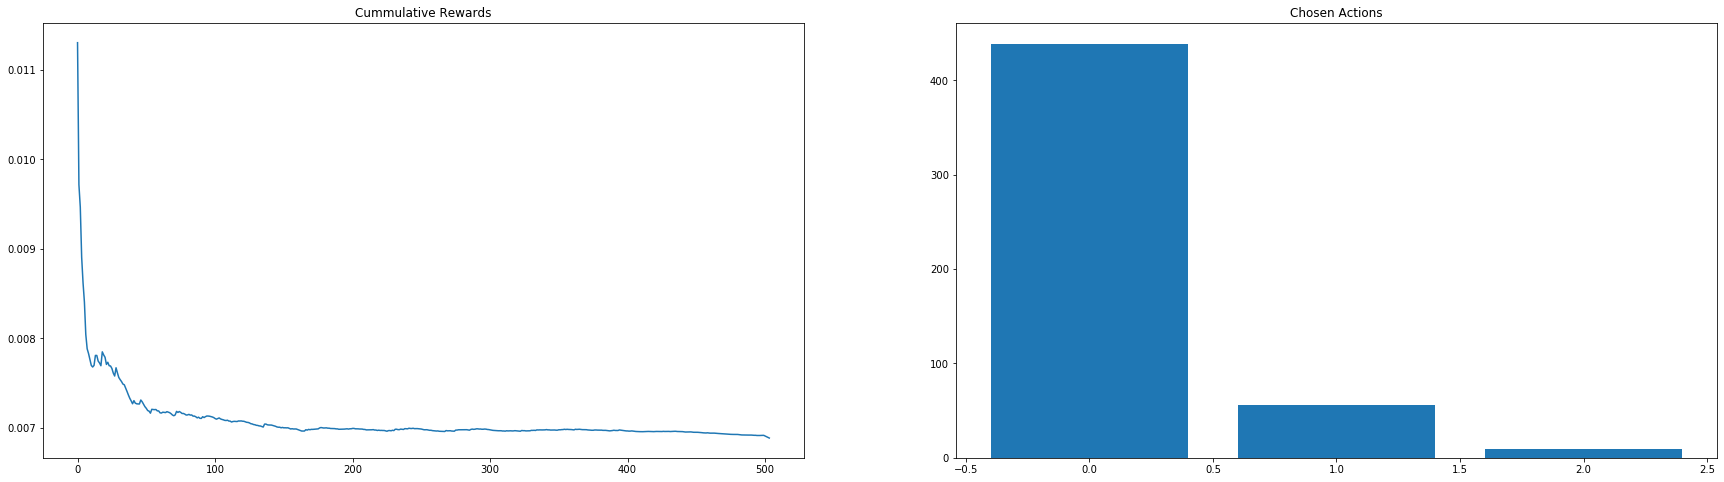

Up to iteration 796
Average rewards per algo {'quick_sort': 0.003422784931514848, 'merge_sort': 0.0, 'heap_sort': 0.006574100000307226}
Count per chosen algo {'quick_sort': 292, 'merge_sort': 0, 'heap_sort': 1}


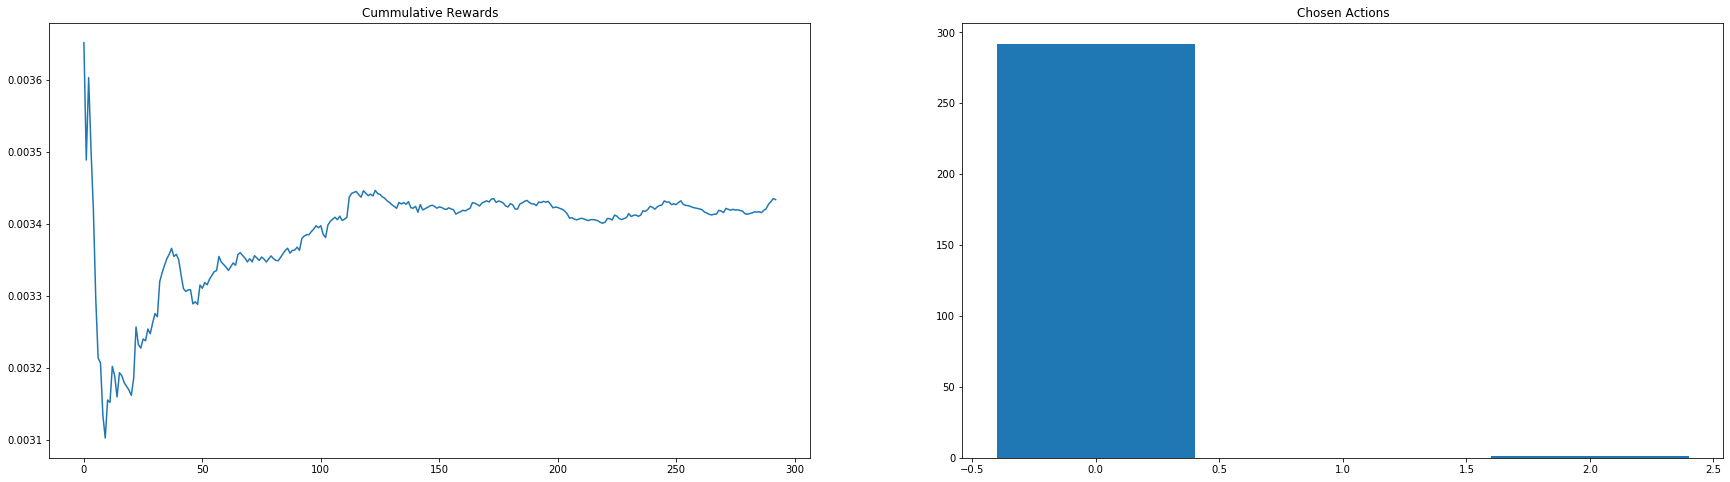

Up to iteration 927
Average rewards per algo {'quick_sort': 0.003459214285742616, 'merge_sort': 0.0028413000000000466, 'heap_sort': 0.005952708943106138}
Count per chosen algo {'quick_sort': 7, 'merge_sort': 1, 'heap_sort': 123}


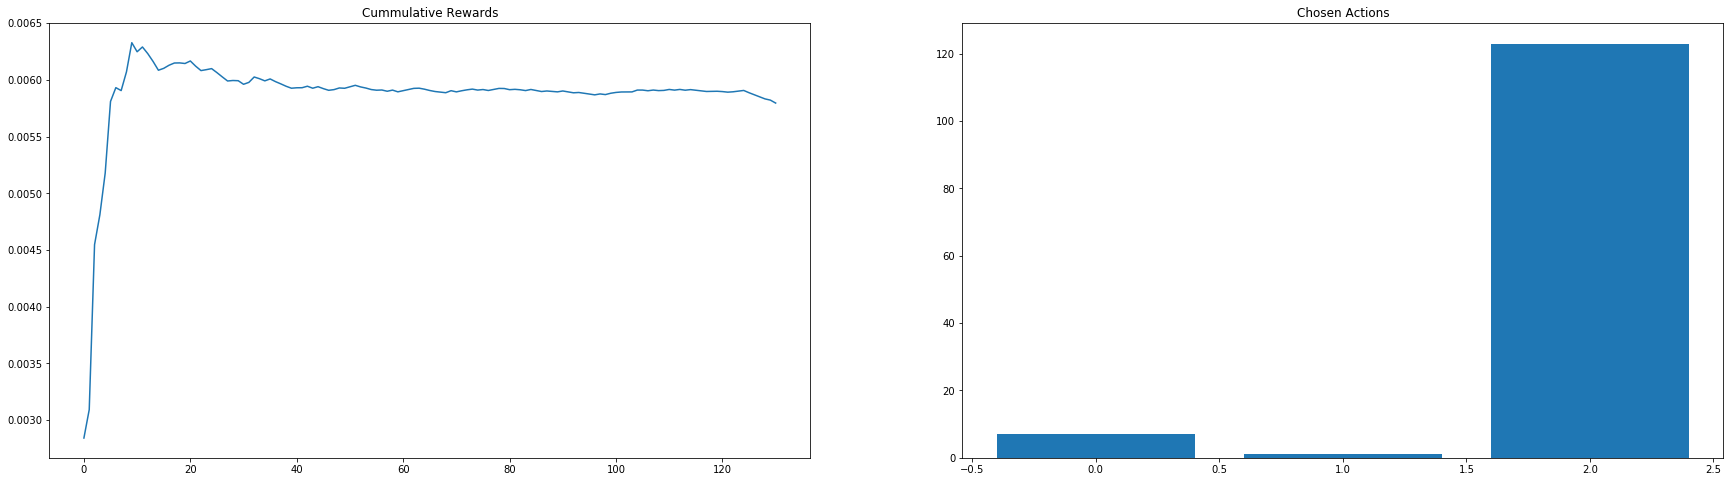

Up to iteration 1003
Average rewards per algo {'quick_sort': 0.003626228947304729, 'merge_sort': 0.0, 'heap_sort': 0.0}
Count per chosen algo {'quick_sort': 76, 'merge_sort': 0, 'heap_sort': 0}


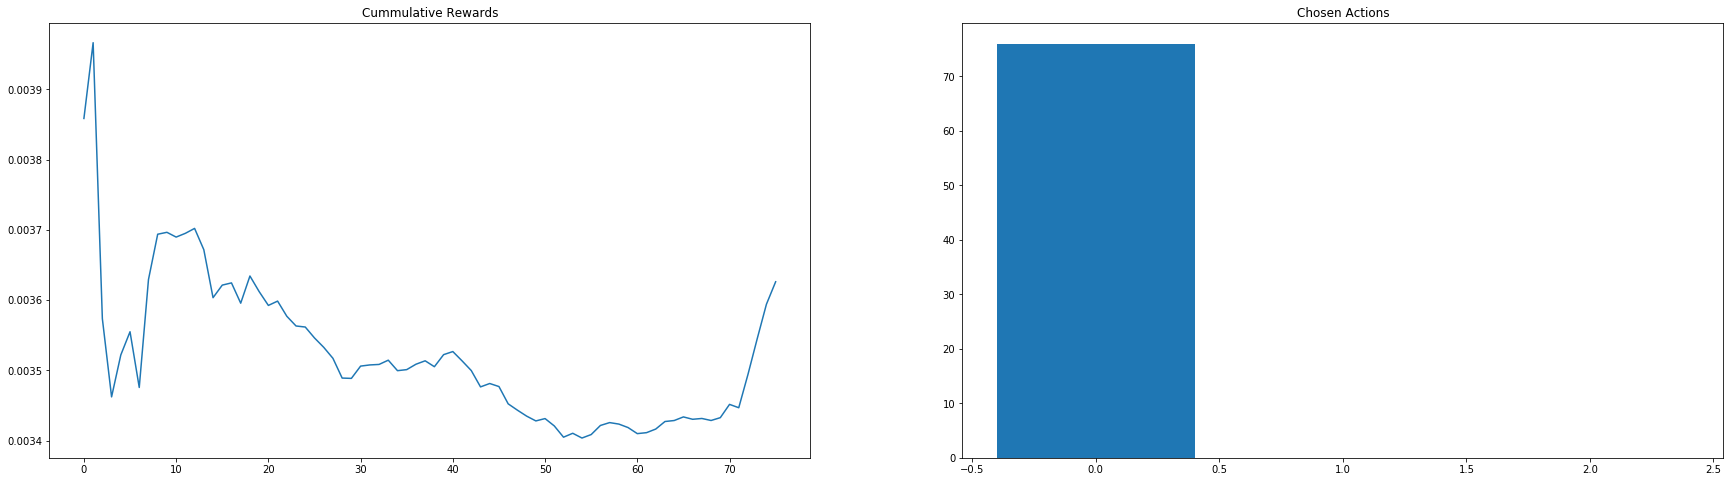

Up to iteration 1503
Average rewards per algo {'quick_sort': 0.006677905278590576, 'merge_sort': 0.007386542763155926, 'heap_sort': 0.010160471428662277}
Count per chosen algo {'quick_sort': 341, 'merge_sort': 152, 'heap_sort': 7}


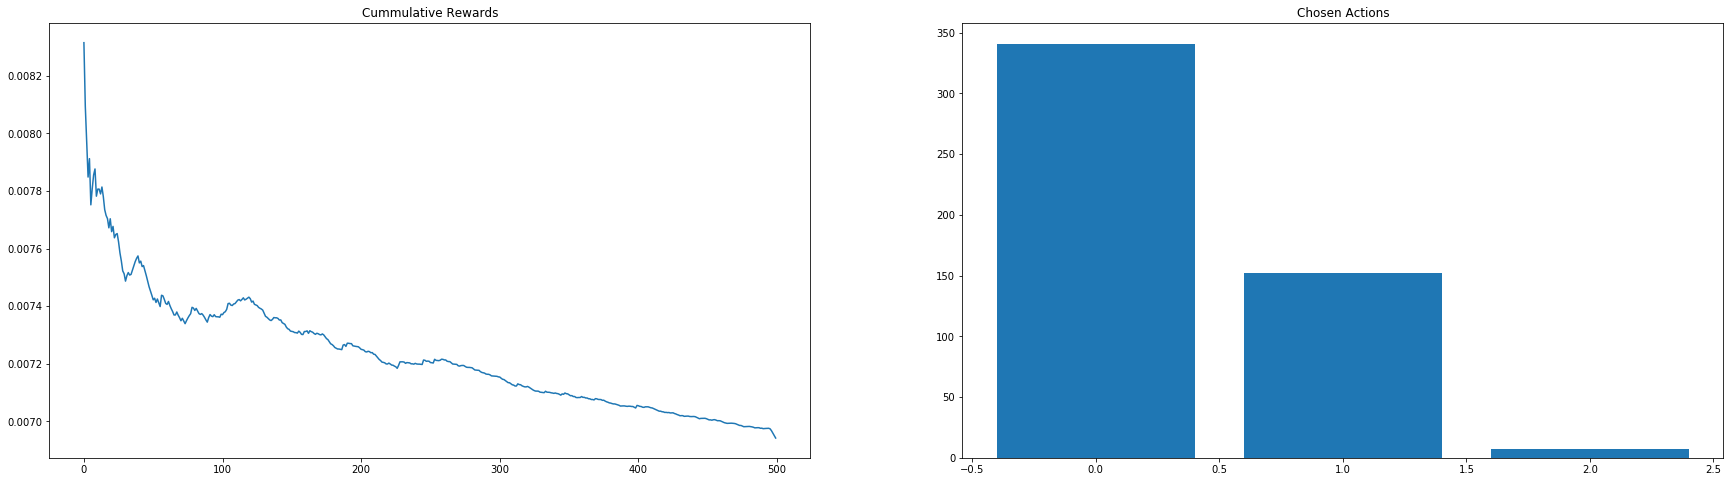

Up to iteration 1774
Average rewards per algo {'quick_sort': 0.0, 'merge_sort': 0.002621725000039987, 'heap_sort': 0.006300927340815294}
Count per chosen algo {'quick_sort': 0, 'merge_sort': 4, 'heap_sort': 267}


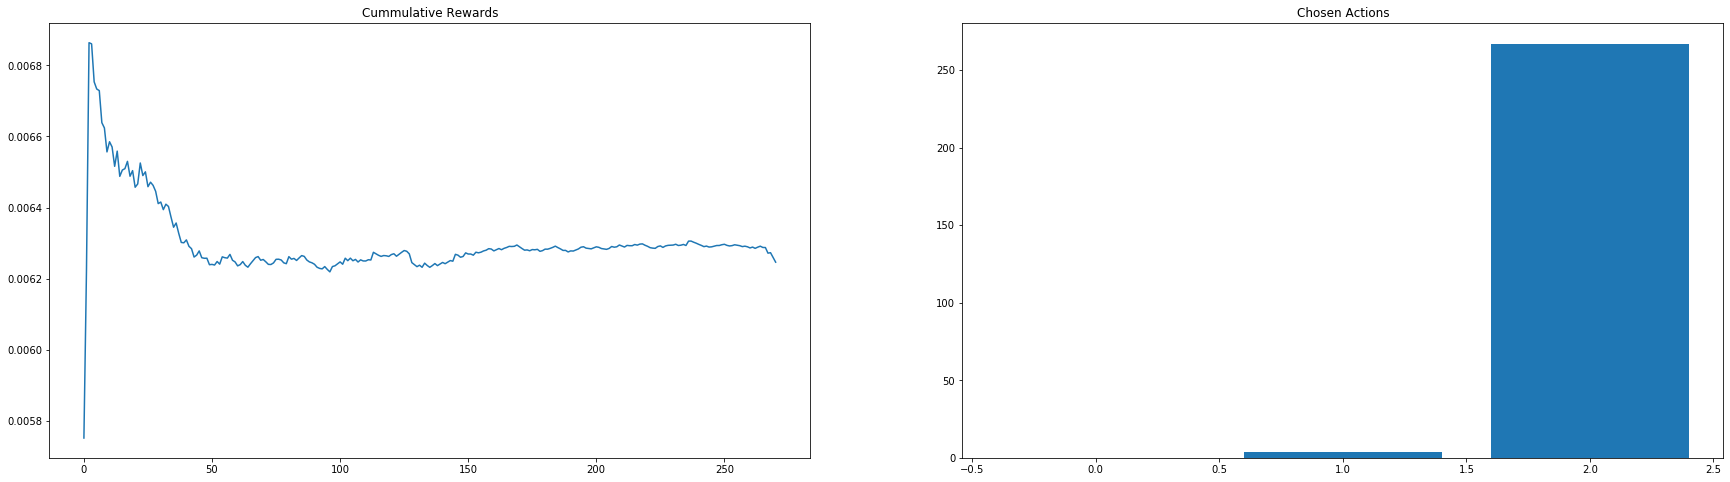

Up to iteration 1999
Average rewards per algo {'quick_sort': 0.0033787537037521056, 'merge_sort': 0.002830062416104671, 'heap_sort': 0.006296836363658672}
Count per chosen algo {'quick_sort': 54, 'merge_sort': 149, 'heap_sort': 22}


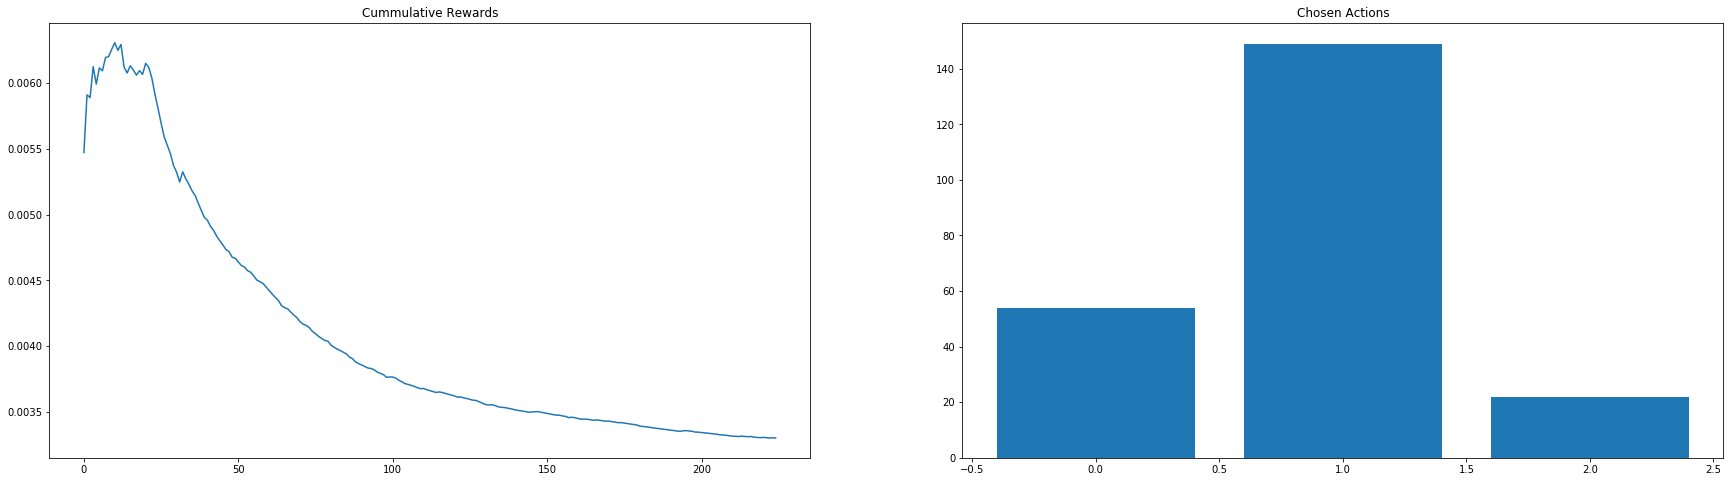

Total reward 11.4185


In [73]:
for elem in list_iteration_results_obcp:
    sample_mean, sample_count,rewards,cum_rewards,n = elem
    print("Up to iteration", n)
    plot_history(rewards,cum_rewards, sample_count, sample_mean)
print("Total reward", np.round(total_reward_obcp,4))